In [1]:
from cc.env.collect import sample_feedforward_and_collect
from cc.env import make_env
from cc.examples.neural_ode_model_compact_example import make_neural_ode_model
from cc.train import (
    ModelControllerTrainer, TrainingOptionsModel, 
    EvaluationMetrices, Tracker, make_dataloader, DictLogger,
    Regularisation, SupervisedDataset
)
import jax.random as jrand
from cc.utils import rmse, l2_norm
import optax
import jax.numpy as jnp

/home/simon/miniforge3/envs/chain_control/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
time_limit = 10.0
control_timestep = 0.01

env = make_env("two_segments_v1", time_limit=time_limit, control_timestep=control_timestep, random=1)

In [3]:
sample_train = sample_feedforward_and_collect(
    env,
    seeds_gp=[0,1,2,3,4,5,6,7,8,9,10,11],
    seeds_cos=[1,2,3,4,5,6,7,8,9,10,12,14]
)

sample_val = sample_feedforward_and_collect(
    env, 
    seeds_gp=[15, 16, 17, 18],
    seeds_cos=[2.5, 5.0, 7.5, 10.0]
)

In [4]:
model = make_neural_ode_model(
    env.action_spec(),
    env.observation_spec(),
    env.control_timestep,
    state_dim=50,
    f_depth=0, 
    u_transform=jnp.arctan
)

In [5]:
model_train_dataloader = make_dataloader(
    SupervisedDataset(sample_train.action, sample_train.obs), # <- (X, y)
    jrand.PRNGKey(2,), 
    n_minibatches=4
)

optimizer = optax.adam(1e-3)

regularisers = (
    Regularisation(
        prefactor = 0.5,
        reduce_weights = lambda vector_of_params: {"l2_norm": l2_norm(vector_of_params)}
    ),
)

metrices = (
    EvaluationMetrices(
        data = (sample_val.action, sample_val.obs), # <- (X, y)
        metrices=(
            lambda y, yhat: {"val_rmse": rmse(y, yhat)}, 
        )
    ),
)

model_train_options = TrainingOptionsModel(
    model_train_dataloader, 
    optimizer, 
    regularisers=regularisers,
    metrices=metrices
)

model_trainer = ModelControllerTrainer(
    model, 
    model_train_options=model_train_options,
    loggers=[DictLogger()],
    trackers=[Tracker("val_rmse")]
)

In [6]:
model_trainer.run(700)

  0%|                                                                                                                              | 0/700 [00:00<?, ?it/s]

l2_norm:     4.1751 | train_loss:    24.9210 | train_mse:    22.8335 | val_rmse:     7.3042 | :   0%|                              | 0/700 [00:02<?, ?it/s]

l2_norm:     4.1751 | train_loss:    24.9210 | train_mse:    22.8335 | val_rmse:     7.3042 | :   0%|                      | 1/700 [00:02<28:05,  2.41s/it]

l2_norm:     4.1700 | train_loss:    23.0971 | train_mse:    21.0120 | val_rmse:     7.1716 | :   0%|                      | 1/700 [00:05<28:05,  2.41s/it]

l2_norm:     4.1700 | train_loss:    23.0971 | train_mse:    21.0120 | val_rmse:     7.1716 | :   0%|                      | 2/700 [00:05<30:51,  2.65s/it]

l2_norm:     4.1680 | train_loss:    21.0874 | train_mse:    19.0035 | val_rmse:     6.8295 | :   0%|                      | 2/700 [00:05<30:51,  2.65s/it]

l2_norm:     4.1680 | train_loss:    21.0874 | train_mse:    19.0035 | val_rmse:     6.8295 | :   0%|                      | 3/700 [00:05<17:33,  1.51s/it]

l2_norm:     4.1690 | train_loss:    19.4094 | train_mse:    17.3249 | val_rmse:     6.5354 | :   0%|                      | 3/700 [00:05<17:33,  1.51s/it]

l2_norm:     4.1690 | train_loss:    19.4094 | train_mse:    17.3249 | val_rmse:     6.5354 | :   1%|▏                     | 4/700 [00:05<11:19,  1.02it/s]

l2_norm:     4.1722 | train_loss:    18.6396 | train_mse:    16.5535 | val_rmse:     6.3523 | :   1%|▏                     | 4/700 [00:05<11:19,  1.02it/s]

l2_norm:     4.1722 | train_loss:    18.6396 | train_mse:    16.5535 | val_rmse:     6.3523 | :   1%|▏                     | 5/700 [00:05<07:51,  1.47it/s]

l2_norm:     4.1762 | train_loss:    17.1977 | train_mse:    15.1096 | val_rmse:     5.8643 | :   1%|▏                     | 5/700 [00:05<07:51,  1.47it/s]

l2_norm:     4.1762 | train_loss:    17.1977 | train_mse:    15.1096 | val_rmse:     5.8643 | :   1%|▏                     | 6/700 [00:05<05:46,  2.00it/s]

l2_norm:     4.1804 | train_loss:    17.6103 | train_mse:    15.5202 | val_rmse:     5.9832 | :   1%|▏                     | 6/700 [00:05<05:46,  2.00it/s]

l2_norm:     4.1804 | train_loss:    17.6103 | train_mse:    15.5202 | val_rmse:     5.9832 | :   1%|▏                     | 7/700 [00:05<04:27,  2.59it/s]

l2_norm:     4.1815 | train_loss:    16.6666 | train_mse:    14.5758 | val_rmse:     5.9643 | :   1%|▏                     | 7/700 [00:06<04:27,  2.59it/s]

l2_norm:     4.1815 | train_loss:    16.6666 | train_mse:    14.5758 | val_rmse:     5.9643 | :   1%|▎                     | 8/700 [00:06<03:35,  3.21it/s]

l2_norm:     4.1809 | train_loss:    16.4536 | train_mse:    14.3631 | val_rmse:     6.0009 | :   1%|▎                     | 8/700 [00:06<03:35,  3.21it/s]

l2_norm:     4.1809 | train_loss:    16.4536 | train_mse:    14.3631 | val_rmse:     6.0009 | :   1%|▎                     | 9/700 [00:06<03:01,  3.81it/s]

l2_norm:     4.1821 | train_loss:    15.7505 | train_mse:    13.6594 | val_rmse:     5.8287 | :   1%|▎                     | 9/700 [00:06<03:01,  3.81it/s]

l2_norm:     4.1821 | train_loss:    15.7505 | train_mse:    13.6594 | val_rmse:     5.8287 | :   1%|▎                    | 10/700 [00:06<02:38,  4.37it/s]

l2_norm:     4.1857 | train_loss:    16.6646 | train_mse:    14.5718 | val_rmse:     5.9144 | :   1%|▎                    | 10/700 [00:06<02:38,  4.37it/s]

l2_norm:     4.1857 | train_loss:    16.6646 | train_mse:    14.5718 | val_rmse:     5.9144 | :   2%|▎                    | 11/700 [00:06<02:21,  4.88it/s]

l2_norm:     4.1894 | train_loss:    14.8654 | train_mse:    12.7707 | val_rmse:     5.3733 | :   2%|▎                    | 11/700 [00:06<02:21,  4.88it/s]

l2_norm:     4.1894 | train_loss:    14.8654 | train_mse:    12.7707 | val_rmse:     5.3733 | :   2%|▎                    | 12/700 [00:06<02:09,  5.29it/s]

l2_norm:     4.1941 | train_loss:    15.1321 | train_mse:    13.0350 | val_rmse:     5.4784 | :   2%|▎                    | 12/700 [00:06<02:09,  5.29it/s]

l2_norm:     4.1941 | train_loss:    15.1321 | train_mse:    13.0350 | val_rmse:     5.4784 | :   2%|▍                    | 13/700 [00:06<02:02,  5.62it/s]

l2_norm:     4.1982 | train_loss:    14.8970 | train_mse:    12.7979 | val_rmse:     5.2872 | :   2%|▍                    | 13/700 [00:07<02:02,  5.62it/s]

l2_norm:     4.1982 | train_loss:    14.8970 | train_mse:    12.7979 | val_rmse:     5.2872 | :   2%|▍                    | 14/700 [00:07<01:56,  5.89it/s]

l2_norm:     4.2010 | train_loss:    13.3491 | train_mse:    11.2485 | val_rmse:     5.2340 | :   2%|▍                    | 14/700 [00:07<01:56,  5.89it/s]

l2_norm:     4.2010 | train_loss:    13.3491 | train_mse:    11.2485 | val_rmse:     5.2340 | :   2%|▍                    | 15/700 [00:07<01:53,  6.04it/s]

l2_norm:     4.2060 | train_loss:    13.1276 | train_mse:    11.0246 | val_rmse:     4.8642 | :   2%|▍                    | 15/700 [00:07<01:53,  6.04it/s]

l2_norm:     4.2060 | train_loss:    13.1276 | train_mse:    11.0246 | val_rmse:     4.8642 | :   2%|▍                    | 16/700 [00:07<01:50,  6.17it/s]

l2_norm:     4.2126 | train_loss:    12.7041 | train_mse:    10.5978 | val_rmse:     4.7821 | :   2%|▍                    | 16/700 [00:07<01:50,  6.17it/s]

l2_norm:     4.2126 | train_loss:    12.7041 | train_mse:    10.5978 | val_rmse:     4.7821 | :   2%|▌                    | 17/700 [00:07<01:48,  6.27it/s]

l2_norm:     4.2189 | train_loss:    12.5678 | train_mse:    10.4583 | val_rmse:     4.5598 | :   2%|▌                    | 17/700 [00:07<01:48,  6.27it/s]

l2_norm:     4.2189 | train_loss:    12.5678 | train_mse:    10.4583 | val_rmse:     4.5598 | :   3%|▌                    | 18/700 [00:07<01:47,  6.37it/s]

l2_norm:     4.2247 | train_loss:    11.6843 | train_mse:     9.5719 | val_rmse:     4.6255 | :   3%|▌                    | 18/700 [00:07<01:47,  6.37it/s]

l2_norm:     4.2247 | train_loss:    11.6843 | train_mse:     9.5719 | val_rmse:     4.6255 | :   3%|▌                    | 19/700 [00:07<01:45,  6.44it/s]

l2_norm:     4.2301 | train_loss:    11.9394 | train_mse:     9.8244 | val_rmse:     4.4341 | :   3%|▌                    | 19/700 [00:07<01:45,  6.44it/s]

l2_norm:     4.2301 | train_loss:    11.9394 | train_mse:     9.8244 | val_rmse:     4.4341 | :   3%|▌                    | 20/700 [00:07<01:44,  6.49it/s]

l2_norm:     4.2347 | train_loss:    10.9339 | train_mse:     8.8165 | val_rmse:     3.8891 | :   3%|▌                    | 20/700 [00:08<01:44,  6.49it/s]

l2_norm:     4.2347 | train_loss:    10.9339 | train_mse:     8.8165 | val_rmse:     3.8891 | :   3%|▋                    | 21/700 [00:08<01:44,  6.52it/s]

l2_norm:     4.2390 | train_loss:    12.2215 | train_mse:    10.1020 | val_rmse:     4.6755 | :   3%|▋                    | 21/700 [00:08<01:44,  6.52it/s]

l2_norm:     4.2390 | train_loss:    12.2215 | train_mse:    10.1020 | val_rmse:     4.6755 | :   3%|▋                    | 22/700 [00:08<01:43,  6.53it/s]

l2_norm:     4.2429 | train_loss:    12.3655 | train_mse:    10.2441 | val_rmse:     4.5714 | :   3%|▋                    | 22/700 [00:08<01:43,  6.53it/s]

l2_norm:     4.2429 | train_loss:    12.3655 | train_mse:    10.2441 | val_rmse:     4.5714 | :   3%|▋                    | 23/700 [00:08<01:43,  6.54it/s]

l2_norm:     4.2460 | train_loss:    12.3700 | train_mse:    10.2470 | val_rmse:     4.5618 | :   3%|▋                    | 23/700 [00:08<01:43,  6.54it/s]

l2_norm:     4.2460 | train_loss:    12.3700 | train_mse:    10.2470 | val_rmse:     4.5618 | :   3%|▋                    | 24/700 [00:08<01:43,  6.56it/s]

l2_norm:     4.2461 | train_loss:    12.1385 | train_mse:    10.0155 | val_rmse:     3.8845 | :   3%|▋                    | 24/700 [00:08<01:43,  6.56it/s]

l2_norm:     4.2461 | train_loss:    12.1385 | train_mse:    10.0155 | val_rmse:     3.8845 | :   4%|▊                    | 25/700 [00:08<01:42,  6.58it/s]

l2_norm:     4.2465 | train_loss:     9.8587 | train_mse:     7.7355 | val_rmse:     4.4721 | :   4%|▊                    | 25/700 [00:08<01:42,  6.58it/s]

l2_norm:     4.2465 | train_loss:     9.8587 | train_mse:     7.7355 | val_rmse:     4.4721 | :   4%|▊                    | 26/700 [00:08<01:42,  6.57it/s]

l2_norm:     4.2492 | train_loss:    10.8199 | train_mse:     8.6953 | val_rmse:     4.1455 | :   4%|▊                    | 26/700 [00:09<01:42,  6.57it/s]

l2_norm:     4.2492 | train_loss:    10.8199 | train_mse:     8.6953 | val_rmse:     4.1455 | :   4%|▊                    | 27/700 [00:09<01:43,  6.53it/s]

l2_norm:     4.2522 | train_loss:    10.1100 | train_mse:     7.9839 | val_rmse:     4.0458 | :   4%|▊                    | 27/700 [00:09<01:43,  6.53it/s]

l2_norm:     4.2522 | train_loss:    10.1100 | train_mse:     7.9839 | val_rmse:     4.0458 | :   4%|▊                    | 28/700 [00:09<01:43,  6.52it/s]

l2_norm:     4.2556 | train_loss:     9.5442 | train_mse:     7.4164 | val_rmse:     3.6128 | :   4%|▊                    | 28/700 [00:09<01:43,  6.52it/s]

l2_norm:     4.2556 | train_loss:     9.5442 | train_mse:     7.4164 | val_rmse:     3.6128 | :   4%|▊                    | 29/700 [00:09<01:43,  6.51it/s]

l2_norm:     4.2606 | train_loss:    10.2593 | train_mse:     8.1291 | val_rmse:     3.8434 | :   4%|▊                    | 29/700 [00:09<01:43,  6.51it/s]

l2_norm:     4.2606 | train_loss:    10.2593 | train_mse:     8.1291 | val_rmse:     3.8434 | :   4%|▉                    | 30/700 [00:09<01:42,  6.55it/s]

l2_norm:     4.2658 | train_loss:     8.7055 | train_mse:     6.5726 | val_rmse:     3.2968 | :   4%|▉                    | 30/700 [00:09<01:42,  6.55it/s]

l2_norm:     4.2658 | train_loss:     8.7055 | train_mse:     6.5726 | val_rmse:     3.2968 | :   4%|▉                    | 31/700 [00:09<01:41,  6.57it/s]

l2_norm:     4.2709 | train_loss:    11.3633 | train_mse:     9.2279 | val_rmse:     3.6841 | :   4%|▉                    | 31/700 [00:09<01:41,  6.57it/s]

l2_norm:     4.2709 | train_loss:    11.3633 | train_mse:     9.2279 | val_rmse:     3.6841 | :   5%|▉                    | 32/700 [00:09<01:41,  6.56it/s]

l2_norm:     4.2753 | train_loss:    10.7303 | train_mse:     8.5926 | val_rmse:     3.6311 | :   5%|▉                    | 32/700 [00:09<01:41,  6.56it/s]

l2_norm:     4.2753 | train_loss:    10.7303 | train_mse:     8.5926 | val_rmse:     3.6311 | :   5%|▉                    | 33/700 [00:09<01:41,  6.58it/s]

l2_norm:     4.2781 | train_loss:    13.0985 | train_mse:    10.9594 | val_rmse:     4.2376 | :   5%|▉                    | 33/700 [00:10<01:41,  6.58it/s]

l2_norm:     4.2781 | train_loss:    13.0985 | train_mse:    10.9594 | val_rmse:     4.2376 | :   5%|█                    | 34/700 [00:10<01:41,  6.59it/s]

l2_norm:     4.2798 | train_loss:    11.0023 | train_mse:     8.8624 | val_rmse:     3.5671 | :   5%|█                    | 34/700 [00:10<01:41,  6.59it/s]

l2_norm:     4.2798 | train_loss:    11.0023 | train_mse:     8.8624 | val_rmse:     3.5671 | :   5%|█                    | 35/700 [00:10<01:40,  6.60it/s]

l2_norm:     4.2775 | train_loss:    10.7662 | train_mse:     8.6274 | val_rmse:     4.8612 | :   5%|█                    | 35/700 [00:10<01:40,  6.60it/s]

l2_norm:     4.2775 | train_loss:    10.7662 | train_mse:     8.6274 | val_rmse:     4.8612 | :   5%|█                    | 36/700 [00:10<01:40,  6.60it/s]

l2_norm:     4.2757 | train_loss:    11.7987 | train_mse:     9.6608 | val_rmse:     3.5744 | :   5%|█                    | 36/700 [00:10<01:40,  6.60it/s]

l2_norm:     4.2757 | train_loss:    11.7987 | train_mse:     9.6608 | val_rmse:     3.5744 | :   5%|█                    | 37/700 [00:10<01:40,  6.59it/s]

l2_norm:     4.2760 | train_loss:     9.0734 | train_mse:     6.9354 | val_rmse:     3.4440 | :   5%|█                    | 37/700 [00:10<01:40,  6.59it/s]

l2_norm:     4.2760 | train_loss:     9.0734 | train_mse:     6.9354 | val_rmse:     3.4440 | :   5%|█▏                   | 38/700 [00:10<01:40,  6.58it/s]

l2_norm:     4.2770 | train_loss:     8.6577 | train_mse:     6.5192 | val_rmse:     4.2280 | :   5%|█▏                   | 38/700 [00:10<01:40,  6.58it/s]

l2_norm:     4.2770 | train_loss:     8.6577 | train_mse:     6.5192 | val_rmse:     4.2280 | :   6%|█▏                   | 39/700 [00:10<01:40,  6.56it/s]

l2_norm:     4.2787 | train_loss:     9.5410 | train_mse:     7.4016 | val_rmse:     3.2195 | :   6%|█▏                   | 39/700 [00:11<01:40,  6.56it/s]

l2_norm:     4.2787 | train_loss:     9.5410 | train_mse:     7.4016 | val_rmse:     3.2195 | :   6%|█▏                   | 40/700 [00:11<01:40,  6.54it/s]

l2_norm:     4.2805 | train_loss:    11.5184 | train_mse:     9.3782 | val_rmse:     3.3785 | :   6%|█▏                   | 40/700 [00:11<01:40,  6.54it/s]

l2_norm:     4.2805 | train_loss:    11.5184 | train_mse:     9.3782 | val_rmse:     3.3785 | :   6%|█▏                   | 41/700 [00:11<01:40,  6.53it/s]

l2_norm:     4.2815 | train_loss:     9.5164 | train_mse:     7.3757 | val_rmse:     4.5952 | :   6%|█▏                   | 41/700 [00:11<01:40,  6.53it/s]

l2_norm:     4.2815 | train_loss:     9.5164 | train_mse:     7.3757 | val_rmse:     4.5952 | :   6%|█▎                   | 42/700 [00:11<01:41,  6.51it/s]

l2_norm:     4.2821 | train_loss:    10.7996 | train_mse:     8.6586 | val_rmse:     3.5088 | :   6%|█▎                   | 42/700 [00:11<01:41,  6.51it/s]

l2_norm:     4.2821 | train_loss:    10.7996 | train_mse:     8.6586 | val_rmse:     3.5088 | :   6%|█▎                   | 43/700 [00:11<01:40,  6.52it/s]

l2_norm:     4.2828 | train_loss:    10.2245 | train_mse:     8.0831 | val_rmse:     3.6007 | :   6%|█▎                   | 43/700 [00:11<01:40,  6.52it/s]

l2_norm:     4.2828 | train_loss:    10.2245 | train_mse:     8.0831 | val_rmse:     3.6007 | :   6%|█▎                   | 44/700 [00:11<01:40,  6.55it/s]

l2_norm:     4.2839 | train_loss:     8.0354 | train_mse:     5.8935 | val_rmse:     3.6956 | :   6%|█▎                   | 44/700 [00:11<01:40,  6.55it/s]

l2_norm:     4.2839 | train_loss:     8.0354 | train_mse:     5.8935 | val_rmse:     3.6956 | :   6%|█▎                   | 45/700 [00:11<01:39,  6.57it/s]

l2_norm:     4.2865 | train_loss:     8.2068 | train_mse:     6.0636 | val_rmse:     3.2236 | :   6%|█▎                   | 45/700 [00:11<01:39,  6.57it/s]

l2_norm:     4.2865 | train_loss:     8.2068 | train_mse:     6.0636 | val_rmse:     3.2236 | :   7%|█▍                   | 46/700 [00:11<01:39,  6.58it/s]

l2_norm:     4.2903 | train_loss:     8.5287 | train_mse:     6.3836 | val_rmse:     3.2223 | :   7%|█▍                   | 46/700 [00:12<01:39,  6.58it/s]

l2_norm:     4.2903 | train_loss:     8.5287 | train_mse:     6.3836 | val_rmse:     3.2223 | :   7%|█▍                   | 47/700 [00:12<01:39,  6.59it/s]

l2_norm:     4.2942 | train_loss:     7.5277 | train_mse:     5.3806 | val_rmse:     3.2055 | :   7%|█▍                   | 47/700 [00:12<01:39,  6.59it/s]

l2_norm:     4.2942 | train_loss:     7.5277 | train_mse:     5.3806 | val_rmse:     3.2055 | :   7%|█▍                   | 48/700 [00:12<01:38,  6.61it/s]

l2_norm:     4.2983 | train_loss:     7.8125 | train_mse:     5.6634 | val_rmse:     2.8188 | :   7%|█▍                   | 48/700 [00:12<01:38,  6.61it/s]

l2_norm:     4.2983 | train_loss:     7.8125 | train_mse:     5.6634 | val_rmse:     2.8188 | :   7%|█▍                   | 49/700 [00:12<01:38,  6.61it/s]

l2_norm:     4.3026 | train_loss:     7.5258 | train_mse:     5.3745 | val_rmse:     2.9353 | :   7%|█▍                   | 49/700 [00:12<01:38,  6.61it/s]

l2_norm:     4.3026 | train_loss:     7.5258 | train_mse:     5.3745 | val_rmse:     2.9353 | :   7%|█▌                   | 50/700 [00:12<01:38,  6.59it/s]

l2_norm:     4.3073 | train_loss:     6.3675 | train_mse:     4.2138 | val_rmse:     2.4910 | :   7%|█▌                   | 50/700 [00:12<01:38,  6.59it/s]

l2_norm:     4.3073 | train_loss:     6.3675 | train_mse:     4.2138 | val_rmse:     2.4910 | :   7%|█▌                   | 51/700 [00:12<01:38,  6.56it/s]

l2_norm:     4.3117 | train_loss:     8.9674 | train_mse:     6.8116 | val_rmse:     3.4965 | :   7%|█▌                   | 51/700 [00:12<01:38,  6.56it/s]

l2_norm:     4.3117 | train_loss:     8.9674 | train_mse:     6.8116 | val_rmse:     3.4965 | :   7%|█▌                   | 52/700 [00:12<01:39,  6.54it/s]

l2_norm:     4.3153 | train_loss:     7.6318 | train_mse:     5.4742 | val_rmse:     2.6126 | :   7%|█▌                   | 52/700 [00:13<01:39,  6.54it/s]

l2_norm:     4.3153 | train_loss:     7.6318 | train_mse:     5.4742 | val_rmse:     2.6126 | :   8%|█▌                   | 53/700 [00:13<01:39,  6.53it/s]

l2_norm:     4.3178 | train_loss:    10.2901 | train_mse:     8.1312 | val_rmse:     3.7641 | :   8%|█▌                   | 53/700 [00:13<01:39,  6.53it/s]

l2_norm:     4.3178 | train_loss:    10.2901 | train_mse:     8.1312 | val_rmse:     3.7641 | :   8%|█▌                   | 54/700 [00:13<01:38,  6.56it/s]

l2_norm:     4.3178 | train_loss:     8.6399 | train_mse:     6.4810 | val_rmse:     3.0841 | :   8%|█▌                   | 54/700 [00:13<01:38,  6.56it/s]

l2_norm:     4.3178 | train_loss:     8.6399 | train_mse:     6.4810 | val_rmse:     3.0841 | :   8%|█▋                   | 55/700 [00:13<01:38,  6.57it/s]

l2_norm:     4.3188 | train_loss:     6.4761 | train_mse:     4.3166 | val_rmse:     2.6946 | :   8%|█▋                   | 55/700 [00:13<01:38,  6.57it/s]

l2_norm:     4.3188 | train_loss:     6.4761 | train_mse:     4.3166 | val_rmse:     2.6946 | :   8%|█▋                   | 56/700 [00:13<01:37,  6.58it/s]

l2_norm:     4.3201 | train_loss:     7.3721 | train_mse:     5.2120 | val_rmse:     3.0683 | :   8%|█▋                   | 56/700 [00:13<01:37,  6.58it/s]

l2_norm:     4.3201 | train_loss:     7.3721 | train_mse:     5.2120 | val_rmse:     3.0683 | :   8%|█▋                   | 57/700 [00:13<01:38,  6.54it/s]

l2_norm:     4.3217 | train_loss:     7.4553 | train_mse:     5.2945 | val_rmse:     2.7075 | :   8%|█▋                   | 57/700 [00:13<01:38,  6.54it/s]

l2_norm:     4.3217 | train_loss:     7.4553 | train_mse:     5.2945 | val_rmse:     2.7075 | :   8%|█▋                   | 58/700 [00:13<01:37,  6.56it/s]

l2_norm:     4.3246 | train_loss:     5.8646 | train_mse:     3.7023 | val_rmse:     2.2827 | :   8%|█▋                   | 58/700 [00:13<01:37,  6.56it/s]

l2_norm:     4.3246 | train_loss:     5.8646 | train_mse:     3.7023 | val_rmse:     2.2827 | :   8%|█▊                   | 59/700 [00:13<01:37,  6.56it/s]

l2_norm:     4.3279 | train_loss:     7.4833 | train_mse:     5.3194 | val_rmse:     2.9585 | :   8%|█▊                   | 59/700 [00:14<01:37,  6.56it/s]

l2_norm:     4.3279 | train_loss:     7.4833 | train_mse:     5.3194 | val_rmse:     2.9585 | :   9%|█▊                   | 60/700 [00:14<01:37,  6.57it/s]

l2_norm:     4.3310 | train_loss:     6.7237 | train_mse:     4.5582 | val_rmse:     2.1761 | :   9%|█▊                   | 60/700 [00:14<01:37,  6.57it/s]

l2_norm:     4.3310 | train_loss:     6.7237 | train_mse:     4.5582 | val_rmse:     2.1761 | :   9%|█▊                   | 61/700 [00:14<01:37,  6.57it/s]

l2_norm:     4.3338 | train_loss:     7.2712 | train_mse:     5.1043 | val_rmse:     2.6371 | :   9%|█▊                   | 61/700 [00:14<01:37,  6.57it/s]

l2_norm:     4.3338 | train_loss:     7.2712 | train_mse:     5.1043 | val_rmse:     2.6371 | :   9%|█▊                   | 62/700 [00:14<01:37,  6.55it/s]

l2_norm:     4.3365 | train_loss:     6.0498 | train_mse:     3.8815 | val_rmse:     2.3674 | :   9%|█▊                   | 62/700 [00:14<01:37,  6.55it/s]

l2_norm:     4.3365 | train_loss:     6.0498 | train_mse:     3.8815 | val_rmse:     2.3674 | :   9%|█▉                   | 63/700 [00:14<01:37,  6.53it/s]

l2_norm:     4.3397 | train_loss:     7.4445 | train_mse:     5.2746 | val_rmse:     2.6333 | :   9%|█▉                   | 63/700 [00:14<01:37,  6.53it/s]

l2_norm:     4.3397 | train_loss:     7.4445 | train_mse:     5.2746 | val_rmse:     2.6333 | :   9%|█▉                   | 64/700 [00:14<01:37,  6.51it/s]

l2_norm:     4.3422 | train_loss:     7.3589 | train_mse:     5.1878 | val_rmse:     2.3821 | :   9%|█▉                   | 64/700 [00:14<01:37,  6.51it/s]

l2_norm:     4.3422 | train_loss:     7.3589 | train_mse:     5.1878 | val_rmse:     2.3821 | :   9%|█▉                   | 65/700 [00:14<01:37,  6.53it/s]

l2_norm:     4.3448 | train_loss:     5.5801 | train_mse:     3.4077 | val_rmse:     2.1622 | :   9%|█▉                   | 65/700 [00:14<01:37,  6.53it/s]

l2_norm:     4.3448 | train_loss:     5.5801 | train_mse:     3.4077 | val_rmse:     2.1622 | :   9%|█▉                   | 66/700 [00:14<01:36,  6.55it/s]

l2_norm:     4.3464 | train_loss:     6.8205 | train_mse:     4.6473 | val_rmse:     2.7807 | :   9%|█▉                   | 66/700 [00:15<01:36,  6.55it/s]

l2_norm:     4.3464 | train_loss:     6.8205 | train_mse:     4.6473 | val_rmse:     2.7807 | :  10%|██                   | 67/700 [00:15<01:36,  6.56it/s]

l2_norm:     4.3481 | train_loss:     5.7643 | train_mse:     3.5903 | val_rmse:     2.0554 | :  10%|██                   | 67/700 [00:15<01:36,  6.56it/s]

l2_norm:     4.3481 | train_loss:     5.7643 | train_mse:     3.5903 | val_rmse:     2.0554 | :  10%|██                   | 68/700 [00:15<01:36,  6.57it/s]

l2_norm:     4.3500 | train_loss:     7.3175 | train_mse:     5.1426 | val_rmse:     2.8774 | :  10%|██                   | 68/700 [00:15<01:36,  6.57it/s]

l2_norm:     4.3500 | train_loss:     7.3175 | train_mse:     5.1426 | val_rmse:     2.8774 | :  10%|██                   | 69/700 [00:15<01:36,  6.56it/s]

l2_norm:     4.3510 | train_loss:     7.6802 | train_mse:     5.5048 | val_rmse:     2.1992 | :  10%|██                   | 69/700 [00:15<01:36,  6.56it/s]

l2_norm:     4.3510 | train_loss:     7.6802 | train_mse:     5.5048 | val_rmse:     2.1992 | :  10%|██                   | 70/700 [00:15<01:35,  6.56it/s]

l2_norm:     4.3524 | train_loss:     5.8586 | train_mse:     3.6824 | val_rmse:     2.0937 | :  10%|██                   | 70/700 [00:15<01:35,  6.56it/s]

l2_norm:     4.3524 | train_loss:     5.8586 | train_mse:     3.6824 | val_rmse:     2.0937 | :  10%|██▏                  | 71/700 [00:15<01:35,  6.57it/s]

l2_norm:     4.3534 | train_loss:     5.3325 | train_mse:     3.1558 | val_rmse:     2.4821 | :  10%|██▏                  | 71/700 [00:15<01:35,  6.57it/s]

l2_norm:     4.3534 | train_loss:     5.3325 | train_mse:     3.1558 | val_rmse:     2.4821 | :  10%|██▏                  | 72/700 [00:15<01:35,  6.58it/s]

l2_norm:     4.3547 | train_loss:     6.2149 | train_mse:     4.0376 | val_rmse:     2.1963 | :  10%|██▏                  | 72/700 [00:16<01:35,  6.58it/s]

l2_norm:     4.3547 | train_loss:     6.2149 | train_mse:     4.0376 | val_rmse:     2.1963 | :  10%|██▏                  | 73/700 [00:16<01:34,  6.61it/s]

l2_norm:     4.3573 | train_loss:     5.7913 | train_mse:     3.6126 | val_rmse:     2.1287 | :  10%|██▏                  | 73/700 [00:16<01:34,  6.61it/s]

l2_norm:     4.3573 | train_loss:     5.7913 | train_mse:     3.6126 | val_rmse:     2.1287 | :  11%|██▏                  | 74/700 [00:16<01:35,  6.56it/s]

l2_norm:     4.3601 | train_loss:     5.0861 | train_mse:     2.9061 | val_rmse:     2.2393 | :  11%|██▏                  | 74/700 [00:16<01:35,  6.56it/s]

l2_norm:     4.3601 | train_loss:     5.0861 | train_mse:     2.9061 | val_rmse:     2.2393 | :  11%|██▎                  | 75/700 [00:16<01:35,  6.54it/s]

l2_norm:     4.3630 | train_loss:     5.3423 | train_mse:     3.1608 | val_rmse:     1.8121 | :  11%|██▎                  | 75/700 [00:16<01:35,  6.54it/s]

l2_norm:     4.3630 | train_loss:     5.3423 | train_mse:     3.1608 | val_rmse:     1.8121 | :  11%|██▎                  | 76/700 [00:16<01:35,  6.56it/s]

l2_norm:     4.3663 | train_loss:     6.2130 | train_mse:     4.0299 | val_rmse:     2.8927 | :  11%|██▎                  | 76/700 [00:16<01:35,  6.56it/s]

l2_norm:     4.3663 | train_loss:     6.2130 | train_mse:     4.0299 | val_rmse:     2.8927 | :  11%|██▎                  | 77/700 [00:16<01:34,  6.58it/s]

l2_norm:     4.3690 | train_loss:     6.6431 | train_mse:     4.4586 | val_rmse:     2.0652 | :  11%|██▎                  | 77/700 [00:16<01:34,  6.58it/s]

l2_norm:     4.3690 | train_loss:     6.6431 | train_mse:     4.4586 | val_rmse:     2.0652 | :  11%|██▎                  | 78/700 [00:16<01:34,  6.60it/s]

l2_norm:     4.3704 | train_loss:     7.4491 | train_mse:     5.2639 | val_rmse:     2.5698 | :  11%|██▎                  | 78/700 [00:16<01:34,  6.60it/s]

l2_norm:     4.3704 | train_loss:     7.4491 | train_mse:     5.2639 | val_rmse:     2.5698 | :  11%|██▎                  | 79/700 [00:16<01:34,  6.60it/s]

l2_norm:     4.3692 | train_loss:     8.9435 | train_mse:     6.7589 | val_rmse:     3.3640 | :  11%|██▎                  | 79/700 [00:17<01:34,  6.60it/s]

l2_norm:     4.3692 | train_loss:     8.9435 | train_mse:     6.7589 | val_rmse:     3.3640 | :  11%|██▍                  | 80/700 [00:17<01:33,  6.63it/s]

l2_norm:     4.3692 | train_loss:     6.9419 | train_mse:     4.7573 | val_rmse:     2.5069 | :  11%|██▍                  | 80/700 [00:17<01:33,  6.63it/s]

l2_norm:     4.3692 | train_loss:     6.9419 | train_mse:     4.7573 | val_rmse:     2.5069 | :  12%|██▍                  | 81/700 [00:17<01:33,  6.64it/s]

l2_norm:     4.3685 | train_loss:     9.4000 | train_mse:     7.2158 | val_rmse:     3.3594 | :  12%|██▍                  | 81/700 [00:17<01:33,  6.64it/s]

l2_norm:     4.3685 | train_loss:     9.4000 | train_mse:     7.2158 | val_rmse:     3.3594 | :  12%|██▍                  | 82/700 [00:17<01:33,  6.64it/s]

l2_norm:     4.3659 | train_loss:     8.1556 | train_mse:     5.9726 | val_rmse:     2.8508 | :  12%|██▍                  | 82/700 [00:17<01:33,  6.64it/s]

l2_norm:     4.3659 | train_loss:     8.1556 | train_mse:     5.9726 | val_rmse:     2.8508 | :  12%|██▍                  | 83/700 [00:17<01:32,  6.65it/s]

l2_norm:     4.3655 | train_loss:     5.6226 | train_mse:     3.4399 | val_rmse:     2.1817 | :  12%|██▍                  | 83/700 [00:17<01:32,  6.65it/s]

l2_norm:     4.3655 | train_loss:     5.6226 | train_mse:     3.4399 | val_rmse:     2.1817 | :  12%|██▌                  | 84/700 [00:17<01:32,  6.65it/s]

l2_norm:     4.3661 | train_loss:     6.1996 | train_mse:     4.0165 | val_rmse:     2.6918 | :  12%|██▌                  | 84/700 [00:17<01:32,  6.65it/s]

l2_norm:     4.3661 | train_loss:     6.1996 | train_mse:     4.0165 | val_rmse:     2.6918 | :  12%|██▌                  | 85/700 [00:17<01:32,  6.65it/s]

l2_norm:     4.3669 | train_loss:     6.1491 | train_mse:     3.9656 | val_rmse:     2.3626 | :  12%|██▌                  | 85/700 [00:18<01:32,  6.65it/s]

l2_norm:     4.3669 | train_loss:     6.1491 | train_mse:     3.9656 | val_rmse:     2.3626 | :  12%|██▌                  | 86/700 [00:18<01:32,  6.63it/s]

l2_norm:     4.3685 | train_loss:     4.9778 | train_mse:     2.7936 | val_rmse:     1.9147 | :  12%|██▌                  | 86/700 [00:18<01:32,  6.63it/s]

l2_norm:     4.3685 | train_loss:     4.9778 | train_mse:     2.7936 | val_rmse:     1.9147 | :  12%|██▌                  | 87/700 [00:18<01:32,  6.61it/s]

l2_norm:     4.3714 | train_loss:     5.0425 | train_mse:     2.8568 | val_rmse:     1.9853 | :  12%|██▌                  | 87/700 [00:18<01:32,  6.61it/s]

l2_norm:     4.3714 | train_loss:     5.0425 | train_mse:     2.8568 | val_rmse:     1.9853 | :  13%|██▋                  | 88/700 [00:18<01:32,  6.62it/s]

l2_norm:     4.3750 | train_loss:     4.8610 | train_mse:     2.6735 | val_rmse:     1.8813 | :  13%|██▋                  | 88/700 [00:18<01:32,  6.62it/s]

l2_norm:     4.3750 | train_loss:     4.8610 | train_mse:     2.6735 | val_rmse:     1.8813 | :  13%|██▋                  | 89/700 [00:18<01:32,  6.61it/s]

l2_norm:     4.3789 | train_loss:     4.6930 | train_mse:     2.5036 | val_rmse:     1.7886 | :  13%|██▋                  | 89/700 [00:18<01:32,  6.61it/s]

l2_norm:     4.3789 | train_loss:     4.6930 | train_mse:     2.5036 | val_rmse:     1.7886 | :  13%|██▋                  | 90/700 [00:18<01:32,  6.62it/s]

l2_norm:     4.3829 | train_loss:     4.6302 | train_mse:     2.4388 | val_rmse:     1.8777 | :  13%|██▋                  | 90/700 [00:18<01:32,  6.62it/s]

l2_norm:     4.3829 | train_loss:     4.6302 | train_mse:     2.4388 | val_rmse:     1.8777 | :  13%|██▋                  | 91/700 [00:18<01:31,  6.65it/s]

l2_norm:     4.3869 | train_loss:     4.5577 | train_mse:     2.3643 | val_rmse:     1.6472 | :  13%|██▋                  | 91/700 [00:18<01:31,  6.65it/s]

l2_norm:     4.3869 | train_loss:     4.5577 | train_mse:     2.3643 | val_rmse:     1.6472 | :  13%|██▊                  | 92/700 [00:18<01:31,  6.66it/s]

l2_norm:     4.3908 | train_loss:     5.4645 | train_mse:     3.2691 | val_rmse:     1.9025 | :  13%|██▊                  | 92/700 [00:19<01:31,  6.66it/s]

l2_norm:     4.3908 | train_loss:     5.4645 | train_mse:     3.2691 | val_rmse:     1.9025 | :  13%|██▊                  | 93/700 [00:19<01:31,  6.62it/s]

l2_norm:     4.3937 | train_loss:     5.5310 | train_mse:     3.3342 | val_rmse:     1.9155 | :  13%|██▊                  | 93/700 [00:19<01:31,  6.62it/s]

l2_norm:     4.3937 | train_loss:     5.5310 | train_mse:     3.3342 | val_rmse:     1.9155 | :  13%|██▊                  | 94/700 [00:19<01:31,  6.61it/s]

l2_norm:     4.3966 | train_loss:     4.7001 | train_mse:     2.5017 | val_rmse:     1.6371 | :  13%|██▊                  | 94/700 [00:19<01:31,  6.61it/s]

l2_norm:     4.3966 | train_loss:     4.7001 | train_mse:     2.5017 | val_rmse:     1.6371 | :  14%|██▊                  | 95/700 [00:19<01:31,  6.63it/s]

l2_norm:     4.3992 | train_loss:     6.2050 | train_mse:     4.0054 | val_rmse:     2.2323 | :  14%|██▊                  | 95/700 [00:19<01:31,  6.63it/s]

l2_norm:     4.3992 | train_loss:     6.2050 | train_mse:     4.0054 | val_rmse:     2.2323 | :  14%|██▉                  | 96/700 [00:19<01:30,  6.65it/s]

l2_norm:     4.4019 | train_loss:     4.3263 | train_mse:     2.1253 | val_rmse:     1.6761 | :  14%|██▉                  | 96/700 [00:19<01:30,  6.65it/s]

l2_norm:     4.4019 | train_loss:     4.3263 | train_mse:     2.1253 | val_rmse:     1.6761 | :  14%|██▉                  | 97/700 [00:19<01:30,  6.65it/s]

l2_norm:     4.4039 | train_loss:     5.4237 | train_mse:     3.2217 | val_rmse:     2.6429 | :  14%|██▉                  | 97/700 [00:19<01:30,  6.65it/s]

l2_norm:     4.4039 | train_loss:     5.4237 | train_mse:     3.2217 | val_rmse:     2.6429 | :  14%|██▉                  | 98/700 [00:19<01:30,  6.63it/s]

l2_norm:     4.4040 | train_loss:     7.7132 | train_mse:     5.5112 | val_rmse:     1.7420 | :  14%|██▉                  | 98/700 [00:19<01:30,  6.63it/s]

l2_norm:     4.4040 | train_loss:     7.7132 | train_mse:     5.5112 | val_rmse:     1.7420 | :  14%|██▉                  | 99/700 [00:19<01:30,  6.61it/s]

l2_norm:     4.4038 | train_loss:     5.5951 | train_mse:     3.3932 | val_rmse:     1.9120 | :  14%|██▉                  | 99/700 [00:20<01:30,  6.61it/s]

l2_norm:     4.4038 | train_loss:     5.5951 | train_mse:     3.3932 | val_rmse:     1.9120 | :  14%|██▊                 | 100/700 [00:20<01:30,  6.62it/s]

l2_norm:     4.4033 | train_loss:     4.5895 | train_mse:     2.3878 | val_rmse:     2.2414 | :  14%|██▊                 | 100/700 [00:20<01:30,  6.62it/s]

l2_norm:     4.4033 | train_loss:     4.5895 | train_mse:     2.3878 | val_rmse:     2.2414 | :  14%|██▉                 | 101/700 [00:20<01:30,  6.61it/s]

l2_norm:     4.4041 | train_loss:     4.4160 | train_mse:     2.2139 | val_rmse:     1.5832 | :  14%|██▉                 | 101/700 [00:20<01:30,  6.61it/s]

l2_norm:     4.4041 | train_loss:     4.4160 | train_mse:     2.2139 | val_rmse:     1.5832 | :  15%|██▉                 | 102/700 [00:20<01:30,  6.63it/s]

l2_norm:     4.4059 | train_loss:     5.0243 | train_mse:     2.8213 | val_rmse:     1.6997 | :  15%|██▉                 | 102/700 [00:20<01:30,  6.63it/s]

l2_norm:     4.4059 | train_loss:     5.0243 | train_mse:     2.8213 | val_rmse:     1.6997 | :  15%|██▉                 | 103/700 [00:20<01:29,  6.63it/s]

l2_norm:     4.4071 | train_loss:     5.8944 | train_mse:     3.6909 | val_rmse:     1.9846 | :  15%|██▉                 | 103/700 [00:20<01:29,  6.63it/s]

l2_norm:     4.4071 | train_loss:     5.8944 | train_mse:     3.6909 | val_rmse:     1.9846 | :  15%|██▉                 | 104/700 [00:20<01:33,  6.40it/s]

l2_norm:     4.4082 | train_loss:     8.0308 | train_mse:     5.8267 | val_rmse:     1.5278 | :  15%|██▉                 | 104/700 [00:20<01:33,  6.40it/s]

l2_norm:     4.4082 | train_loss:     8.0308 | train_mse:     5.8267 | val_rmse:     1.5278 | :  15%|███                 | 105/700 [00:20<01:34,  6.33it/s]

l2_norm:     4.4080 | train_loss:     7.8392 | train_mse:     5.6352 | val_rmse:     3.9452 | :  15%|███                 | 105/700 [00:21<01:34,  6.33it/s]

l2_norm:     4.4080 | train_loss:     7.8392 | train_mse:     5.6352 | val_rmse:     3.9452 | :  15%|███                 | 106/700 [00:21<01:33,  6.35it/s]

l2_norm:     4.4073 | train_loss:     9.6425 | train_mse:     7.4388 | val_rmse:     2.1785 | :  15%|███                 | 106/700 [00:21<01:33,  6.35it/s]

l2_norm:     4.4073 | train_loss:     9.6425 | train_mse:     7.4388 | val_rmse:     2.1785 | :  15%|███                 | 107/700 [00:21<01:33,  6.37it/s]

l2_norm:     4.4062 | train_loss:     7.2079 | train_mse:     5.0048 | val_rmse:     2.2971 | :  15%|███                 | 107/700 [00:21<01:33,  6.37it/s]

l2_norm:     4.4062 | train_loss:     7.2079 | train_mse:     5.0048 | val_rmse:     2.2971 | :  15%|███                 | 108/700 [00:21<01:32,  6.42it/s]

l2_norm:     4.4037 | train_loss:     5.4752 | train_mse:     3.2733 | val_rmse:     2.6493 | :  15%|███                 | 108/700 [00:21<01:32,  6.42it/s]

l2_norm:     4.4037 | train_loss:     5.4752 | train_mse:     3.2733 | val_rmse:     2.6493 | :  16%|███                 | 109/700 [00:21<01:31,  6.45it/s]

l2_norm:     4.4031 | train_loss:     5.1919 | train_mse:     2.9904 | val_rmse:     2.2993 | :  16%|███                 | 109/700 [00:21<01:31,  6.45it/s]

l2_norm:     4.4031 | train_loss:     5.1919 | train_mse:     2.9904 | val_rmse:     2.2993 | :  16%|███▏                | 110/700 [00:21<01:31,  6.46it/s]

l2_norm:     4.4047 | train_loss:     4.7572 | train_mse:     2.5549 | val_rmse:     1.7770 | :  16%|███▏                | 110/700 [00:21<01:31,  6.46it/s]

l2_norm:     4.4047 | train_loss:     4.7572 | train_mse:     2.5549 | val_rmse:     1.7770 | :  16%|███▏                | 111/700 [00:21<01:30,  6.50it/s]

l2_norm:     4.4072 | train_loss:     4.6078 | train_mse:     2.4042 | val_rmse:     2.0049 | :  16%|███▏                | 111/700 [00:21<01:30,  6.50it/s]

l2_norm:     4.4072 | train_loss:     4.6078 | train_mse:     2.4042 | val_rmse:     2.0049 | :  16%|███▏                | 112/700 [00:21<01:29,  6.54it/s]

l2_norm:     4.4103 | train_loss:     4.3079 | train_mse:     2.1027 | val_rmse:     1.4255 | :  16%|███▏                | 112/700 [00:22<01:29,  6.54it/s]

l2_norm:     4.4103 | train_loss:     4.3079 | train_mse:     2.1027 | val_rmse:     1.4255 | :  16%|███▏                | 113/700 [00:22<01:29,  6.58it/s]

l2_norm:     4.4137 | train_loss:     4.5775 | train_mse:     2.3707 | val_rmse:     1.5327 | :  16%|███▏                | 113/700 [00:22<01:29,  6.58it/s]

l2_norm:     4.4137 | train_loss:     4.5775 | train_mse:     2.3707 | val_rmse:     1.5327 | :  16%|███▎                | 114/700 [00:22<01:28,  6.60it/s]

l2_norm:     4.4163 | train_loss:     4.9038 | train_mse:     2.6956 | val_rmse:     1.7114 | :  16%|███▎                | 114/700 [00:22<01:28,  6.60it/s]

l2_norm:     4.4163 | train_loss:     4.9038 | train_mse:     2.6956 | val_rmse:     1.7114 | :  16%|███▎                | 115/700 [00:22<01:28,  6.63it/s]

l2_norm:     4.4188 | train_loss:     4.0867 | train_mse:     1.8773 | val_rmse:     1.5767 | :  16%|███▎                | 115/700 [00:22<01:28,  6.63it/s]

l2_norm:     4.4188 | train_loss:     4.0867 | train_mse:     1.8773 | val_rmse:     1.5767 | :  17%|███▎                | 116/700 [00:22<01:28,  6.63it/s]

l2_norm:     4.4205 | train_loss:     5.4155 | train_mse:     3.2053 | val_rmse:     2.5737 | :  17%|███▎                | 116/700 [00:22<01:28,  6.63it/s]

l2_norm:     4.4205 | train_loss:     5.4155 | train_mse:     3.2053 | val_rmse:     2.5737 | :  17%|███▎                | 117/700 [00:22<01:27,  6.65it/s]

l2_norm:     4.4214 | train_loss:     6.3610 | train_mse:     4.1503 | val_rmse:     1.9097 | :  17%|███▎                | 117/700 [00:22<01:27,  6.65it/s]

l2_norm:     4.4214 | train_loss:     6.3610 | train_mse:     4.1503 | val_rmse:     1.9097 | :  17%|███▎                | 118/700 [00:22<01:27,  6.64it/s]

l2_norm:     4.4234 | train_loss:     4.6308 | train_mse:     2.4191 | val_rmse:     1.6524 | :  17%|███▎                | 118/700 [00:23<01:27,  6.64it/s]

l2_norm:     4.4234 | train_loss:     4.6308 | train_mse:     2.4191 | val_rmse:     1.6524 | :  17%|███▍                | 119/700 [00:23<01:27,  6.64it/s]

l2_norm:     4.4250 | train_loss:     4.2498 | train_mse:     2.0373 | val_rmse:     1.9846 | :  17%|███▍                | 119/700 [00:23<01:27,  6.64it/s]

l2_norm:     4.4250 | train_loss:     4.2498 | train_mse:     2.0373 | val_rmse:     1.9846 | :  17%|███▍                | 120/700 [00:23<01:27,  6.66it/s]

l2_norm:     4.4266 | train_loss:     4.3582 | train_mse:     2.1449 | val_rmse:     1.6964 | :  17%|███▍                | 120/700 [00:23<01:27,  6.66it/s]

l2_norm:     4.4266 | train_loss:     4.3582 | train_mse:     2.1449 | val_rmse:     1.6964 | :  17%|███▍                | 121/700 [00:23<01:27,  6.65it/s]

l2_norm:     4.4291 | train_loss:     3.8905 | train_mse:     1.6760 | val_rmse:     1.3580 | :  17%|███▍                | 121/700 [00:23<01:27,  6.65it/s]

l2_norm:     4.4291 | train_loss:     3.8905 | train_mse:     1.6760 | val_rmse:     1.3580 | :  17%|███▍                | 122/700 [00:23<01:27,  6.63it/s]

l2_norm:     4.4319 | train_loss:     3.7479 | train_mse:     1.5320 | val_rmse:     1.4854 | :  17%|███▍                | 122/700 [00:23<01:27,  6.63it/s]

l2_norm:     4.4319 | train_loss:     3.7479 | train_mse:     1.5320 | val_rmse:     1.4854 | :  18%|███▌                | 123/700 [00:23<01:27,  6.61it/s]

l2_norm:     4.4351 | train_loss:     3.6478 | train_mse:     1.4302 | val_rmse:     1.1995 | :  18%|███▌                | 123/700 [00:23<01:27,  6.61it/s]

l2_norm:     4.4351 | train_loss:     3.6478 | train_mse:     1.4302 | val_rmse:     1.1995 | :  18%|███▌                | 124/700 [00:23<01:27,  6.60it/s]

l2_norm:     4.4380 | train_loss:     3.9712 | train_mse:     1.7522 | val_rmse:     1.2653 | :  18%|███▌                | 124/700 [00:23<01:27,  6.60it/s]

l2_norm:     4.4380 | train_loss:     3.9712 | train_mse:     1.7522 | val_rmse:     1.2653 | :  18%|███▌                | 125/700 [00:23<01:27,  6.60it/s]

l2_norm:     4.4403 | train_loss:     3.7708 | train_mse:     1.5507 | val_rmse:     1.4524 | :  18%|███▌                | 125/700 [00:24<01:27,  6.60it/s]

l2_norm:     4.4403 | train_loss:     3.7708 | train_mse:     1.5507 | val_rmse:     1.4524 | :  18%|███▌                | 126/700 [00:24<01:27,  6.59it/s]

l2_norm:     4.4427 | train_loss:     3.8598 | train_mse:     1.6385 | val_rmse:     1.2947 | :  18%|███▌                | 126/700 [00:24<01:27,  6.59it/s]

l2_norm:     4.4427 | train_loss:     3.8598 | train_mse:     1.6385 | val_rmse:     1.2947 | :  18%|███▋                | 127/700 [00:24<01:27,  6.58it/s]

l2_norm:     4.4446 | train_loss:     3.8378 | train_mse:     1.6155 | val_rmse:     1.5584 | :  18%|███▋                | 127/700 [00:24<01:27,  6.58it/s]

l2_norm:     4.4446 | train_loss:     3.8378 | train_mse:     1.6155 | val_rmse:     1.5584 | :  18%|███▋                | 128/700 [00:24<01:26,  6.61it/s]

l2_norm:     4.4461 | train_loss:     4.0834 | train_mse:     1.8603 | val_rmse:     1.3275 | :  18%|███▋                | 128/700 [00:24<01:26,  6.61it/s]

l2_norm:     4.4461 | train_loss:     4.0834 | train_mse:     1.8603 | val_rmse:     1.3275 | :  18%|███▋                | 129/700 [00:24<01:26,  6.61it/s]

l2_norm:     4.4484 | train_loss:     3.7484 | train_mse:     1.5242 | val_rmse:     1.2897 | :  18%|███▋                | 129/700 [00:24<01:26,  6.61it/s]

l2_norm:     4.4484 | train_loss:     3.7484 | train_mse:     1.5242 | val_rmse:     1.2897 | :  19%|███▋                | 130/700 [00:24<01:25,  6.63it/s]

l2_norm:     4.4503 | train_loss:     3.6488 | train_mse:     1.4237 | val_rmse:     1.3777 | :  19%|███▋                | 130/700 [00:24<01:25,  6.63it/s]

l2_norm:     4.4503 | train_loss:     3.6488 | train_mse:     1.4237 | val_rmse:     1.3777 | :  19%|███▋                | 131/700 [00:24<01:25,  6.63it/s]

l2_norm:     4.4526 | train_loss:     3.4909 | train_mse:     1.2646 | val_rmse:     1.1887 | :  19%|███▋                | 131/700 [00:25<01:25,  6.63it/s]

l2_norm:     4.4526 | train_loss:     3.4909 | train_mse:     1.2646 | val_rmse:     1.1887 | :  19%|███▊                | 132/700 [00:25<01:25,  6.61it/s]

l2_norm:     4.4545 | train_loss:     3.5370 | train_mse:     1.3097 | val_rmse:     1.6480 | :  19%|███▊                | 132/700 [00:25<01:25,  6.61it/s]

l2_norm:     4.4545 | train_loss:     3.5370 | train_mse:     1.3097 | val_rmse:     1.6480 | :  19%|███▊                | 133/700 [00:25<01:25,  6.61it/s]

l2_norm:     4.4561 | train_loss:     4.0540 | train_mse:     1.8260 | val_rmse:     1.1530 | :  19%|███▊                | 133/700 [00:25<01:25,  6.61it/s]

l2_norm:     4.4561 | train_loss:     4.0540 | train_mse:     1.8260 | val_rmse:     1.1530 | :  19%|███▊                | 134/700 [00:25<01:25,  6.60it/s]

l2_norm:     4.4580 | train_loss:     3.5152 | train_mse:     1.2862 | val_rmse:     1.1567 | :  19%|███▊                | 134/700 [00:25<01:25,  6.60it/s]

l2_norm:     4.4580 | train_loss:     3.5152 | train_mse:     1.2862 | val_rmse:     1.1567 | :  19%|███▊                | 135/700 [00:25<01:25,  6.58it/s]

l2_norm:     4.4599 | train_loss:     3.3011 | train_mse:     1.0712 | val_rmse:     1.1803 | :  19%|███▊                | 135/700 [00:25<01:25,  6.58it/s]

l2_norm:     4.4599 | train_loss:     3.3011 | train_mse:     1.0712 | val_rmse:     1.1803 | :  19%|███▉                | 136/700 [00:25<01:25,  6.60it/s]

l2_norm:     4.4621 | train_loss:     3.5045 | train_mse:     1.2734 | val_rmse:     1.1022 | :  19%|███▉                | 136/700 [00:25<01:25,  6.60it/s]

l2_norm:     4.4621 | train_loss:     3.5045 | train_mse:     1.2734 | val_rmse:     1.1022 | :  20%|███▉                | 137/700 [00:25<01:25,  6.61it/s]

l2_norm:     4.4644 | train_loss:     3.6680 | train_mse:     1.4358 | val_rmse:     1.3027 | :  20%|███▉                | 137/700 [00:25<01:25,  6.61it/s]

l2_norm:     4.4644 | train_loss:     3.6680 | train_mse:     1.4358 | val_rmse:     1.3027 | :  20%|███▉                | 138/700 [00:25<01:24,  6.63it/s]

l2_norm:     4.4669 | train_loss:     3.2630 | train_mse:     1.0295 | val_rmse:     1.0300 | :  20%|███▉                | 138/700 [00:26<01:24,  6.63it/s]

l2_norm:     4.4669 | train_loss:     3.2630 | train_mse:     1.0295 | val_rmse:     1.0300 | :  20%|███▉                | 139/700 [00:26<01:24,  6.63it/s]

l2_norm:     4.4691 | train_loss:     3.4711 | train_mse:     1.2366 | val_rmse:     1.1599 | :  20%|███▉                | 139/700 [00:26<01:24,  6.63it/s]

l2_norm:     4.4691 | train_loss:     3.4711 | train_mse:     1.2366 | val_rmse:     1.1599 | :  20%|████                | 140/700 [00:26<01:24,  6.60it/s]

l2_norm:     4.4712 | train_loss:     3.2273 | train_mse:     0.9917 | val_rmse:     1.0004 | :  20%|████                | 140/700 [00:26<01:24,  6.60it/s]

l2_norm:     4.4712 | train_loss:     3.2273 | train_mse:     0.9917 | val_rmse:     1.0004 | :  20%|████                | 141/700 [00:26<01:24,  6.59it/s]

l2_norm:     4.4733 | train_loss:     3.6028 | train_mse:     1.3662 | val_rmse:     1.2553 | :  20%|████                | 141/700 [00:26<01:24,  6.59it/s]

l2_norm:     4.4733 | train_loss:     3.6028 | train_mse:     1.3662 | val_rmse:     1.2553 | :  20%|████                | 142/700 [00:26<01:24,  6.57it/s]

l2_norm:     4.4753 | train_loss:     3.2729 | train_mse:     1.0352 | val_rmse:     1.0016 | :  20%|████                | 142/700 [00:26<01:24,  6.57it/s]

l2_norm:     4.4753 | train_loss:     3.2729 | train_mse:     1.0352 | val_rmse:     1.0016 | :  20%|████                | 143/700 [00:26<01:24,  6.60it/s]

l2_norm:     4.4772 | train_loss:     3.7310 | train_mse:     1.4924 | val_rmse:     1.3916 | :  20%|████                | 143/700 [00:26<01:24,  6.60it/s]

l2_norm:     4.4772 | train_loss:     3.7310 | train_mse:     1.4924 | val_rmse:     1.3916 | :  21%|████                | 144/700 [00:26<01:24,  6.59it/s]

l2_norm:     4.4787 | train_loss:     3.5074 | train_mse:     1.2681 | val_rmse:     1.0314 | :  21%|████                | 144/700 [00:26<01:24,  6.59it/s]

l2_norm:     4.4787 | train_loss:     3.5074 | train_mse:     1.2681 | val_rmse:     1.0314 | :  21%|████▏               | 145/700 [00:26<01:24,  6.55it/s]

l2_norm:     4.4804 | train_loss:     4.3254 | train_mse:     2.0852 | val_rmse:     1.6455 | :  21%|████▏               | 145/700 [00:27<01:24,  6.55it/s]

l2_norm:     4.4804 | train_loss:     4.3254 | train_mse:     2.0852 | val_rmse:     1.6455 | :  21%|████▏               | 146/700 [00:27<01:24,  6.54it/s]

l2_norm:     4.4813 | train_loss:     4.0750 | train_mse:     1.8343 | val_rmse:     1.1313 | :  21%|████▏               | 146/700 [00:27<01:24,  6.54it/s]

l2_norm:     4.4813 | train_loss:     4.0750 | train_mse:     1.8343 | val_rmse:     1.1313 | :  21%|████▏               | 147/700 [00:27<01:24,  6.55it/s]

l2_norm:     4.4824 | train_loss:     5.3222 | train_mse:     3.0810 | val_rmse:     1.9295 | :  21%|████▏               | 147/700 [00:27<01:24,  6.55it/s]

l2_norm:     4.4824 | train_loss:     5.3222 | train_mse:     3.0810 | val_rmse:     1.9295 | :  21%|████▏               | 148/700 [00:27<01:23,  6.59it/s]

l2_norm:     4.4812 | train_loss:     6.1501 | train_mse:     3.9095 | val_rmse:     1.6871 | :  21%|████▏               | 148/700 [00:27<01:23,  6.59it/s]

l2_norm:     4.4812 | train_loss:     6.1501 | train_mse:     3.9095 | val_rmse:     1.6871 | :  21%|████▎               | 149/700 [00:27<01:23,  6.62it/s]

l2_norm:     4.4802 | train_loss:     5.8997 | train_mse:     3.6596 | val_rmse:     1.3504 | :  21%|████▎               | 149/700 [00:27<01:23,  6.62it/s]

l2_norm:     4.4802 | train_loss:     5.8997 | train_mse:     3.6596 | val_rmse:     1.3504 | :  21%|████▎               | 150/700 [00:27<01:22,  6.64it/s]

l2_norm:     4.4782 | train_loss:     6.0687 | train_mse:     3.8296 | val_rmse:     3.0397 | :  21%|████▎               | 150/700 [00:27<01:22,  6.64it/s]

l2_norm:     4.4782 | train_loss:     6.0687 | train_mse:     3.8296 | val_rmse:     3.0397 | :  22%|████▎               | 151/700 [00:27<01:22,  6.65it/s]

l2_norm:     4.4772 | train_loss:     6.8075 | train_mse:     4.5688 | val_rmse:     1.7452 | :  22%|████▎               | 151/700 [00:28<01:22,  6.65it/s]

l2_norm:     4.4772 | train_loss:     6.8075 | train_mse:     4.5688 | val_rmse:     1.7452 | :  22%|████▎               | 152/700 [00:28<01:22,  6.64it/s]

l2_norm:     4.4762 | train_loss:     6.2672 | train_mse:     4.0291 | val_rmse:     2.1380 | :  22%|████▎               | 152/700 [00:28<01:22,  6.64it/s]

l2_norm:     4.4762 | train_loss:     6.2672 | train_mse:     4.0291 | val_rmse:     2.1380 | :  22%|████▎               | 153/700 [00:28<01:22,  6.66it/s]

l2_norm:     4.4743 | train_loss:     4.5812 | train_mse:     2.3441 | val_rmse:     1.8624 | :  22%|████▎               | 153/700 [00:28<01:22,  6.66it/s]

l2_norm:     4.4743 | train_loss:     4.5812 | train_mse:     2.3441 | val_rmse:     1.8624 | :  22%|████▍               | 154/700 [00:28<01:22,  6.65it/s]

l2_norm:     4.4750 | train_loss:     4.1357 | train_mse:     1.8982 | val_rmse:     1.2443 | :  22%|████▍               | 154/700 [00:28<01:22,  6.65it/s]

l2_norm:     4.4750 | train_loss:     4.1357 | train_mse:     1.8982 | val_rmse:     1.2443 | :  22%|████▍               | 155/700 [00:28<01:21,  6.65it/s]

l2_norm:     4.4766 | train_loss:     3.4941 | train_mse:     1.2557 | val_rmse:     1.7381 | :  22%|████▍               | 155/700 [00:28<01:21,  6.65it/s]

l2_norm:     4.4766 | train_loss:     3.4941 | train_mse:     1.2557 | val_rmse:     1.7381 | :  22%|████▍               | 156/700 [00:28<01:21,  6.66it/s]

l2_norm:     4.4786 | train_loss:     3.8371 | train_mse:     1.5978 | val_rmse:     1.0872 | :  22%|████▍               | 156/700 [00:28<01:21,  6.66it/s]

l2_norm:     4.4786 | train_loss:     3.8371 | train_mse:     1.5978 | val_rmse:     1.0872 | :  22%|████▍               | 157/700 [00:28<01:22,  6.61it/s]

l2_norm:     4.4807 | train_loss:     3.5554 | train_mse:     1.3150 | val_rmse:     1.1594 | :  22%|████▍               | 157/700 [00:28<01:22,  6.61it/s]

l2_norm:     4.4807 | train_loss:     3.5554 | train_mse:     1.3150 | val_rmse:     1.1594 | :  23%|████▌               | 158/700 [00:28<01:22,  6.56it/s]

l2_norm:     4.4825 | train_loss:     3.2065 | train_mse:     0.9652 | val_rmse:     1.0841 | :  23%|████▌               | 158/700 [00:29<01:22,  6.56it/s]

l2_norm:     4.4825 | train_loss:     3.2065 | train_mse:     0.9652 | val_rmse:     1.0841 | :  23%|████▌               | 159/700 [00:29<01:22,  6.57it/s]

l2_norm:     4.4845 | train_loss:     3.0659 | train_mse:     0.8237 | val_rmse:     1.0047 | :  23%|████▌               | 159/700 [00:29<01:22,  6.57it/s]

l2_norm:     4.4845 | train_loss:     3.0659 | train_mse:     0.8237 | val_rmse:     1.0047 | :  23%|████▌               | 160/700 [00:29<01:22,  6.57it/s]

l2_norm:     4.4865 | train_loss:     3.1716 | train_mse:     0.9284 | val_rmse:     1.0592 | :  23%|████▌               | 160/700 [00:29<01:22,  6.57it/s]

l2_norm:     4.4865 | train_loss:     3.1716 | train_mse:     0.9284 | val_rmse:     1.0592 | :  23%|████▌               | 161/700 [00:29<01:22,  6.54it/s]

l2_norm:     4.4884 | train_loss:     3.0600 | train_mse:     0.8158 | val_rmse:     1.1531 | :  23%|████▌               | 161/700 [00:29<01:22,  6.54it/s]

l2_norm:     4.4884 | train_loss:     3.0600 | train_mse:     0.8158 | val_rmse:     1.1531 | :  23%|████▋               | 162/700 [00:29<01:22,  6.55it/s]

l2_norm:     4.4907 | train_loss:     3.0246 | train_mse:     0.7792 | val_rmse:     0.9479 | :  23%|████▋               | 162/700 [00:29<01:22,  6.55it/s]

l2_norm:     4.4907 | train_loss:     3.0246 | train_mse:     0.7792 | val_rmse:     0.9479 | :  23%|████▋               | 163/700 [00:29<01:21,  6.58it/s]

l2_norm:     4.4930 | train_loss:     3.0638 | train_mse:     0.8173 | val_rmse:     1.0005 | :  23%|████▋               | 163/700 [00:29<01:21,  6.58it/s]

l2_norm:     4.4930 | train_loss:     3.0638 | train_mse:     0.8173 | val_rmse:     1.0005 | :  23%|████▋               | 164/700 [00:29<01:21,  6.60it/s]

l2_norm:     4.4953 | train_loss:     2.9899 | train_mse:     0.7423 | val_rmse:     0.9039 | :  23%|████▋               | 164/700 [00:30<01:21,  6.60it/s]

l2_norm:     4.4953 | train_loss:     2.9899 | train_mse:     0.7423 | val_rmse:     0.9039 | :  24%|████▋               | 165/700 [00:30<01:20,  6.62it/s]

l2_norm:     4.4975 | train_loss:     3.0491 | train_mse:     0.8004 | val_rmse:     0.8993 | :  24%|████▋               | 165/700 [00:30<01:20,  6.62it/s]

l2_norm:     4.4975 | train_loss:     3.0491 | train_mse:     0.8004 | val_rmse:     0.8993 | :  24%|████▋               | 166/700 [00:30<01:20,  6.64it/s]

l2_norm:     4.4995 | train_loss:     3.0250 | train_mse:     0.7752 | val_rmse:     1.1398 | :  24%|████▋               | 166/700 [00:30<01:20,  6.64it/s]

l2_norm:     4.4995 | train_loss:     3.0250 | train_mse:     0.7752 | val_rmse:     1.1398 | :  24%|████▊               | 167/700 [00:30<01:20,  6.64it/s]

l2_norm:     4.5015 | train_loss:     3.0665 | train_mse:     0.8158 | val_rmse:     0.8505 | :  24%|████▊               | 167/700 [00:30<01:20,  6.64it/s]

l2_norm:     4.5015 | train_loss:     3.0665 | train_mse:     0.8158 | val_rmse:     0.8505 | :  24%|████▊               | 168/700 [00:30<01:20,  6.63it/s]

l2_norm:     4.5033 | train_loss:     2.9778 | train_mse:     0.7262 | val_rmse:     0.8959 | :  24%|████▊               | 168/700 [00:30<01:20,  6.63it/s]

l2_norm:     4.5033 | train_loss:     2.9778 | train_mse:     0.7262 | val_rmse:     0.8959 | :  24%|████▊               | 169/700 [00:30<01:20,  6.63it/s]

l2_norm:     4.5048 | train_loss:     3.0257 | train_mse:     0.7733 | val_rmse:     0.8718 | :  24%|████▊               | 169/700 [00:30<01:20,  6.63it/s]

l2_norm:     4.5048 | train_loss:     3.0257 | train_mse:     0.7733 | val_rmse:     0.8718 | :  24%|████▊               | 170/700 [00:30<01:20,  6.60it/s]

l2_norm:     4.5065 | train_loss:     3.0030 | train_mse:     0.7497 | val_rmse:     0.8574 | :  24%|████▊               | 170/700 [00:30<01:20,  6.60it/s]

l2_norm:     4.5065 | train_loss:     3.0030 | train_mse:     0.7497 | val_rmse:     0.8574 | :  24%|████▉               | 171/700 [00:30<01:20,  6.59it/s]

l2_norm:     4.5078 | train_loss:     2.9604 | train_mse:     0.7065 | val_rmse:     0.9133 | :  24%|████▉               | 171/700 [00:31<01:20,  6.59it/s]

l2_norm:     4.5078 | train_loss:     2.9604 | train_mse:     0.7065 | val_rmse:     0.9133 | :  25%|████▉               | 172/700 [00:31<01:20,  6.58it/s]

l2_norm:     4.5093 | train_loss:     3.0194 | train_mse:     0.7648 | val_rmse:     0.8211 | :  25%|████▉               | 172/700 [00:31<01:20,  6.58it/s]

l2_norm:     4.5093 | train_loss:     3.0194 | train_mse:     0.7648 | val_rmse:     0.8211 | :  25%|████▉               | 173/700 [00:31<01:20,  6.55it/s]

l2_norm:     4.5105 | train_loss:     2.9725 | train_mse:     0.7173 | val_rmse:     0.8871 | :  25%|████▉               | 173/700 [00:31<01:20,  6.55it/s]

l2_norm:     4.5105 | train_loss:     2.9725 | train_mse:     0.7173 | val_rmse:     0.8871 | :  25%|████▉               | 174/700 [00:31<01:20,  6.56it/s]

l2_norm:     4.5118 | train_loss:     2.8975 | train_mse:     0.6416 | val_rmse:     0.8075 | :  25%|████▉               | 174/700 [00:31<01:20,  6.56it/s]

l2_norm:     4.5118 | train_loss:     2.8975 | train_mse:     0.6416 | val_rmse:     0.8075 | :  25%|█████               | 175/700 [00:31<01:20,  6.56it/s]

l2_norm:     4.5130 | train_loss:     2.9165 | train_mse:     0.6600 | val_rmse:     0.8824 | :  25%|█████               | 175/700 [00:31<01:20,  6.56it/s]

l2_norm:     4.5130 | train_loss:     2.9165 | train_mse:     0.6600 | val_rmse:     0.8824 | :  25%|█████               | 176/700 [00:31<01:19,  6.56it/s]

l2_norm:     4.5142 | train_loss:     2.8529 | train_mse:     0.5957 | val_rmse:     0.8162 | :  25%|█████               | 176/700 [00:31<01:19,  6.56it/s]

l2_norm:     4.5142 | train_loss:     2.8529 | train_mse:     0.5957 | val_rmse:     0.8162 | :  25%|█████               | 177/700 [00:31<01:19,  6.56it/s]

l2_norm:     4.5154 | train_loss:     2.9821 | train_mse:     0.7244 | val_rmse:     0.9602 | :  25%|█████               | 177/700 [00:31<01:19,  6.56it/s]

l2_norm:     4.5154 | train_loss:     2.9821 | train_mse:     0.7244 | val_rmse:     0.9602 | :  25%|█████               | 178/700 [00:31<01:19,  6.59it/s]

l2_norm:     4.5166 | train_loss:     2.9013 | train_mse:     0.6430 | val_rmse:     0.7826 | :  25%|█████               | 178/700 [00:32<01:19,  6.59it/s]

l2_norm:     4.5166 | train_loss:     2.9013 | train_mse:     0.6430 | val_rmse:     0.7826 | :  26%|█████               | 179/700 [00:32<01:19,  6.59it/s]

l2_norm:     4.5178 | train_loss:     2.8628 | train_mse:     0.6039 | val_rmse:     0.8341 | :  26%|█████               | 179/700 [00:32<01:19,  6.59it/s]

l2_norm:     4.5178 | train_loss:     2.8628 | train_mse:     0.6039 | val_rmse:     0.8341 | :  26%|█████▏              | 180/700 [00:32<01:18,  6.61it/s]

l2_norm:     4.5188 | train_loss:     2.8148 | train_mse:     0.5554 | val_rmse:     0.7785 | :  26%|█████▏              | 180/700 [00:32<01:18,  6.61it/s]

l2_norm:     4.5188 | train_loss:     2.8148 | train_mse:     0.5554 | val_rmse:     0.7785 | :  26%|█████▏              | 181/700 [00:32<01:18,  6.59it/s]

l2_norm:     4.5198 | train_loss:     2.8748 | train_mse:     0.6149 | val_rmse:     0.9244 | :  26%|█████▏              | 181/700 [00:32<01:18,  6.59it/s]

l2_norm:     4.5198 | train_loss:     2.8748 | train_mse:     0.6149 | val_rmse:     0.9244 | :  26%|█████▏              | 182/700 [00:32<01:18,  6.58it/s]

l2_norm:     4.5206 | train_loss:     2.9538 | train_mse:     0.6935 | val_rmse:     0.7883 | :  26%|█████▏              | 182/700 [00:32<01:18,  6.58it/s]

l2_norm:     4.5206 | train_loss:     2.9538 | train_mse:     0.6935 | val_rmse:     0.7883 | :  26%|█████▏              | 183/700 [00:32<01:18,  6.62it/s]

l2_norm:     4.5216 | train_loss:     3.0922 | train_mse:     0.8314 | val_rmse:     0.9443 | :  26%|█████▏              | 183/700 [00:32<01:18,  6.62it/s]

l2_norm:     4.5216 | train_loss:     3.0922 | train_mse:     0.8314 | val_rmse:     0.9443 | :  26%|█████▎              | 184/700 [00:32<01:17,  6.63it/s]

l2_norm:     4.5223 | train_loss:     3.2071 | train_mse:     0.9460 | val_rmse:     0.8093 | :  26%|█████▎              | 184/700 [00:33<01:17,  6.63it/s]

l2_norm:     4.5223 | train_loss:     3.2071 | train_mse:     0.9460 | val_rmse:     0.8093 | :  26%|█████▎              | 185/700 [00:33<01:17,  6.65it/s]

l2_norm:     4.5230 | train_loss:     3.3236 | train_mse:     1.0621 | val_rmse:     1.3726 | :  26%|█████▎              | 185/700 [00:33<01:17,  6.65it/s]

l2_norm:     4.5230 | train_loss:     3.3236 | train_mse:     1.0621 | val_rmse:     1.3726 | :  27%|█████▎              | 186/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5229 | train_loss:     3.5148 | train_mse:     1.2533 | val_rmse:     1.0344 | :  27%|█████▎              | 186/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5229 | train_loss:     3.5148 | train_mse:     1.2533 | val_rmse:     1.0344 | :  27%|█████▎              | 187/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5229 | train_loss:     3.3674 | train_mse:     1.1059 | val_rmse:     1.1320 | :  27%|█████▎              | 187/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5229 | train_loss:     3.3674 | train_mse:     1.1059 | val_rmse:     1.1320 | :  27%|█████▎              | 188/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5222 | train_loss:     3.2730 | train_mse:     1.0119 | val_rmse:     0.8791 | :  27%|█████▎              | 188/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5222 | train_loss:     3.2730 | train_mse:     1.0119 | val_rmse:     0.8791 | :  27%|█████▍              | 189/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5224 | train_loss:     3.0569 | train_mse:     0.7957 | val_rmse:     0.8778 | :  27%|█████▍              | 189/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5224 | train_loss:     3.0569 | train_mse:     0.7957 | val_rmse:     0.8778 | :  27%|█████▍              | 190/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5230 | train_loss:     2.8297 | train_mse:     0.5682 | val_rmse:     0.8573 | :  27%|█████▍              | 190/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5230 | train_loss:     2.8297 | train_mse:     0.5682 | val_rmse:     0.8573 | :  27%|█████▍              | 191/700 [00:33<01:16,  6.68it/s]

l2_norm:     4.5238 | train_loss:     2.8169 | train_mse:     0.5550 | val_rmse:     0.7870 | :  27%|█████▍              | 191/700 [00:34<01:16,  6.68it/s]

l2_norm:     4.5238 | train_loss:     2.8169 | train_mse:     0.5550 | val_rmse:     0.7870 | :  27%|█████▍              | 192/700 [00:34<01:16,  6.66it/s]

l2_norm:     4.5244 | train_loss:     2.7622 | train_mse:     0.5000 | val_rmse:     0.8041 | :  27%|█████▍              | 192/700 [00:34<01:16,  6.66it/s]

l2_norm:     4.5244 | train_loss:     2.7622 | train_mse:     0.5000 | val_rmse:     0.8041 | :  28%|█████▌              | 193/700 [00:34<01:16,  6.62it/s]

l2_norm:     4.5251 | train_loss:     2.7662 | train_mse:     0.5037 | val_rmse:     0.7899 | :  28%|█████▌              | 193/700 [00:34<01:16,  6.62it/s]

l2_norm:     4.5251 | train_loss:     2.7662 | train_mse:     0.5037 | val_rmse:     0.7899 | :  28%|█████▌              | 194/700 [00:34<01:16,  6.60it/s]

l2_norm:     4.5257 | train_loss:     2.7383 | train_mse:     0.4754 | val_rmse:     0.7784 | :  28%|█████▌              | 194/700 [00:34<01:16,  6.60it/s]

l2_norm:     4.5257 | train_loss:     2.7383 | train_mse:     0.4754 | val_rmse:     0.7784 | :  28%|█████▌              | 195/700 [00:34<01:16,  6.62it/s]

l2_norm:     4.5265 | train_loss:     2.7739 | train_mse:     0.5106 | val_rmse:     0.7752 | :  28%|█████▌              | 195/700 [00:34<01:16,  6.62it/s]

l2_norm:     4.5265 | train_loss:     2.7739 | train_mse:     0.5106 | val_rmse:     0.7752 | :  28%|█████▌              | 196/700 [00:34<01:15,  6.64it/s]

l2_norm:     4.5274 | train_loss:     2.7851 | train_mse:     0.5213 | val_rmse:     0.8216 | :  28%|█████▌              | 196/700 [00:34<01:15,  6.64it/s]

l2_norm:     4.5274 | train_loss:     2.7851 | train_mse:     0.5213 | val_rmse:     0.8216 | :  28%|█████▋              | 197/700 [00:34<01:15,  6.64it/s]

l2_norm:     4.5285 | train_loss:     2.8677 | train_mse:     0.6034 | val_rmse:     0.7417 | :  28%|█████▋              | 197/700 [00:34<01:15,  6.64it/s]

l2_norm:     4.5285 | train_loss:     2.8677 | train_mse:     0.6034 | val_rmse:     0.7417 | :  28%|█████▋              | 198/700 [00:34<01:15,  6.66it/s]

l2_norm:     4.5295 | train_loss:     2.7601 | train_mse:     0.4953 | val_rmse:     0.7316 | :  28%|█████▋              | 198/700 [00:35<01:15,  6.66it/s]

l2_norm:     4.5295 | train_loss:     2.7601 | train_mse:     0.4953 | val_rmse:     0.7316 | :  28%|█████▋              | 199/700 [00:35<01:15,  6.65it/s]

l2_norm:     4.5303 | train_loss:     2.7408 | train_mse:     0.4756 | val_rmse:     0.7416 | :  28%|█████▋              | 199/700 [00:35<01:15,  6.65it/s]

l2_norm:     4.5303 | train_loss:     2.7408 | train_mse:     0.4756 | val_rmse:     0.7416 | :  29%|█████▋              | 200/700 [00:35<01:15,  6.66it/s]

l2_norm:     4.5310 | train_loss:     2.6994 | train_mse:     0.4340 | val_rmse:     0.7200 | :  29%|█████▋              | 200/700 [00:35<01:15,  6.66it/s]

l2_norm:     4.5310 | train_loss:     2.6994 | train_mse:     0.4340 | val_rmse:     0.7200 | :  29%|█████▋              | 201/700 [00:35<01:14,  6.66it/s]

l2_norm:     4.5315 | train_loss:     2.7041 | train_mse:     0.4384 | val_rmse:     0.7717 | :  29%|█████▋              | 201/700 [00:35<01:14,  6.66it/s]

l2_norm:     4.5315 | train_loss:     2.7041 | train_mse:     0.4384 | val_rmse:     0.7717 | :  29%|█████▊              | 202/700 [00:35<01:14,  6.66it/s]

l2_norm:     4.5321 | train_loss:     2.7139 | train_mse:     0.4479 | val_rmse:     0.7207 | :  29%|█████▊              | 202/700 [00:35<01:14,  6.66it/s]

l2_norm:     4.5321 | train_loss:     2.7139 | train_mse:     0.4479 | val_rmse:     0.7207 | :  29%|█████▊              | 203/700 [00:35<01:14,  6.67it/s]

l2_norm:     4.5325 | train_loss:     2.7266 | train_mse:     0.4604 | val_rmse:     0.7956 | :  29%|█████▊              | 203/700 [00:35<01:14,  6.67it/s]

l2_norm:     4.5325 | train_loss:     2.7266 | train_mse:     0.4604 | val_rmse:     0.7956 | :  29%|█████▊              | 204/700 [00:35<01:14,  6.65it/s]

l2_norm:     4.5328 | train_loss:     2.7534 | train_mse:     0.4870 | val_rmse:     0.8004 | :  29%|█████▊              | 204/700 [00:36<01:14,  6.65it/s]

l2_norm:     4.5328 | train_loss:     2.7534 | train_mse:     0.4870 | val_rmse:     0.8004 | :  29%|█████▊              | 205/700 [00:36<01:14,  6.62it/s]

l2_norm:     4.5330 | train_loss:     2.8077 | train_mse:     0.5412 | val_rmse:     0.9396 | :  29%|█████▊              | 205/700 [00:36<01:14,  6.62it/s]

l2_norm:     4.5330 | train_loss:     2.8077 | train_mse:     0.5412 | val_rmse:     0.9396 | :  29%|█████▉              | 206/700 [00:36<01:15,  6.56it/s]

l2_norm:     4.5329 | train_loss:     2.9149 | train_mse:     0.6485 | val_rmse:     0.7577 | :  29%|█████▉              | 206/700 [00:36<01:15,  6.56it/s]

l2_norm:     4.5329 | train_loss:     2.9149 | train_mse:     0.6485 | val_rmse:     0.7577 | :  30%|█████▉              | 207/700 [00:36<01:15,  6.56it/s]

l2_norm:     4.5330 | train_loss:     3.0712 | train_mse:     0.8047 | val_rmse:     0.8340 | :  30%|█████▉              | 207/700 [00:36<01:15,  6.56it/s]

l2_norm:     4.5330 | train_loss:     3.0712 | train_mse:     0.8047 | val_rmse:     0.8340 | :  30%|█████▉              | 208/700 [00:36<01:15,  6.55it/s]

l2_norm:     4.5326 | train_loss:     3.6851 | train_mse:     1.4188 | val_rmse:     0.7976 | :  30%|█████▉              | 208/700 [00:36<01:15,  6.55it/s]

l2_norm:     4.5326 | train_loss:     3.6851 | train_mse:     1.4188 | val_rmse:     0.7976 | :  30%|█████▉              | 209/700 [00:36<01:14,  6.56it/s]

l2_norm:     4.5321 | train_loss:     5.3713 | train_mse:     3.1053 | val_rmse:     1.2023 | :  30%|█████▉              | 209/700 [00:36<01:14,  6.56it/s]

l2_norm:     4.5321 | train_loss:     5.3713 | train_mse:     3.1053 | val_rmse:     1.2023 | :  30%|██████              | 210/700 [00:36<01:14,  6.60it/s]

l2_norm:     4.5286 | train_loss:     9.2212 | train_mse:     6.9569 | val_rmse:     2.7521 | :  30%|██████              | 210/700 [00:36<01:14,  6.60it/s]

l2_norm:     4.5286 | train_loss:     9.2212 | train_mse:     6.9569 | val_rmse:     2.7521 | :  30%|██████              | 211/700 [00:36<01:13,  6.61it/s]

l2_norm:     4.5250 | train_loss:     7.3979 | train_mse:     5.1354 | val_rmse:     1.5131 | :  30%|██████              | 211/700 [00:37<01:13,  6.61it/s]

l2_norm:     4.5250 | train_loss:     7.3979 | train_mse:     5.1354 | val_rmse:     1.5131 | :  30%|██████              | 212/700 [00:37<01:13,  6.62it/s]

l2_norm:     4.5199 | train_loss:     6.5892 | train_mse:     4.3293 | val_rmse:     3.1128 | :  30%|██████              | 212/700 [00:37<01:13,  6.62it/s]

l2_norm:     4.5199 | train_loss:     6.5892 | train_mse:     4.3293 | val_rmse:     3.1128 | :  30%|██████              | 213/700 [00:37<01:13,  6.62it/s]

l2_norm:     4.5159 | train_loss:     6.4791 | train_mse:     4.2212 | val_rmse:     1.9255 | :  30%|██████              | 213/700 [00:37<01:13,  6.62it/s]

l2_norm:     4.5159 | train_loss:     6.4791 | train_mse:     4.2212 | val_rmse:     1.9255 | :  31%|██████              | 214/700 [00:37<01:13,  6.66it/s]

l2_norm:     4.5161 | train_loss:     4.4559 | train_mse:     2.1979 | val_rmse:     1.2405 | :  31%|██████              | 214/700 [00:37<01:13,  6.66it/s]

l2_norm:     4.5161 | train_loss:     4.4559 | train_mse:     2.1979 | val_rmse:     1.2405 | :  31%|██████▏             | 215/700 [00:37<01:12,  6.66it/s]

l2_norm:     4.5158 | train_loss:     3.2703 | train_mse:     1.0124 | val_rmse:     1.4794 | :  31%|██████▏             | 215/700 [00:37<01:12,  6.66it/s]

l2_norm:     4.5158 | train_loss:     3.2703 | train_mse:     1.0124 | val_rmse:     1.4794 | :  31%|██████▏             | 216/700 [00:37<01:13,  6.60it/s]

l2_norm:     4.5165 | train_loss:     3.4080 | train_mse:     1.1498 | val_rmse:     0.9483 | :  31%|██████▏             | 216/700 [00:37<01:13,  6.60it/s]

l2_norm:     4.5165 | train_loss:     3.4080 | train_mse:     1.1498 | val_rmse:     0.9483 | :  31%|██████▏             | 217/700 [00:37<01:13,  6.59it/s]

l2_norm:     4.5174 | train_loss:     3.2994 | train_mse:     1.0407 | val_rmse:     1.0346 | :  31%|██████▏             | 217/700 [00:38<01:13,  6.59it/s]

l2_norm:     4.5174 | train_loss:     3.2994 | train_mse:     1.0407 | val_rmse:     1.0346 | :  31%|██████▏             | 218/700 [00:38<01:13,  6.58it/s]

l2_norm:     4.5184 | train_loss:     3.9057 | train_mse:     1.6464 | val_rmse:     1.3738 | :  31%|██████▏             | 218/700 [00:38<01:13,  6.58it/s]

l2_norm:     4.5184 | train_loss:     3.9057 | train_mse:     1.6464 | val_rmse:     1.3738 | :  31%|██████▎             | 219/700 [00:38<01:12,  6.59it/s]

l2_norm:     4.5190 | train_loss:     3.1769 | train_mse:     0.9174 | val_rmse:     0.8557 | :  31%|██████▎             | 219/700 [00:38<01:12,  6.59it/s]

l2_norm:     4.5190 | train_loss:     3.1769 | train_mse:     0.9174 | val_rmse:     0.8557 | :  31%|██████▎             | 220/700 [00:38<01:12,  6.59it/s]

l2_norm:     4.5192 | train_loss:     2.8194 | train_mse:     0.5598 | val_rmse:     1.0262 | :  31%|██████▎             | 220/700 [00:38<01:12,  6.59it/s]

l2_norm:     4.5192 | train_loss:     2.8194 | train_mse:     0.5598 | val_rmse:     1.0262 | :  32%|██████▎             | 221/700 [00:38<01:12,  6.60it/s]

l2_norm:     4.5200 | train_loss:     2.8902 | train_mse:     0.6302 | val_rmse:     0.9316 | :  32%|██████▎             | 221/700 [00:38<01:12,  6.60it/s]

l2_norm:     4.5200 | train_loss:     2.8902 | train_mse:     0.6302 | val_rmse:     0.9316 | :  32%|██████▎             | 222/700 [00:38<01:12,  6.59it/s]

l2_norm:     4.5218 | train_loss:     2.8271 | train_mse:     0.5662 | val_rmse:     0.7907 | :  32%|██████▎             | 222/700 [00:38<01:12,  6.59it/s]

l2_norm:     4.5218 | train_loss:     2.8271 | train_mse:     0.5662 | val_rmse:     0.7907 | :  32%|██████▎             | 223/700 [00:38<01:12,  6.60it/s]

l2_norm:     4.5236 | train_loss:     2.7440 | train_mse:     0.4823 | val_rmse:     0.8196 | :  32%|██████▎             | 223/700 [00:38<01:12,  6.60it/s]

l2_norm:     4.5236 | train_loss:     2.7440 | train_mse:     0.4823 | val_rmse:     0.8196 | :  32%|██████▍             | 224/700 [00:38<01:12,  6.60it/s]

l2_norm:     4.5252 | train_loss:     2.7404 | train_mse:     0.4778 | val_rmse:     0.7606 | :  32%|██████▍             | 224/700 [00:39<01:12,  6.60it/s]

l2_norm:     4.5252 | train_loss:     2.7404 | train_mse:     0.4778 | val_rmse:     0.7606 | :  32%|██████▍             | 225/700 [00:39<01:11,  6.61it/s]

l2_norm:     4.5269 | train_loss:     2.7012 | train_mse:     0.4377 | val_rmse:     0.7042 | :  32%|██████▍             | 225/700 [00:39<01:11,  6.61it/s]

l2_norm:     4.5269 | train_loss:     2.7012 | train_mse:     0.4377 | val_rmse:     0.7042 | :  32%|██████▍             | 226/700 [00:39<01:11,  6.60it/s]

l2_norm:     4.5284 | train_loss:     2.7402 | train_mse:     0.4761 | val_rmse:     0.7448 | :  32%|██████▍             | 226/700 [00:39<01:11,  6.60it/s]

l2_norm:     4.5284 | train_loss:     2.7402 | train_mse:     0.4761 | val_rmse:     0.7448 | :  32%|██████▍             | 227/700 [00:39<01:11,  6.60it/s]

l2_norm:     4.5297 | train_loss:     2.7453 | train_mse:     0.4805 | val_rmse:     0.6825 | :  32%|██████▍             | 227/700 [00:39<01:11,  6.60it/s]

l2_norm:     4.5297 | train_loss:     2.7453 | train_mse:     0.4805 | val_rmse:     0.6825 | :  33%|██████▌             | 228/700 [00:39<01:11,  6.59it/s]

l2_norm:     4.5307 | train_loss:     2.6766 | train_mse:     0.4113 | val_rmse:     0.7979 | :  33%|██████▌             | 228/700 [00:39<01:11,  6.59it/s]

l2_norm:     4.5307 | train_loss:     2.6766 | train_mse:     0.4113 | val_rmse:     0.7979 | :  33%|██████▌             | 229/700 [00:39<01:11,  6.57it/s]

l2_norm:     4.5315 | train_loss:     2.6816 | train_mse:     0.4159 | val_rmse:     0.6726 | :  33%|██████▌             | 229/700 [00:39<01:11,  6.57it/s]

l2_norm:     4.5315 | train_loss:     2.6816 | train_mse:     0.4159 | val_rmse:     0.6726 | :  33%|██████▌             | 230/700 [00:39<01:11,  6.56it/s]

l2_norm:     4.5324 | train_loss:     2.6731 | train_mse:     0.4069 | val_rmse:     0.6897 | :  33%|██████▌             | 230/700 [00:39<01:11,  6.56it/s]

l2_norm:     4.5324 | train_loss:     2.6731 | train_mse:     0.4069 | val_rmse:     0.6897 | :  33%|██████▌             | 231/700 [00:39<01:11,  6.56it/s]

l2_norm:     4.5332 | train_loss:     2.6444 | train_mse:     0.3778 | val_rmse:     0.6650 | :  33%|██████▌             | 231/700 [00:40<01:11,  6.56it/s]

l2_norm:     4.5332 | train_loss:     2.6444 | train_mse:     0.3778 | val_rmse:     0.6650 | :  33%|██████▋             | 232/700 [00:40<01:11,  6.57it/s]

l2_norm:     4.5339 | train_loss:     2.6534 | train_mse:     0.3864 | val_rmse:     0.6801 | :  33%|██████▋             | 232/700 [00:40<01:11,  6.57it/s]

l2_norm:     4.5339 | train_loss:     2.6534 | train_mse:     0.3864 | val_rmse:     0.6801 | :  33%|██████▋             | 233/700 [00:40<01:10,  6.58it/s]

l2_norm:     4.5345 | train_loss:     2.6410 | train_mse:     0.3737 | val_rmse:     0.6525 | :  33%|██████▋             | 233/700 [00:40<01:10,  6.58it/s]

l2_norm:     4.5345 | train_loss:     2.6410 | train_mse:     0.3737 | val_rmse:     0.6525 | :  33%|██████▋             | 234/700 [00:40<01:10,  6.60it/s]

l2_norm:     4.5350 | train_loss:     2.6563 | train_mse:     0.3888 | val_rmse:     0.6692 | :  33%|██████▋             | 234/700 [00:40<01:10,  6.60it/s]

l2_norm:     4.5350 | train_loss:     2.6563 | train_mse:     0.3888 | val_rmse:     0.6692 | :  34%|██████▋             | 235/700 [00:40<01:10,  6.60it/s]

l2_norm:     4.5353 | train_loss:     2.7082 | train_mse:     0.4406 | val_rmse:     0.6744 | :  34%|██████▋             | 235/700 [00:40<01:10,  6.60it/s]

l2_norm:     4.5353 | train_loss:     2.7082 | train_mse:     0.4406 | val_rmse:     0.6744 | :  34%|██████▋             | 236/700 [00:40<01:10,  6.60it/s]

l2_norm:     4.5357 | train_loss:     2.6970 | train_mse:     0.4292 | val_rmse:     0.6694 | :  34%|██████▋             | 236/700 [00:40<01:10,  6.60it/s]

l2_norm:     4.5357 | train_loss:     2.6970 | train_mse:     0.4292 | val_rmse:     0.6694 | :  34%|██████▊             | 237/700 [00:40<01:09,  6.62it/s]

l2_norm:     4.5358 | train_loss:     2.6326 | train_mse:     0.3647 | val_rmse:     0.6472 | :  34%|██████▊             | 237/700 [00:41<01:09,  6.62it/s]

l2_norm:     4.5358 | train_loss:     2.6326 | train_mse:     0.3647 | val_rmse:     0.6472 | :  34%|██████▊             | 238/700 [00:41<01:09,  6.61it/s]

l2_norm:     4.5360 | train_loss:     2.6399 | train_mse:     0.3719 | val_rmse:     0.6701 | :  34%|██████▊             | 238/700 [00:41<01:09,  6.61it/s]

l2_norm:     4.5360 | train_loss:     2.6399 | train_mse:     0.3719 | val_rmse:     0.6701 | :  34%|██████▊             | 239/700 [00:41<01:09,  6.60it/s]

l2_norm:     4.5361 | train_loss:     2.6329 | train_mse:     0.3648 | val_rmse:     0.6428 | :  34%|██████▊             | 239/700 [00:41<01:09,  6.60it/s]

l2_norm:     4.5361 | train_loss:     2.6329 | train_mse:     0.3648 | val_rmse:     0.6428 | :  34%|██████▊             | 240/700 [00:41<01:10,  6.56it/s]

l2_norm:     4.5362 | train_loss:     2.6418 | train_mse:     0.3737 | val_rmse:     0.6882 | :  34%|██████▊             | 240/700 [00:41<01:10,  6.56it/s]

l2_norm:     4.5362 | train_loss:     2.6418 | train_mse:     0.3737 | val_rmse:     0.6882 | :  34%|██████▉             | 241/700 [00:41<01:10,  6.52it/s]

l2_norm:     4.5363 | train_loss:     2.6316 | train_mse:     0.3634 | val_rmse:     0.6421 | :  34%|██████▉             | 241/700 [00:41<01:10,  6.52it/s]

l2_norm:     4.5363 | train_loss:     2.6316 | train_mse:     0.3634 | val_rmse:     0.6421 | :  35%|██████▉             | 242/700 [00:41<01:10,  6.54it/s]

l2_norm:     4.5365 | train_loss:     2.6294 | train_mse:     0.3612 | val_rmse:     0.6456 | :  35%|██████▉             | 242/700 [00:41<01:10,  6.54it/s]

l2_norm:     4.5365 | train_loss:     2.6294 | train_mse:     0.3612 | val_rmse:     0.6456 | :  35%|██████▉             | 243/700 [00:41<01:09,  6.55it/s]

l2_norm:     4.5366 | train_loss:     2.6151 | train_mse:     0.3468 | val_rmse:     0.6462 | :  35%|██████▉             | 243/700 [00:41<01:09,  6.55it/s]

l2_norm:     4.5366 | train_loss:     2.6151 | train_mse:     0.3468 | val_rmse:     0.6462 | :  35%|██████▉             | 244/700 [00:41<01:09,  6.55it/s]

l2_norm:     4.5366 | train_loss:     2.6300 | train_mse:     0.3617 | val_rmse:     0.6386 | :  35%|██████▉             | 244/700 [00:42<01:09,  6.55it/s]

l2_norm:     4.5366 | train_loss:     2.6300 | train_mse:     0.3617 | val_rmse:     0.6386 | :  35%|███████             | 245/700 [00:42<01:09,  6.57it/s]

l2_norm:     4.5367 | train_loss:     2.6373 | train_mse:     0.3689 | val_rmse:     0.6691 | :  35%|███████             | 245/700 [00:42<01:09,  6.57it/s]

l2_norm:     4.5367 | train_loss:     2.6373 | train_mse:     0.3689 | val_rmse:     0.6691 | :  35%|███████             | 246/700 [00:42<01:08,  6.59it/s]

l2_norm:     4.5366 | train_loss:     2.6223 | train_mse:     0.3540 | val_rmse:     0.6409 | :  35%|███████             | 246/700 [00:42<01:08,  6.59it/s]

l2_norm:     4.5366 | train_loss:     2.6223 | train_mse:     0.3540 | val_rmse:     0.6409 | :  35%|███████             | 247/700 [00:42<01:08,  6.60it/s]

l2_norm:     4.5366 | train_loss:     2.6004 | train_mse:     0.3321 | val_rmse:     0.6423 | :  35%|███████             | 247/700 [00:42<01:08,  6.60it/s]

l2_norm:     4.5366 | train_loss:     2.6004 | train_mse:     0.3321 | val_rmse:     0.6423 | :  35%|███████             | 248/700 [00:42<01:08,  6.60it/s]

l2_norm:     4.5366 | train_loss:     2.6013 | train_mse:     0.3330 | val_rmse:     0.6423 | :  35%|███████             | 248/700 [00:42<01:08,  6.60it/s]

l2_norm:     4.5366 | train_loss:     2.6013 | train_mse:     0.3330 | val_rmse:     0.6423 | :  36%|███████             | 249/700 [00:42<01:08,  6.62it/s]

l2_norm:     4.5366 | train_loss:     2.5981 | train_mse:     0.3298 | val_rmse:     0.6320 | :  36%|███████             | 249/700 [00:42<01:08,  6.62it/s]

l2_norm:     4.5366 | train_loss:     2.5981 | train_mse:     0.3298 | val_rmse:     0.6320 | :  36%|███████▏            | 250/700 [00:42<01:07,  6.62it/s]

l2_norm:     4.5367 | train_loss:     2.6010 | train_mse:     0.3327 | val_rmse:     0.6513 | :  36%|███████▏            | 250/700 [00:43<01:07,  6.62it/s]

l2_norm:     4.5367 | train_loss:     2.6010 | train_mse:     0.3327 | val_rmse:     0.6513 | :  36%|███████▏            | 251/700 [00:43<01:07,  6.61it/s]

l2_norm:     4.5366 | train_loss:     2.5968 | train_mse:     0.3285 | val_rmse:     0.6321 | :  36%|███████▏            | 251/700 [00:43<01:07,  6.61it/s]

l2_norm:     4.5366 | train_loss:     2.5968 | train_mse:     0.3285 | val_rmse:     0.6321 | :  36%|███████▏            | 252/700 [00:43<01:08,  6.55it/s]

l2_norm:     4.5365 | train_loss:     2.6047 | train_mse:     0.3365 | val_rmse:     0.6451 | :  36%|███████▏            | 252/700 [00:43<01:08,  6.55it/s]

l2_norm:     4.5365 | train_loss:     2.6047 | train_mse:     0.3365 | val_rmse:     0.6451 | :  36%|███████▏            | 253/700 [00:43<01:08,  6.56it/s]

l2_norm:     4.5361 | train_loss:     2.6262 | train_mse:     0.3582 | val_rmse:     0.6693 | :  36%|███████▏            | 253/700 [00:43<01:08,  6.56it/s]

l2_norm:     4.5361 | train_loss:     2.6262 | train_mse:     0.3582 | val_rmse:     0.6693 | :  36%|███████▎            | 254/700 [00:43<01:08,  6.56it/s]

l2_norm:     4.5360 | train_loss:     2.6275 | train_mse:     0.3595 | val_rmse:     0.6290 | :  36%|███████▎            | 254/700 [00:43<01:08,  6.56it/s]

l2_norm:     4.5360 | train_loss:     2.6275 | train_mse:     0.3595 | val_rmse:     0.6290 | :  36%|███████▎            | 255/700 [00:43<01:07,  6.56it/s]

l2_norm:     4.5358 | train_loss:     2.6053 | train_mse:     0.3374 | val_rmse:     0.6313 | :  36%|███████▎            | 255/700 [00:43<01:07,  6.56it/s]

l2_norm:     4.5358 | train_loss:     2.6053 | train_mse:     0.3374 | val_rmse:     0.6313 | :  37%|███████▎            | 256/700 [00:43<01:07,  6.58it/s]

l2_norm:     4.5357 | train_loss:     2.5928 | train_mse:     0.3250 | val_rmse:     0.6259 | :  37%|███████▎            | 256/700 [00:43<01:07,  6.58it/s]

l2_norm:     4.5357 | train_loss:     2.5928 | train_mse:     0.3250 | val_rmse:     0.6259 | :  37%|███████▎            | 257/700 [00:43<01:07,  6.59it/s]

l2_norm:     4.5353 | train_loss:     2.5926 | train_mse:     0.3250 | val_rmse:     0.6653 | :  37%|███████▎            | 257/700 [00:44<01:07,  6.59it/s]

l2_norm:     4.5353 | train_loss:     2.5926 | train_mse:     0.3250 | val_rmse:     0.6653 | :  37%|███████▎            | 258/700 [00:44<01:07,  6.60it/s]

l2_norm:     4.5350 | train_loss:     2.5894 | train_mse:     0.3219 | val_rmse:     0.6287 | :  37%|███████▎            | 258/700 [00:44<01:07,  6.60it/s]

l2_norm:     4.5350 | train_loss:     2.5894 | train_mse:     0.3219 | val_rmse:     0.6287 | :  37%|███████▍            | 259/700 [00:44<01:06,  6.61it/s]

l2_norm:     4.5348 | train_loss:     2.5878 | train_mse:     0.3204 | val_rmse:     0.6468 | :  37%|███████▍            | 259/700 [00:44<01:06,  6.61it/s]

l2_norm:     4.5348 | train_loss:     2.5878 | train_mse:     0.3204 | val_rmse:     0.6468 | :  37%|███████▍            | 260/700 [00:44<01:06,  6.63it/s]

l2_norm:     4.5345 | train_loss:     2.5984 | train_mse:     0.3311 | val_rmse:     0.6290 | :  37%|███████▍            | 260/700 [00:44<01:06,  6.63it/s]

l2_norm:     4.5345 | train_loss:     2.5984 | train_mse:     0.3311 | val_rmse:     0.6290 | :  37%|███████▍            | 261/700 [00:44<01:06,  6.64it/s]

l2_norm:     4.5342 | train_loss:     2.5935 | train_mse:     0.3264 | val_rmse:     0.6509 | :  37%|███████▍            | 261/700 [00:44<01:06,  6.64it/s]

l2_norm:     4.5342 | train_loss:     2.5935 | train_mse:     0.3264 | val_rmse:     0.6509 | :  37%|███████▍            | 262/700 [00:44<01:05,  6.65it/s]

l2_norm:     4.5339 | train_loss:     2.5954 | train_mse:     0.3285 | val_rmse:     0.6213 | :  37%|███████▍            | 262/700 [00:44<01:05,  6.65it/s]

l2_norm:     4.5339 | train_loss:     2.5954 | train_mse:     0.3285 | val_rmse:     0.6213 | :  38%|███████▌            | 263/700 [00:44<01:05,  6.64it/s]

l2_norm:     4.5336 | train_loss:     2.5938 | train_mse:     0.3270 | val_rmse:     0.6482 | :  38%|███████▌            | 263/700 [00:44<01:05,  6.64it/s]

l2_norm:     4.5336 | train_loss:     2.5938 | train_mse:     0.3270 | val_rmse:     0.6482 | :  38%|███████▌            | 264/700 [00:44<01:05,  6.61it/s]

l2_norm:     4.5333 | train_loss:     2.5960 | train_mse:     0.3294 | val_rmse:     0.6303 | :  38%|███████▌            | 264/700 [00:45<01:05,  6.61it/s]

l2_norm:     4.5333 | train_loss:     2.5960 | train_mse:     0.3294 | val_rmse:     0.6303 | :  38%|███████▌            | 265/700 [00:45<01:05,  6.60it/s]

l2_norm:     4.5328 | train_loss:     2.6144 | train_mse:     0.3479 | val_rmse:     0.7526 | :  38%|███████▌            | 265/700 [00:45<01:05,  6.60it/s]

l2_norm:     4.5328 | train_loss:     2.6144 | train_mse:     0.3479 | val_rmse:     0.7526 | :  38%|███████▌            | 266/700 [00:45<01:05,  6.58it/s]

l2_norm:     4.5322 | train_loss:     2.7172 | train_mse:     0.4511 | val_rmse:     0.6341 | :  38%|███████▌            | 266/700 [00:45<01:05,  6.58it/s]

l2_norm:     4.5322 | train_loss:     2.7172 | train_mse:     0.4511 | val_rmse:     0.6341 | :  38%|███████▋            | 267/700 [00:45<01:05,  6.61it/s]

l2_norm:     4.5318 | train_loss:     2.6841 | train_mse:     0.4181 | val_rmse:     0.6259 | :  38%|███████▋            | 267/700 [00:45<01:05,  6.61it/s]

l2_norm:     4.5318 | train_loss:     2.6841 | train_mse:     0.4181 | val_rmse:     0.6259 | :  38%|███████▋            | 268/700 [00:45<01:05,  6.62it/s]

l2_norm:     4.5312 | train_loss:     2.6390 | train_mse:     0.3734 | val_rmse:     0.6583 | :  38%|███████▋            | 268/700 [00:45<01:05,  6.62it/s]

l2_norm:     4.5312 | train_loss:     2.6390 | train_mse:     0.3734 | val_rmse:     0.6583 | :  38%|███████▋            | 269/700 [00:45<01:04,  6.63it/s]

l2_norm:     4.5307 | train_loss:     2.7322 | train_mse:     0.4668 | val_rmse:     0.6760 | :  38%|███████▋            | 269/700 [00:45<01:04,  6.63it/s]

l2_norm:     4.5307 | train_loss:     2.7322 | train_mse:     0.4668 | val_rmse:     0.6760 | :  39%|███████▋            | 270/700 [00:45<01:04,  6.63it/s]

l2_norm:     4.5297 | train_loss:     2.8164 | train_mse:     0.5515 | val_rmse:     0.7099 | :  39%|███████▋            | 270/700 [00:46<01:04,  6.63it/s]

l2_norm:     4.5297 | train_loss:     2.8164 | train_mse:     0.5515 | val_rmse:     0.7099 | :  39%|███████▋            | 271/700 [00:46<01:04,  6.62it/s]

l2_norm:     4.5293 | train_loss:     2.7181 | train_mse:     0.4535 | val_rmse:     0.6256 | :  39%|███████▋            | 271/700 [00:46<01:04,  6.62it/s]

l2_norm:     4.5293 | train_loss:     2.7181 | train_mse:     0.4535 | val_rmse:     0.6256 | :  39%|███████▊            | 272/700 [00:46<01:04,  6.60it/s]

l2_norm:     4.5289 | train_loss:     2.6232 | train_mse:     0.3588 | val_rmse:     0.6418 | :  39%|███████▊            | 272/700 [00:46<01:04,  6.60it/s]

l2_norm:     4.5289 | train_loss:     2.6232 | train_mse:     0.3588 | val_rmse:     0.6418 | :  39%|███████▊            | 273/700 [00:46<01:04,  6.59it/s]

l2_norm:     4.5285 | train_loss:     2.5798 | train_mse:     0.3155 | val_rmse:     0.6232 | :  39%|███████▊            | 273/700 [00:46<01:04,  6.59it/s]

l2_norm:     4.5285 | train_loss:     2.5798 | train_mse:     0.3155 | val_rmse:     0.6232 | :  39%|███████▊            | 274/700 [00:46<01:04,  6.58it/s]

l2_norm:     4.5279 | train_loss:     2.6353 | train_mse:     0.3713 | val_rmse:     0.6823 | :  39%|███████▊            | 274/700 [00:46<01:04,  6.58it/s]

l2_norm:     4.5279 | train_loss:     2.6353 | train_mse:     0.3713 | val_rmse:     0.6823 | :  39%|███████▊            | 275/700 [00:46<01:04,  6.62it/s]

l2_norm:     4.5276 | train_loss:     2.6125 | train_mse:     0.3487 | val_rmse:     0.6446 | :  39%|███████▊            | 275/700 [00:46<01:04,  6.62it/s]

l2_norm:     4.5276 | train_loss:     2.6125 | train_mse:     0.3487 | val_rmse:     0.6446 | :  39%|███████▉            | 276/700 [00:46<01:04,  6.59it/s]

l2_norm:     4.5272 | train_loss:     2.5922 | train_mse:     0.3286 | val_rmse:     0.6296 | :  39%|███████▉            | 276/700 [00:46<01:04,  6.59it/s]

l2_norm:     4.5272 | train_loss:     2.5922 | train_mse:     0.3286 | val_rmse:     0.6296 | :  40%|███████▉            | 277/700 [00:46<01:04,  6.57it/s]

l2_norm:     4.5267 | train_loss:     2.6028 | train_mse:     0.3395 | val_rmse:     0.6276 | :  40%|███████▉            | 277/700 [00:47<01:04,  6.57it/s]

l2_norm:     4.5267 | train_loss:     2.6028 | train_mse:     0.3395 | val_rmse:     0.6276 | :  40%|███████▉            | 278/700 [00:47<01:04,  6.57it/s]

l2_norm:     4.5262 | train_loss:     2.5971 | train_mse:     0.3340 | val_rmse:     0.6348 | :  40%|███████▉            | 278/700 [00:47<01:04,  6.57it/s]

l2_norm:     4.5262 | train_loss:     2.5971 | train_mse:     0.3340 | val_rmse:     0.6348 | :  40%|███████▉            | 279/700 [00:47<01:03,  6.59it/s]

l2_norm:     4.5257 | train_loss:     2.6789 | train_mse:     0.4161 | val_rmse:     0.6539 | :  40%|███████▉            | 279/700 [00:47<01:03,  6.59it/s]

l2_norm:     4.5257 | train_loss:     2.6789 | train_mse:     0.4161 | val_rmse:     0.6539 | :  40%|████████            | 280/700 [00:47<01:03,  6.60it/s]

l2_norm:     4.5249 | train_loss:     2.9656 | train_mse:     0.7032 | val_rmse:     0.6343 | :  40%|████████            | 280/700 [00:47<01:03,  6.60it/s]

l2_norm:     4.5249 | train_loss:     2.9656 | train_mse:     0.7032 | val_rmse:     0.6343 | :  40%|████████            | 281/700 [00:47<01:03,  6.59it/s]

l2_norm:     4.5241 | train_loss:     3.0306 | train_mse:     0.7686 | val_rmse:     1.0416 | :  40%|████████            | 281/700 [00:47<01:03,  6.59it/s]

l2_norm:     4.5241 | train_loss:     3.0306 | train_mse:     0.7686 | val_rmse:     1.0416 | :  40%|████████            | 282/700 [00:47<01:03,  6.62it/s]

l2_norm:     4.5221 | train_loss:     3.1499 | train_mse:     0.8888 | val_rmse:     1.3661 | :  40%|████████            | 282/700 [00:47<01:03,  6.62it/s]

l2_norm:     4.5221 | train_loss:     3.1499 | train_mse:     0.8888 | val_rmse:     1.3661 | :  40%|████████            | 283/700 [00:47<01:03,  6.61it/s]

l2_norm:     4.5198 | train_loss:     3.3050 | train_mse:     1.0451 | val_rmse:     1.3354 | :  40%|████████            | 283/700 [00:48<01:03,  6.61it/s]

l2_norm:     4.5198 | train_loss:     3.3050 | train_mse:     1.0451 | val_rmse:     1.3354 | :  41%|████████            | 284/700 [00:48<01:02,  6.64it/s]

l2_norm:     4.5181 | train_loss:     4.0598 | train_mse:     1.8008 | val_rmse:     2.2773 | :  41%|████████            | 284/700 [00:48<01:02,  6.64it/s]

l2_norm:     4.5181 | train_loss:     4.0598 | train_mse:     1.8008 | val_rmse:     2.2773 | :  41%|████████▏           | 285/700 [00:48<01:02,  6.63it/s]

l2_norm:     4.5155 | train_loss:     4.5886 | train_mse:     2.3308 | val_rmse:     0.8449 | :  41%|████████▏           | 285/700 [00:48<01:02,  6.63it/s]

l2_norm:     4.5155 | train_loss:     4.5886 | train_mse:     2.3308 | val_rmse:     0.8449 | :  41%|████████▏           | 286/700 [00:48<01:02,  6.63it/s]

l2_norm:     4.5137 | train_loss:     4.3174 | train_mse:     2.0606 | val_rmse:     1.0810 | :  41%|████████▏           | 286/700 [00:48<01:02,  6.63it/s]

l2_norm:     4.5137 | train_loss:     4.3174 | train_mse:     2.0606 | val_rmse:     1.0810 | :  41%|████████▏           | 287/700 [00:48<01:02,  6.63it/s]

l2_norm:     4.5108 | train_loss:     3.9832 | train_mse:     1.7278 | val_rmse:     1.9323 | :  41%|████████▏           | 287/700 [00:48<01:02,  6.63it/s]

l2_norm:     4.5108 | train_loss:     3.9832 | train_mse:     1.7278 | val_rmse:     1.9323 | :  41%|████████▏           | 288/700 [00:48<01:02,  6.60it/s]

l2_norm:     4.5093 | train_loss:     3.4739 | train_mse:     1.2192 | val_rmse:     1.0080 | :  41%|████████▏           | 288/700 [00:48<01:02,  6.60it/s]

l2_norm:     4.5093 | train_loss:     3.4739 | train_mse:     1.2192 | val_rmse:     1.0080 | :  41%|████████▎           | 289/700 [00:48<01:02,  6.59it/s]

l2_norm:     4.5096 | train_loss:     3.4496 | train_mse:     1.1948 | val_rmse:     0.8565 | :  41%|████████▎           | 289/700 [00:48<01:02,  6.59it/s]

l2_norm:     4.5096 | train_loss:     3.4496 | train_mse:     1.1948 | val_rmse:     0.8565 | :  41%|████████▎           | 290/700 [00:48<01:02,  6.58it/s]

l2_norm:     4.5097 | train_loss:     3.7193 | train_mse:     1.4644 | val_rmse:     0.8728 | :  41%|████████▎           | 290/700 [00:49<01:02,  6.58it/s]

l2_norm:     4.5097 | train_loss:     3.7193 | train_mse:     1.4644 | val_rmse:     0.8728 | :  42%|████████▎           | 291/700 [00:49<01:01,  6.60it/s]

l2_norm:     4.5096 | train_loss:     3.1318 | train_mse:     0.8770 | val_rmse:     1.0721 | :  42%|████████▎           | 291/700 [00:49<01:01,  6.60it/s]

l2_norm:     4.5096 | train_loss:     3.1318 | train_mse:     0.8770 | val_rmse:     1.0721 | :  42%|████████▎           | 292/700 [00:49<01:01,  6.61it/s]

l2_norm:     4.5084 | train_loss:     3.1586 | train_mse:     0.9044 | val_rmse:     1.1872 | :  42%|████████▎           | 292/700 [00:49<01:01,  6.61it/s]

l2_norm:     4.5084 | train_loss:     3.1586 | train_mse:     0.9044 | val_rmse:     1.1872 | :  42%|████████▎           | 293/700 [00:49<01:01,  6.64it/s]

l2_norm:     4.5074 | train_loss:     3.0540 | train_mse:     0.8003 | val_rmse:     0.7199 | :  42%|████████▎           | 293/700 [00:49<01:01,  6.64it/s]

l2_norm:     4.5074 | train_loss:     3.0540 | train_mse:     0.8003 | val_rmse:     0.7199 | :  42%|████████▍           | 294/700 [00:49<01:01,  6.65it/s]

l2_norm:     4.5077 | train_loss:     2.7869 | train_mse:     0.5330 | val_rmse:     0.9966 | :  42%|████████▍           | 294/700 [00:49<01:01,  6.65it/s]

l2_norm:     4.5077 | train_loss:     2.7869 | train_mse:     0.5330 | val_rmse:     0.9966 | :  42%|████████▍           | 295/700 [00:49<01:00,  6.65it/s]

l2_norm:     4.5084 | train_loss:     2.7680 | train_mse:     0.5138 | val_rmse:     0.7087 | :  42%|████████▍           | 295/700 [00:49<01:00,  6.65it/s]

l2_norm:     4.5084 | train_loss:     2.7680 | train_mse:     0.5138 | val_rmse:     0.7087 | :  42%|████████▍           | 296/700 [00:49<01:00,  6.65it/s]

l2_norm:     4.5094 | train_loss:     2.7301 | train_mse:     0.4754 | val_rmse:     0.7532 | :  42%|████████▍           | 296/700 [00:49<01:00,  6.65it/s]

l2_norm:     4.5094 | train_loss:     2.7301 | train_mse:     0.4754 | val_rmse:     0.7532 | :  42%|████████▍           | 297/700 [00:49<01:00,  6.67it/s]

l2_norm:     4.5102 | train_loss:     2.6633 | train_mse:     0.4082 | val_rmse:     0.7792 | :  42%|████████▍           | 297/700 [00:50<01:00,  6.67it/s]

l2_norm:     4.5102 | train_loss:     2.6633 | train_mse:     0.4082 | val_rmse:     0.7792 | :  43%|████████▌           | 298/700 [00:50<01:00,  6.66it/s]

l2_norm:     4.5105 | train_loss:     2.8418 | train_mse:     0.5865 | val_rmse:     0.9325 | :  43%|████████▌           | 298/700 [00:50<01:00,  6.66it/s]

l2_norm:     4.5105 | train_loss:     2.8418 | train_mse:     0.5865 | val_rmse:     0.9325 | :  43%|████████▌           | 299/700 [00:50<01:00,  6.67it/s]

l2_norm:     4.5101 | train_loss:     3.2077 | train_mse:     0.9527 | val_rmse:     0.6733 | :  43%|████████▌           | 299/700 [00:50<01:00,  6.67it/s]

l2_norm:     4.5101 | train_loss:     3.2077 | train_mse:     0.9527 | val_rmse:     0.6733 | :  43%|████████▌           | 300/700 [00:50<01:00,  6.64it/s]

l2_norm:     4.5100 | train_loss:     3.6767 | train_mse:     1.4217 | val_rmse:     0.6417 | :  43%|████████▌           | 300/700 [00:50<01:00,  6.64it/s]

l2_norm:     4.5100 | train_loss:     3.6767 | train_mse:     1.4217 | val_rmse:     0.6417 | :  43%|████████▌           | 301/700 [00:50<01:00,  6.62it/s]

l2_norm:     4.5089 | train_loss:     3.5287 | train_mse:     1.2742 | val_rmse:     0.9060 | :  43%|████████▌           | 301/700 [00:50<01:00,  6.62it/s]

l2_norm:     4.5089 | train_loss:     3.5287 | train_mse:     1.2742 | val_rmse:     0.9060 | :  43%|████████▋           | 302/700 [00:50<01:00,  6.61it/s]

l2_norm:     4.5086 | train_loss:     3.1919 | train_mse:     0.9376 | val_rmse:     0.6491 | :  43%|████████▋           | 302/700 [00:50<01:00,  6.61it/s]

l2_norm:     4.5086 | train_loss:     3.1919 | train_mse:     0.9376 | val_rmse:     0.6491 | :  43%|████████▋           | 303/700 [00:50<01:00,  6.60it/s]

l2_norm:     4.5084 | train_loss:     2.9915 | train_mse:     0.7373 | val_rmse:     1.4934 | :  43%|████████▋           | 303/700 [00:51<01:00,  6.60it/s]

l2_norm:     4.5084 | train_loss:     2.9915 | train_mse:     0.7373 | val_rmse:     1.4934 | :  43%|████████▋           | 304/700 [00:51<01:00,  6.60it/s]

l2_norm:     4.5086 | train_loss:     3.2284 | train_mse:     0.9741 | val_rmse:     0.7980 | :  43%|████████▋           | 304/700 [00:51<01:00,  6.60it/s]

l2_norm:     4.5086 | train_loss:     3.2284 | train_mse:     0.9741 | val_rmse:     0.7980 | :  44%|████████▋           | 305/700 [00:51<00:59,  6.59it/s]

l2_norm:     4.5092 | train_loss:     3.4021 | train_mse:     1.1475 | val_rmse:     1.5980 | :  44%|████████▋           | 305/700 [00:51<00:59,  6.59it/s]

l2_norm:     4.5092 | train_loss:     3.4021 | train_mse:     1.1475 | val_rmse:     1.5980 | :  44%|████████▋           | 306/700 [00:51<00:59,  6.59it/s]

l2_norm:     4.5086 | train_loss:     4.4788 | train_mse:     2.2245 | val_rmse:     0.6981 | :  44%|████████▋           | 306/700 [00:51<00:59,  6.59it/s]

l2_norm:     4.5086 | train_loss:     4.4788 | train_mse:     2.2245 | val_rmse:     0.6981 | :  44%|████████▊           | 307/700 [00:51<00:59,  6.59it/s]

l2_norm:     4.5078 | train_loss:     3.4366 | train_mse:     1.1827 | val_rmse:     0.7339 | :  44%|████████▊           | 307/700 [00:51<00:59,  6.59it/s]

l2_norm:     4.5078 | train_loss:     3.4366 | train_mse:     1.1827 | val_rmse:     0.7339 | :  44%|████████▊           | 308/700 [00:51<00:59,  6.60it/s]

l2_norm:     4.5057 | train_loss:     2.8663 | train_mse:     0.6134 | val_rmse:     1.2142 | :  44%|████████▊           | 308/700 [00:51<00:59,  6.60it/s]

l2_norm:     4.5057 | train_loss:     2.8663 | train_mse:     0.6134 | val_rmse:     1.2142 | :  44%|████████▊           | 309/700 [00:51<00:59,  6.62it/s]

l2_norm:     4.5050 | train_loss:     2.9311 | train_mse:     0.6786 | val_rmse:     0.6571 | :  44%|████████▊           | 309/700 [00:51<00:59,  6.62it/s]

l2_norm:     4.5050 | train_loss:     2.9311 | train_mse:     0.6786 | val_rmse:     0.6571 | :  44%|████████▊           | 310/700 [00:51<00:58,  6.63it/s]

l2_norm:     4.5057 | train_loss:     2.7150 | train_mse:     0.4621 | val_rmse:     0.7652 | :  44%|████████▊           | 310/700 [00:52<00:58,  6.63it/s]

l2_norm:     4.5057 | train_loss:     2.7150 | train_mse:     0.4621 | val_rmse:     0.7652 | :  44%|████████▉           | 311/700 [00:52<00:58,  6.63it/s]

l2_norm:     4.5064 | train_loss:     2.6083 | train_mse:     0.3551 | val_rmse:     0.6661 | :  44%|████████▉           | 311/700 [00:52<00:58,  6.63it/s]

l2_norm:     4.5064 | train_loss:     2.6083 | train_mse:     0.3551 | val_rmse:     0.6661 | :  45%|████████▉           | 312/700 [00:52<00:58,  6.60it/s]

l2_norm:     4.5067 | train_loss:     2.6316 | train_mse:     0.3782 | val_rmse:     0.6561 | :  45%|████████▉           | 312/700 [00:52<00:58,  6.60it/s]

l2_norm:     4.5067 | train_loss:     2.6316 | train_mse:     0.3782 | val_rmse:     0.6561 | :  45%|████████▉           | 313/700 [00:52<00:58,  6.59it/s]

l2_norm:     4.5065 | train_loss:     2.6007 | train_mse:     0.3474 | val_rmse:     0.6739 | :  45%|████████▉           | 313/700 [00:52<00:58,  6.59it/s]

l2_norm:     4.5065 | train_loss:     2.6007 | train_mse:     0.3474 | val_rmse:     0.6739 | :  45%|████████▉           | 314/700 [00:52<00:58,  6.59it/s]

l2_norm:     4.5061 | train_loss:     2.7311 | train_mse:     0.4781 | val_rmse:     0.8019 | :  45%|████████▉           | 314/700 [00:52<00:58,  6.59it/s]

l2_norm:     4.5061 | train_loss:     2.7311 | train_mse:     0.4781 | val_rmse:     0.8019 | :  45%|█████████           | 315/700 [00:52<00:58,  6.63it/s]

l2_norm:     4.5056 | train_loss:     2.7477 | train_mse:     0.4949 | val_rmse:     0.7294 | :  45%|█████████           | 315/700 [00:52<00:58,  6.63it/s]

l2_norm:     4.5056 | train_loss:     2.7477 | train_mse:     0.4949 | val_rmse:     0.7294 | :  45%|█████████           | 316/700 [00:52<00:57,  6.63it/s]

l2_norm:     4.5052 | train_loss:     2.8654 | train_mse:     0.6128 | val_rmse:     0.9070 | :  45%|█████████           | 316/700 [00:53<00:57,  6.63it/s]

l2_norm:     4.5052 | train_loss:     2.8654 | train_mse:     0.6128 | val_rmse:     0.9070 | :  45%|█████████           | 317/700 [00:53<00:57,  6.65it/s]

l2_norm:     4.5045 | train_loss:     2.9650 | train_mse:     0.7127 | val_rmse:     0.6775 | :  45%|█████████           | 317/700 [00:53<00:57,  6.65it/s]

l2_norm:     4.5045 | train_loss:     2.9650 | train_mse:     0.7127 | val_rmse:     0.6775 | :  45%|█████████           | 318/700 [00:53<00:57,  6.65it/s]

l2_norm:     4.5043 | train_loss:     3.0666 | train_mse:     0.8144 | val_rmse:     0.8113 | :  45%|█████████           | 318/700 [00:53<00:57,  6.65it/s]

l2_norm:     4.5043 | train_loss:     3.0666 | train_mse:     0.8144 | val_rmse:     0.8113 | :  46%|█████████           | 319/700 [00:53<00:57,  6.66it/s]

l2_norm:     4.5036 | train_loss:     3.1585 | train_mse:     0.9067 | val_rmse:     0.6365 | :  46%|█████████           | 319/700 [00:53<00:57,  6.66it/s]

l2_norm:     4.5036 | train_loss:     3.1585 | train_mse:     0.9067 | val_rmse:     0.6365 | :  46%|█████████▏          | 320/700 [00:53<00:56,  6.68it/s]

l2_norm:     4.5032 | train_loss:     3.1075 | train_mse:     0.8559 | val_rmse:     0.6200 | :  46%|█████████▏          | 320/700 [00:53<00:56,  6.68it/s]

l2_norm:     4.5032 | train_loss:     3.1075 | train_mse:     0.8559 | val_rmse:     0.6200 | :  46%|█████████▏          | 321/700 [00:53<00:56,  6.68it/s]

l2_norm:     4.5020 | train_loss:     3.3638 | train_mse:     1.1128 | val_rmse:     0.9188 | :  46%|█████████▏          | 321/700 [00:53<00:56,  6.68it/s]

l2_norm:     4.5020 | train_loss:     3.3638 | train_mse:     1.1128 | val_rmse:     0.9188 | :  46%|█████████▏          | 322/700 [00:53<00:56,  6.69it/s]

l2_norm:     4.5011 | train_loss:     2.8891 | train_mse:     0.6385 | val_rmse:     0.9955 | :  46%|█████████▏          | 322/700 [00:53<00:56,  6.69it/s]

l2_norm:     4.5011 | train_loss:     2.8891 | train_mse:     0.6385 | val_rmse:     0.9955 | :  46%|█████████▏          | 323/700 [00:53<00:56,  6.67it/s]

l2_norm:     4.4995 | train_loss:     3.1554 | train_mse:     0.9057 | val_rmse:     1.8310 | :  46%|█████████▏          | 323/700 [00:54<00:56,  6.67it/s]

l2_norm:     4.4995 | train_loss:     3.1554 | train_mse:     0.9057 | val_rmse:     1.8310 | :  46%|█████████▎          | 324/700 [00:54<00:56,  6.64it/s]

l2_norm:     4.4977 | train_loss:     4.1061 | train_mse:     1.8573 | val_rmse:     0.8482 | :  46%|█████████▎          | 324/700 [00:54<00:56,  6.64it/s]

l2_norm:     4.4977 | train_loss:     4.1061 | train_mse:     1.8573 | val_rmse:     0.8482 | :  46%|█████████▎          | 325/700 [00:54<00:56,  6.62it/s]

l2_norm:     4.4969 | train_loss:     3.1927 | train_mse:     0.9443 | val_rmse:     0.9226 | :  46%|█████████▎          | 325/700 [00:54<00:56,  6.62it/s]

l2_norm:     4.4969 | train_loss:     3.1927 | train_mse:     0.9443 | val_rmse:     0.9226 | :  47%|█████████▎          | 326/700 [00:54<00:56,  6.63it/s]

l2_norm:     4.4960 | train_loss:     2.8390 | train_mse:     0.5910 | val_rmse:     0.7995 | :  47%|█████████▎          | 326/700 [00:54<00:56,  6.63it/s]

l2_norm:     4.4960 | train_loss:     2.8390 | train_mse:     0.5910 | val_rmse:     0.7995 | :  47%|█████████▎          | 327/700 [00:54<00:56,  6.65it/s]

l2_norm:     4.4963 | train_loss:     2.7053 | train_mse:     0.4572 | val_rmse:     0.7344 | :  47%|█████████▎          | 327/700 [00:54<00:56,  6.65it/s]

l2_norm:     4.4963 | train_loss:     2.7053 | train_mse:     0.4572 | val_rmse:     0.7344 | :  47%|█████████▎          | 328/700 [00:54<00:55,  6.64it/s]

l2_norm:     4.4966 | train_loss:     2.8007 | train_mse:     0.5524 | val_rmse:     0.8804 | :  47%|█████████▎          | 328/700 [00:54<00:55,  6.64it/s]

l2_norm:     4.4966 | train_loss:     2.8007 | train_mse:     0.5524 | val_rmse:     0.8804 | :  47%|█████████▍          | 329/700 [00:54<00:55,  6.66it/s]

l2_norm:     4.4966 | train_loss:     2.8566 | train_mse:     0.6083 | val_rmse:     0.6882 | :  47%|█████████▍          | 329/700 [00:54<00:55,  6.66it/s]

l2_norm:     4.4966 | train_loss:     2.8566 | train_mse:     0.6083 | val_rmse:     0.6882 | :  47%|█████████▍          | 330/700 [00:54<00:55,  6.63it/s]

l2_norm:     4.4965 | train_loss:     2.9747 | train_mse:     0.7264 | val_rmse:     0.6025 | :  47%|█████████▍          | 330/700 [00:55<00:55,  6.63it/s]

l2_norm:     4.4965 | train_loss:     2.9747 | train_mse:     0.7264 | val_rmse:     0.6025 | :  47%|█████████▍          | 331/700 [00:55<00:55,  6.63it/s]

l2_norm:     4.4954 | train_loss:     3.1166 | train_mse:     0.8689 | val_rmse:     0.6987 | :  47%|█████████▍          | 331/700 [00:55<00:55,  6.63it/s]

l2_norm:     4.4954 | train_loss:     3.1166 | train_mse:     0.8689 | val_rmse:     0.6987 | :  47%|█████████▍          | 332/700 [00:55<00:55,  6.65it/s]

l2_norm:     4.4947 | train_loss:     2.6469 | train_mse:     0.3995 | val_rmse:     0.6401 | :  47%|█████████▍          | 332/700 [00:55<00:55,  6.65it/s]

l2_norm:     4.4947 | train_loss:     2.6469 | train_mse:     0.3995 | val_rmse:     0.6401 | :  48%|█████████▌          | 333/700 [00:55<00:55,  6.65it/s]

l2_norm:     4.4941 | train_loss:     2.8195 | train_mse:     0.5725 | val_rmse:     1.0028 | :  48%|█████████▌          | 333/700 [00:55<00:55,  6.65it/s]

l2_norm:     4.4941 | train_loss:     2.8195 | train_mse:     0.5725 | val_rmse:     1.0028 | :  48%|█████████▌          | 334/700 [00:55<00:55,  6.65it/s]

l2_norm:     4.4940 | train_loss:     2.7553 | train_mse:     0.5083 | val_rmse:     0.7238 | :  48%|█████████▌          | 334/700 [00:55<00:55,  6.65it/s]

l2_norm:     4.4940 | train_loss:     2.7553 | train_mse:     0.5083 | val_rmse:     0.7238 | :  48%|█████████▌          | 335/700 [00:55<00:54,  6.66it/s]

l2_norm:     4.4942 | train_loss:     2.7649 | train_mse:     0.5178 | val_rmse:     0.6796 | :  48%|█████████▌          | 335/700 [00:55<00:54,  6.66it/s]

l2_norm:     4.4942 | train_loss:     2.7649 | train_mse:     0.5178 | val_rmse:     0.6796 | :  48%|█████████▌          | 336/700 [00:55<00:54,  6.62it/s]

l2_norm:     4.4942 | train_loss:     2.6178 | train_mse:     0.3707 | val_rmse:     0.5953 | :  48%|█████████▌          | 336/700 [00:56<00:54,  6.62it/s]

l2_norm:     4.4942 | train_loss:     2.6178 | train_mse:     0.3707 | val_rmse:     0.5953 | :  48%|█████████▋          | 337/700 [00:56<00:55,  6.60it/s]

l2_norm:     4.4943 | train_loss:     2.6705 | train_mse:     0.4234 | val_rmse:     0.5826 | :  48%|█████████▋          | 337/700 [00:56<00:55,  6.60it/s]

l2_norm:     4.4943 | train_loss:     2.6705 | train_mse:     0.4234 | val_rmse:     0.5826 | :  48%|█████████▋          | 338/700 [00:56<00:55,  6.58it/s]

l2_norm:     4.4941 | train_loss:     2.7061 | train_mse:     0.4591 | val_rmse:     0.6107 | :  48%|█████████▋          | 338/700 [00:56<00:55,  6.58it/s]

l2_norm:     4.4941 | train_loss:     2.7061 | train_mse:     0.4591 | val_rmse:     0.6107 | :  48%|█████████▋          | 339/700 [00:56<00:54,  6.57it/s]

l2_norm:     4.4939 | train_loss:     2.6900 | train_mse:     0.4431 | val_rmse:     1.0592 | :  48%|█████████▋          | 339/700 [00:56<00:54,  6.57it/s]

l2_norm:     4.4939 | train_loss:     2.6900 | train_mse:     0.4431 | val_rmse:     1.0592 | :  49%|█████████▋          | 340/700 [00:56<00:54,  6.56it/s]

l2_norm:     4.4932 | train_loss:     2.8157 | train_mse:     0.5691 | val_rmse:     0.7263 | :  49%|█████████▋          | 340/700 [00:56<00:54,  6.56it/s]

l2_norm:     4.4932 | train_loss:     2.8157 | train_mse:     0.5691 | val_rmse:     0.7263 | :  49%|█████████▋          | 341/700 [00:56<00:54,  6.60it/s]

l2_norm:     4.4918 | train_loss:     3.0687 | train_mse:     0.8227 | val_rmse:     0.7953 | :  49%|█████████▋          | 341/700 [00:56<00:54,  6.60it/s]

l2_norm:     4.4918 | train_loss:     3.0687 | train_mse:     0.8227 | val_rmse:     0.7953 | :  49%|█████████▊          | 342/700 [00:56<00:53,  6.64it/s]

l2_norm:     4.4913 | train_loss:     2.6679 | train_mse:     0.4223 | val_rmse:     0.6499 | :  49%|█████████▊          | 342/700 [00:56<00:53,  6.64it/s]

l2_norm:     4.4913 | train_loss:     2.6679 | train_mse:     0.4223 | val_rmse:     0.6499 | :  49%|█████████▊          | 343/700 [00:56<00:53,  6.66it/s]

l2_norm:     4.4908 | train_loss:     2.6324 | train_mse:     0.3870 | val_rmse:     0.7140 | :  49%|█████████▊          | 343/700 [00:57<00:53,  6.66it/s]

l2_norm:     4.4908 | train_loss:     2.6324 | train_mse:     0.3870 | val_rmse:     0.7140 | :  49%|█████████▊          | 344/700 [00:57<00:53,  6.67it/s]

l2_norm:     4.4902 | train_loss:     2.6171 | train_mse:     0.3720 | val_rmse:     0.6334 | :  49%|█████████▊          | 344/700 [00:57<00:53,  6.67it/s]

l2_norm:     4.4902 | train_loss:     2.6171 | train_mse:     0.3720 | val_rmse:     0.6334 | :  49%|█████████▊          | 345/700 [00:57<00:53,  6.68it/s]

l2_norm:     4.4899 | train_loss:     2.6903 | train_mse:     0.4453 | val_rmse:     0.7178 | :  49%|█████████▊          | 345/700 [00:57<00:53,  6.68it/s]

l2_norm:     4.4899 | train_loss:     2.6903 | train_mse:     0.4453 | val_rmse:     0.7178 | :  49%|█████████▉          | 346/700 [00:57<00:53,  6.67it/s]

l2_norm:     4.4894 | train_loss:     2.7778 | train_mse:     0.5331 | val_rmse:     0.6054 | :  49%|█████████▉          | 346/700 [00:57<00:53,  6.67it/s]

l2_norm:     4.4894 | train_loss:     2.7778 | train_mse:     0.5331 | val_rmse:     0.6054 | :  50%|█████████▉          | 347/700 [00:57<00:53,  6.66it/s]

l2_norm:     4.4891 | train_loss:     2.9896 | train_mse:     0.7451 | val_rmse:     0.6148 | :  50%|█████████▉          | 347/700 [00:57<00:53,  6.66it/s]

l2_norm:     4.4891 | train_loss:     2.9896 | train_mse:     0.7451 | val_rmse:     0.6148 | :  50%|█████████▉          | 348/700 [00:57<00:53,  6.63it/s]

l2_norm:     4.4881 | train_loss:     3.1928 | train_mse:     0.9487 | val_rmse:     0.7941 | :  50%|█████████▉          | 348/700 [00:57<00:53,  6.63it/s]

l2_norm:     4.4881 | train_loss:     3.1928 | train_mse:     0.9487 | val_rmse:     0.7941 | :  50%|█████████▉          | 349/700 [00:57<00:53,  6.62it/s]

l2_norm:     4.4873 | train_loss:     2.9192 | train_mse:     0.6755 | val_rmse:     0.6419 | :  50%|█████████▉          | 349/700 [00:57<00:53,  6.62it/s]

l2_norm:     4.4873 | train_loss:     2.9192 | train_mse:     0.6755 | val_rmse:     0.6419 | :  50%|██████████          | 350/700 [00:57<00:53,  6.60it/s]

l2_norm:     4.4867 | train_loss:     2.5892 | train_mse:     0.3459 | val_rmse:     0.7413 | :  50%|██████████          | 350/700 [00:58<00:53,  6.60it/s]

l2_norm:     4.4867 | train_loss:     2.5892 | train_mse:     0.3459 | val_rmse:     0.7413 | :  50%|██████████          | 351/700 [00:58<00:52,  6.62it/s]

l2_norm:     4.4865 | train_loss:     2.5839 | train_mse:     0.3407 | val_rmse:     0.5991 | :  50%|██████████          | 351/700 [00:58<00:52,  6.62it/s]

l2_norm:     4.4865 | train_loss:     2.5839 | train_mse:     0.3407 | val_rmse:     0.5991 | :  50%|██████████          | 352/700 [00:58<00:52,  6.61it/s]

l2_norm:     4.4867 | train_loss:     2.5624 | train_mse:     0.3191 | val_rmse:     0.5908 | :  50%|██████████          | 352/700 [00:58<00:52,  6.61it/s]

l2_norm:     4.4867 | train_loss:     2.5624 | train_mse:     0.3191 | val_rmse:     0.5908 | :  50%|██████████          | 353/700 [00:58<00:52,  6.63it/s]

l2_norm:     4.4867 | train_loss:     2.5346 | train_mse:     0.2913 | val_rmse:     0.5676 | :  50%|██████████          | 353/700 [00:58<00:52,  6.63it/s]

l2_norm:     4.4867 | train_loss:     2.5346 | train_mse:     0.2913 | val_rmse:     0.5676 | :  51%|██████████          | 354/700 [00:58<00:52,  6.64it/s]

l2_norm:     4.4864 | train_loss:     2.5376 | train_mse:     0.2944 | val_rmse:     0.5703 | :  51%|██████████          | 354/700 [00:58<00:52,  6.64it/s]

l2_norm:     4.4864 | train_loss:     2.5376 | train_mse:     0.2944 | val_rmse:     0.5703 | :  51%|██████████▏         | 355/700 [00:58<00:51,  6.64it/s]

l2_norm:     4.4858 | train_loss:     2.5303 | train_mse:     0.2874 | val_rmse:     0.5660 | :  51%|██████████▏         | 355/700 [00:58<00:51,  6.64it/s]

l2_norm:     4.4858 | train_loss:     2.5303 | train_mse:     0.2874 | val_rmse:     0.5660 | :  51%|██████████▏         | 356/700 [00:58<00:51,  6.62it/s]

l2_norm:     4.4851 | train_loss:     2.5845 | train_mse:     0.3419 | val_rmse:     0.5577 | :  51%|██████████▏         | 356/700 [00:59<00:51,  6.62it/s]

l2_norm:     4.4851 | train_loss:     2.5845 | train_mse:     0.3419 | val_rmse:     0.5577 | :  51%|██████████▏         | 357/700 [00:59<00:51,  6.62it/s]

l2_norm:     4.4844 | train_loss:     2.5246 | train_mse:     0.2824 | val_rmse:     0.6287 | :  51%|██████████▏         | 357/700 [00:59<00:51,  6.62it/s]

l2_norm:     4.4844 | train_loss:     2.5246 | train_mse:     0.2824 | val_rmse:     0.6287 | :  51%|██████████▏         | 358/700 [00:59<00:51,  6.63it/s]

l2_norm:     4.4839 | train_loss:     2.5308 | train_mse:     0.2888 | val_rmse:     0.6042 | :  51%|██████████▏         | 358/700 [00:59<00:51,  6.63it/s]

l2_norm:     4.4839 | train_loss:     2.5308 | train_mse:     0.2888 | val_rmse:     0.6042 | :  51%|██████████▎         | 359/700 [00:59<00:51,  6.63it/s]

l2_norm:     4.4834 | train_loss:     2.5824 | train_mse:     0.3407 | val_rmse:     0.6268 | :  51%|██████████▎         | 359/700 [00:59<00:51,  6.63it/s]

l2_norm:     4.4834 | train_loss:     2.5824 | train_mse:     0.3407 | val_rmse:     0.6268 | :  51%|██████████▎         | 360/700 [00:59<00:51,  6.57it/s]

l2_norm:     4.4825 | train_loss:     2.5849 | train_mse:     0.3436 | val_rmse:     0.5649 | :  51%|██████████▎         | 360/700 [00:59<00:51,  6.57it/s]

l2_norm:     4.4825 | train_loss:     2.5849 | train_mse:     0.3436 | val_rmse:     0.5649 | :  52%|██████████▎         | 361/700 [00:59<00:51,  6.57it/s]

l2_norm:     4.4820 | train_loss:     2.5737 | train_mse:     0.3327 | val_rmse:     0.5566 | :  52%|██████████▎         | 361/700 [00:59<00:51,  6.57it/s]

l2_norm:     4.4820 | train_loss:     2.5737 | train_mse:     0.3327 | val_rmse:     0.5566 | :  52%|██████████▎         | 362/700 [00:59<00:51,  6.57it/s]

l2_norm:     4.4814 | train_loss:     2.5395 | train_mse:     0.2988 | val_rmse:     0.5579 | :  52%|██████████▎         | 362/700 [00:59<00:51,  6.57it/s]

l2_norm:     4.4814 | train_loss:     2.5395 | train_mse:     0.2988 | val_rmse:     0.5579 | :  52%|██████████▎         | 363/700 [00:59<00:51,  6.58it/s]

l2_norm:     4.4807 | train_loss:     2.5231 | train_mse:     0.2828 | val_rmse:     0.5547 | :  52%|██████████▎         | 363/700 [01:00<00:51,  6.58it/s]

l2_norm:     4.4807 | train_loss:     2.5231 | train_mse:     0.2828 | val_rmse:     0.5547 | :  52%|██████████▍         | 364/700 [01:00<00:50,  6.61it/s]

l2_norm:     4.4798 | train_loss:     2.5152 | train_mse:     0.2753 | val_rmse:     0.5840 | :  52%|██████████▍         | 364/700 [01:00<00:50,  6.61it/s]

l2_norm:     4.4798 | train_loss:     2.5152 | train_mse:     0.2753 | val_rmse:     0.5840 | :  52%|██████████▍         | 365/700 [01:00<00:50,  6.63it/s]

l2_norm:     4.4790 | train_loss:     2.5137 | train_mse:     0.2741 | val_rmse:     0.5913 | :  52%|██████████▍         | 365/700 [01:00<00:50,  6.63it/s]

l2_norm:     4.4790 | train_loss:     2.5137 | train_mse:     0.2741 | val_rmse:     0.5913 | :  52%|██████████▍         | 366/700 [01:00<00:50,  6.65it/s]

l2_norm:     4.4782 | train_loss:     2.5560 | train_mse:     0.3169 | val_rmse:     0.6447 | :  52%|██████████▍         | 366/700 [01:00<00:50,  6.65it/s]

l2_norm:     4.4782 | train_loss:     2.5560 | train_mse:     0.3169 | val_rmse:     0.6447 | :  52%|██████████▍         | 367/700 [01:00<00:50,  6.64it/s]

l2_norm:     4.4773 | train_loss:     2.5400 | train_mse:     0.3013 | val_rmse:     0.5656 | :  52%|██████████▍         | 367/700 [01:00<00:50,  6.64it/s]

l2_norm:     4.4773 | train_loss:     2.5400 | train_mse:     0.3013 | val_rmse:     0.5656 | :  53%|██████████▌         | 368/700 [01:00<00:49,  6.65it/s]

l2_norm:     4.4768 | train_loss:     2.5311 | train_mse:     0.2927 | val_rmse:     0.5565 | :  53%|██████████▌         | 368/700 [01:00<00:49,  6.65it/s]

l2_norm:     4.4768 | train_loss:     2.5311 | train_mse:     0.2927 | val_rmse:     0.5565 | :  53%|██████████▌         | 369/700 [01:00<00:49,  6.65it/s]

l2_norm:     4.4760 | train_loss:     2.5146 | train_mse:     0.2766 | val_rmse:     0.5767 | :  53%|██████████▌         | 369/700 [01:00<00:49,  6.65it/s]

l2_norm:     4.4760 | train_loss:     2.5146 | train_mse:     0.2766 | val_rmse:     0.5767 | :  53%|██████████▌         | 370/700 [01:00<00:49,  6.65it/s]

l2_norm:     4.4750 | train_loss:     2.5036 | train_mse:     0.2660 | val_rmse:     0.5643 | :  53%|██████████▌         | 370/700 [01:01<00:49,  6.65it/s]

l2_norm:     4.4750 | train_loss:     2.5036 | train_mse:     0.2660 | val_rmse:     0.5643 | :  53%|██████████▌         | 371/700 [01:01<00:49,  6.62it/s]

l2_norm:     4.4741 | train_loss:     2.5128 | train_mse:     0.2758 | val_rmse:     0.5699 | :  53%|██████████▌         | 371/700 [01:01<00:49,  6.62it/s]

l2_norm:     4.4741 | train_loss:     2.5128 | train_mse:     0.2758 | val_rmse:     0.5699 | :  53%|██████████▋         | 372/700 [01:01<00:50,  6.55it/s]

l2_norm:     4.4734 | train_loss:     2.4940 | train_mse:     0.2573 | val_rmse:     0.5679 | :  53%|██████████▋         | 372/700 [01:01<00:50,  6.55it/s]

l2_norm:     4.4734 | train_loss:     2.4940 | train_mse:     0.2573 | val_rmse:     0.5679 | :  53%|██████████▋         | 373/700 [01:01<00:49,  6.55it/s]

l2_norm:     4.4726 | train_loss:     2.5038 | train_mse:     0.2675 | val_rmse:     0.5791 | :  53%|██████████▋         | 373/700 [01:01<00:49,  6.55it/s]

l2_norm:     4.4726 | train_loss:     2.5038 | train_mse:     0.2675 | val_rmse:     0.5791 | :  53%|██████████▋         | 374/700 [01:01<00:49,  6.55it/s]

l2_norm:     4.4717 | train_loss:     2.5183 | train_mse:     0.2824 | val_rmse:     0.5737 | :  53%|██████████▋         | 374/700 [01:01<00:49,  6.55it/s]

l2_norm:     4.4717 | train_loss:     2.5183 | train_mse:     0.2824 | val_rmse:     0.5737 | :  54%|██████████▋         | 375/700 [01:01<00:49,  6.60it/s]

l2_norm:     4.4710 | train_loss:     2.5209 | train_mse:     0.2854 | val_rmse:     0.5781 | :  54%|██████████▋         | 375/700 [01:01<00:49,  6.60it/s]

l2_norm:     4.4710 | train_loss:     2.5209 | train_mse:     0.2854 | val_rmse:     0.5781 | :  54%|██████████▋         | 376/700 [01:01<00:48,  6.62it/s]

l2_norm:     4.4701 | train_loss:     2.5012 | train_mse:     0.2661 | val_rmse:     0.5490 | :  54%|██████████▋         | 376/700 [01:02<00:48,  6.62it/s]

l2_norm:     4.4701 | train_loss:     2.5012 | train_mse:     0.2661 | val_rmse:     0.5490 | :  54%|██████████▊         | 377/700 [01:02<00:48,  6.63it/s]

l2_norm:     4.4694 | train_loss:     2.5256 | train_mse:     0.2909 | val_rmse:     0.5546 | :  54%|██████████▊         | 377/700 [01:02<00:48,  6.63it/s]

l2_norm:     4.4694 | train_loss:     2.5256 | train_mse:     0.2909 | val_rmse:     0.5546 | :  54%|██████████▊         | 378/700 [01:02<00:48,  6.64it/s]

l2_norm:     4.4684 | train_loss:     2.5263 | train_mse:     0.2921 | val_rmse:     0.5591 | :  54%|██████████▊         | 378/700 [01:02<00:48,  6.64it/s]

l2_norm:     4.4684 | train_loss:     2.5263 | train_mse:     0.2921 | val_rmse:     0.5591 | :  54%|██████████▊         | 379/700 [01:02<00:48,  6.65it/s]

l2_norm:     4.4675 | train_loss:     2.5178 | train_mse:     0.2841 | val_rmse:     0.5522 | :  54%|██████████▊         | 379/700 [01:02<00:48,  6.65it/s]

l2_norm:     4.4675 | train_loss:     2.5178 | train_mse:     0.2841 | val_rmse:     0.5522 | :  54%|██████████▊         | 380/700 [01:02<00:48,  6.66it/s]

l2_norm:     4.4665 | train_loss:     2.4959 | train_mse:     0.2627 | val_rmse:     0.5626 | :  54%|██████████▊         | 380/700 [01:02<00:48,  6.66it/s]

l2_norm:     4.4665 | train_loss:     2.4959 | train_mse:     0.2627 | val_rmse:     0.5626 | :  54%|██████████▉         | 381/700 [01:02<00:47,  6.67it/s]

l2_norm:     4.4656 | train_loss:     2.4932 | train_mse:     0.2604 | val_rmse:     0.5488 | :  54%|██████████▉         | 381/700 [01:02<00:47,  6.67it/s]

l2_norm:     4.4656 | train_loss:     2.4932 | train_mse:     0.2604 | val_rmse:     0.5488 | :  55%|██████████▉         | 382/700 [01:02<00:47,  6.66it/s]

l2_norm:     4.4647 | train_loss:     2.4882 | train_mse:     0.2558 | val_rmse:     0.5947 | :  55%|██████████▉         | 382/700 [01:02<00:47,  6.66it/s]

l2_norm:     4.4647 | train_loss:     2.4882 | train_mse:     0.2558 | val_rmse:     0.5947 | :  55%|██████████▉         | 383/700 [01:02<00:47,  6.64it/s]

l2_norm:     4.4638 | train_loss:     2.5057 | train_mse:     0.2738 | val_rmse:     0.5704 | :  55%|██████████▉         | 383/700 [01:03<00:47,  6.64it/s]

l2_norm:     4.4638 | train_loss:     2.5057 | train_mse:     0.2738 | val_rmse:     0.5704 | :  55%|██████████▉         | 384/700 [01:03<00:47,  6.63it/s]

l2_norm:     4.4629 | train_loss:     2.5302 | train_mse:     0.2987 | val_rmse:     0.6235 | :  55%|██████████▉         | 384/700 [01:03<00:47,  6.63it/s]

l2_norm:     4.4629 | train_loss:     2.5302 | train_mse:     0.2987 | val_rmse:     0.6235 | :  55%|███████████         | 385/700 [01:03<00:47,  6.60it/s]

l2_norm:     4.4620 | train_loss:     2.5443 | train_mse:     0.3133 | val_rmse:     0.5832 | :  55%|███████████         | 385/700 [01:03<00:47,  6.60it/s]

l2_norm:     4.4620 | train_loss:     2.5443 | train_mse:     0.3133 | val_rmse:     0.5832 | :  55%|███████████         | 386/700 [01:03<00:47,  6.63it/s]

l2_norm:     4.4611 | train_loss:     2.5571 | train_mse:     0.3265 | val_rmse:     0.6161 | :  55%|███████████         | 386/700 [01:03<00:47,  6.63it/s]

l2_norm:     4.4611 | train_loss:     2.5571 | train_mse:     0.3265 | val_rmse:     0.6161 | :  55%|███████████         | 387/700 [01:03<00:47,  6.65it/s]

l2_norm:     4.4598 | train_loss:     2.5466 | train_mse:     0.3167 | val_rmse:     0.5560 | :  55%|███████████         | 387/700 [01:03<00:47,  6.65it/s]

l2_norm:     4.4598 | train_loss:     2.5466 | train_mse:     0.3167 | val_rmse:     0.5560 | :  55%|███████████         | 388/700 [01:03<00:46,  6.65it/s]

l2_norm:     4.4588 | train_loss:     2.5116 | train_mse:     0.2822 | val_rmse:     0.6553 | :  55%|███████████         | 388/700 [01:03<00:46,  6.65it/s]

l2_norm:     4.4588 | train_loss:     2.5116 | train_mse:     0.2822 | val_rmse:     0.6553 | :  56%|███████████         | 389/700 [01:03<00:46,  6.66it/s]

l2_norm:     4.4577 | train_loss:     2.5522 | train_mse:     0.3234 | val_rmse:     0.6117 | :  56%|███████████         | 389/700 [01:04<00:46,  6.66it/s]

l2_norm:     4.4577 | train_loss:     2.5522 | train_mse:     0.3234 | val_rmse:     0.6117 | :  56%|███████████▏        | 390/700 [01:04<00:46,  6.65it/s]

l2_norm:     4.4564 | train_loss:     2.5045 | train_mse:     0.2763 | val_rmse:     0.5739 | :  56%|███████████▏        | 390/700 [01:04<00:46,  6.65it/s]

l2_norm:     4.4564 | train_loss:     2.5045 | train_mse:     0.2763 | val_rmse:     0.5739 | :  56%|███████████▏        | 391/700 [01:04<00:46,  6.67it/s]

l2_norm:     4.4554 | train_loss:     2.5226 | train_mse:     0.2949 | val_rmse:     0.6152 | :  56%|███████████▏        | 391/700 [01:04<00:46,  6.67it/s]

l2_norm:     4.4554 | train_loss:     2.5226 | train_mse:     0.2949 | val_rmse:     0.6152 | :  56%|███████████▏        | 392/700 [01:04<00:46,  6.67it/s]

l2_norm:     4.4546 | train_loss:     2.5169 | train_mse:     0.2896 | val_rmse:     0.5552 | :  56%|███████████▏        | 392/700 [01:04<00:46,  6.67it/s]

l2_norm:     4.4546 | train_loss:     2.5169 | train_mse:     0.2896 | val_rmse:     0.5552 | :  56%|███████████▏        | 393/700 [01:04<00:46,  6.67it/s]

l2_norm:     4.4539 | train_loss:     2.4909 | train_mse:     0.2640 | val_rmse:     0.5673 | :  56%|███████████▏        | 393/700 [01:04<00:46,  6.67it/s]

l2_norm:     4.4539 | train_loss:     2.4909 | train_mse:     0.2640 | val_rmse:     0.5673 | :  56%|███████████▎        | 394/700 [01:04<00:45,  6.67it/s]

l2_norm:     4.4531 | train_loss:     2.4813 | train_mse:     0.2548 | val_rmse:     0.5477 | :  56%|███████████▎        | 394/700 [01:04<00:45,  6.67it/s]

l2_norm:     4.4531 | train_loss:     2.4813 | train_mse:     0.2548 | val_rmse:     0.5477 | :  56%|███████████▎        | 395/700 [01:04<00:45,  6.64it/s]

l2_norm:     4.4522 | train_loss:     2.4769 | train_mse:     0.2508 | val_rmse:     0.5492 | :  56%|███████████▎        | 395/700 [01:04<00:45,  6.64it/s]

l2_norm:     4.4522 | train_loss:     2.4769 | train_mse:     0.2508 | val_rmse:     0.5492 | :  57%|███████████▎        | 396/700 [01:04<00:45,  6.62it/s]

l2_norm:     4.4512 | train_loss:     2.4796 | train_mse:     0.2540 | val_rmse:     0.5428 | :  57%|███████████▎        | 396/700 [01:05<00:45,  6.62it/s]

l2_norm:     4.4512 | train_loss:     2.4796 | train_mse:     0.2540 | val_rmse:     0.5428 | :  57%|███████████▎        | 397/700 [01:05<00:45,  6.61it/s]

l2_norm:     4.4502 | train_loss:     2.4784 | train_mse:     0.2533 | val_rmse:     0.5424 | :  57%|███████████▎        | 397/700 [01:05<00:45,  6.61it/s]

l2_norm:     4.4502 | train_loss:     2.4784 | train_mse:     0.2533 | val_rmse:     0.5424 | :  57%|███████████▎        | 398/700 [01:05<00:45,  6.62it/s]

l2_norm:     4.4492 | train_loss:     2.4736 | train_mse:     0.2490 | val_rmse:     0.5442 | :  57%|███████████▎        | 398/700 [01:05<00:45,  6.62it/s]

l2_norm:     4.4492 | train_loss:     2.4736 | train_mse:     0.2490 | val_rmse:     0.5442 | :  57%|███████████▍        | 399/700 [01:05<00:45,  6.64it/s]

l2_norm:     4.4481 | train_loss:     2.4725 | train_mse:     0.2484 | val_rmse:     0.5412 | :  57%|███████████▍        | 399/700 [01:05<00:45,  6.64it/s]

l2_norm:     4.4481 | train_loss:     2.4725 | train_mse:     0.2484 | val_rmse:     0.5412 | :  57%|███████████▍        | 400/700 [01:05<00:45,  6.64it/s]

l2_norm:     4.4470 | train_loss:     2.4703 | train_mse:     0.2468 | val_rmse:     0.5493 | :  57%|███████████▍        | 400/700 [01:05<00:45,  6.64it/s]

l2_norm:     4.4470 | train_loss:     2.4703 | train_mse:     0.2468 | val_rmse:     0.5493 | :  57%|███████████▍        | 401/700 [01:05<00:44,  6.65it/s]

l2_norm:     4.4459 | train_loss:     2.4762 | train_mse:     0.2533 | val_rmse:     0.5422 | :  57%|███████████▍        | 401/700 [01:05<00:44,  6.65it/s]

l2_norm:     4.4459 | train_loss:     2.4762 | train_mse:     0.2533 | val_rmse:     0.5422 | :  57%|███████████▍        | 402/700 [01:05<00:44,  6.65it/s]

l2_norm:     4.4448 | train_loss:     2.4870 | train_mse:     0.2645 | val_rmse:     0.5470 | :  57%|███████████▍        | 402/700 [01:05<00:44,  6.65it/s]

l2_norm:     4.4448 | train_loss:     2.4870 | train_mse:     0.2645 | val_rmse:     0.5470 | :  58%|███████████▌        | 403/700 [01:05<00:44,  6.65it/s]

l2_norm:     4.4436 | train_loss:     2.4926 | train_mse:     0.2708 | val_rmse:     0.5619 | :  58%|███████████▌        | 403/700 [01:06<00:44,  6.65it/s]

l2_norm:     4.4436 | train_loss:     2.4926 | train_mse:     0.2708 | val_rmse:     0.5619 | :  58%|███████████▌        | 404/700 [01:06<00:44,  6.61it/s]

l2_norm:     4.4427 | train_loss:     2.4867 | train_mse:     0.2653 | val_rmse:     0.5430 | :  58%|███████████▌        | 404/700 [01:06<00:44,  6.61it/s]

l2_norm:     4.4427 | train_loss:     2.4867 | train_mse:     0.2653 | val_rmse:     0.5430 | :  58%|███████████▌        | 405/700 [01:06<00:44,  6.60it/s]

l2_norm:     4.4417 | train_loss:     2.4702 | train_mse:     0.2493 | val_rmse:     0.5585 | :  58%|███████████▌        | 405/700 [01:06<00:44,  6.60it/s]

l2_norm:     4.4417 | train_loss:     2.4702 | train_mse:     0.2493 | val_rmse:     0.5585 | :  58%|███████████▌        | 406/700 [01:06<00:44,  6.58it/s]

l2_norm:     4.4406 | train_loss:     2.4715 | train_mse:     0.2512 | val_rmse:     0.5420 | :  58%|███████████▌        | 406/700 [01:06<00:44,  6.58it/s]

l2_norm:     4.4406 | train_loss:     2.4715 | train_mse:     0.2512 | val_rmse:     0.5420 | :  58%|███████████▋        | 407/700 [01:06<00:44,  6.54it/s]

l2_norm:     4.4396 | train_loss:     2.4713 | train_mse:     0.2515 | val_rmse:     0.5516 | :  58%|███████████▋        | 407/700 [01:06<00:44,  6.54it/s]

l2_norm:     4.4396 | train_loss:     2.4713 | train_mse:     0.2515 | val_rmse:     0.5516 | :  58%|███████████▋        | 408/700 [01:06<00:44,  6.54it/s]

l2_norm:     4.4386 | train_loss:     2.4677 | train_mse:     0.2484 | val_rmse:     0.5457 | :  58%|███████████▋        | 408/700 [01:06<00:44,  6.54it/s]

l2_norm:     4.4386 | train_loss:     2.4677 | train_mse:     0.2484 | val_rmse:     0.5457 | :  58%|███████████▋        | 409/700 [01:06<00:44,  6.55it/s]

l2_norm:     4.4375 | train_loss:     2.4778 | train_mse:     0.2590 | val_rmse:     0.5510 | :  58%|███████████▋        | 409/700 [01:07<00:44,  6.55it/s]

l2_norm:     4.4375 | train_loss:     2.4778 | train_mse:     0.2590 | val_rmse:     0.5510 | :  59%|███████████▋        | 410/700 [01:07<00:44,  6.56it/s]

l2_norm:     4.4365 | train_loss:     2.4743 | train_mse:     0.2560 | val_rmse:     0.5395 | :  59%|███████████▋        | 410/700 [01:07<00:44,  6.56it/s]

l2_norm:     4.4365 | train_loss:     2.4743 | train_mse:     0.2560 | val_rmse:     0.5395 | :  59%|███████████▋        | 411/700 [01:07<00:43,  6.57it/s]

l2_norm:     4.4355 | train_loss:     2.4637 | train_mse:     0.2459 | val_rmse:     0.5463 | :  59%|███████████▋        | 411/700 [01:07<00:43,  6.57it/s]

l2_norm:     4.4355 | train_loss:     2.4637 | train_mse:     0.2459 | val_rmse:     0.5463 | :  59%|███████████▊        | 412/700 [01:07<00:43,  6.58it/s]

l2_norm:     4.4344 | train_loss:     2.4631 | train_mse:     0.2459 | val_rmse:     0.5499 | :  59%|███████████▊        | 412/700 [01:07<00:43,  6.58it/s]

l2_norm:     4.4344 | train_loss:     2.4631 | train_mse:     0.2459 | val_rmse:     0.5499 | :  59%|███████████▊        | 413/700 [01:07<00:43,  6.58it/s]

l2_norm:     4.4333 | train_loss:     2.4776 | train_mse:     0.2609 | val_rmse:     0.5657 | :  59%|███████████▊        | 413/700 [01:07<00:43,  6.58it/s]

l2_norm:     4.4333 | train_loss:     2.4776 | train_mse:     0.2609 | val_rmse:     0.5657 | :  59%|███████████▊        | 414/700 [01:07<00:43,  6.60it/s]

l2_norm:     4.4322 | train_loss:     2.4715 | train_mse:     0.2554 | val_rmse:     0.5891 | :  59%|███████████▊        | 414/700 [01:07<00:43,  6.60it/s]

l2_norm:     4.4322 | train_loss:     2.4715 | train_mse:     0.2554 | val_rmse:     0.5891 | :  59%|███████████▊        | 415/700 [01:07<00:43,  6.60it/s]

l2_norm:     4.4310 | train_loss:     2.5211 | train_mse:     0.3056 | val_rmse:     0.6986 | :  59%|███████████▊        | 415/700 [01:07<00:43,  6.60it/s]

l2_norm:     4.4310 | train_loss:     2.5211 | train_mse:     0.3056 | val_rmse:     0.6986 | :  59%|███████████▉        | 416/700 [01:07<00:42,  6.61it/s]

l2_norm:     4.4299 | train_loss:     2.5369 | train_mse:     0.3219 | val_rmse:     0.6791 | :  59%|███████████▉        | 416/700 [01:08<00:42,  6.61it/s]

l2_norm:     4.4299 | train_loss:     2.5369 | train_mse:     0.3219 | val_rmse:     0.6791 | :  60%|███████████▉        | 417/700 [01:08<00:42,  6.60it/s]

l2_norm:     4.4290 | train_loss:     2.5986 | train_mse:     0.3841 | val_rmse:     0.7544 | :  60%|███████████▉        | 417/700 [01:08<00:42,  6.60it/s]

l2_norm:     4.4290 | train_loss:     2.5986 | train_mse:     0.3841 | val_rmse:     0.7544 | :  60%|███████████▉        | 418/700 [01:08<00:42,  6.60it/s]

l2_norm:     4.4276 | train_loss:     2.6464 | train_mse:     0.4326 | val_rmse:     0.6530 | :  60%|███████████▉        | 418/700 [01:08<00:42,  6.60it/s]

l2_norm:     4.4276 | train_loss:     2.6464 | train_mse:     0.4326 | val_rmse:     0.6530 | :  60%|███████████▉        | 419/700 [01:08<00:42,  6.60it/s]

l2_norm:     4.4263 | train_loss:     2.5316 | train_mse:     0.3185 | val_rmse:     0.5837 | :  60%|███████████▉        | 419/700 [01:08<00:42,  6.60it/s]

l2_norm:     4.4263 | train_loss:     2.5316 | train_mse:     0.3185 | val_rmse:     0.5837 | :  60%|████████████        | 420/700 [01:08<00:42,  6.59it/s]

l2_norm:     4.4247 | train_loss:     2.5466 | train_mse:     0.3343 | val_rmse:     0.5493 | :  60%|████████████        | 420/700 [01:08<00:42,  6.59it/s]

l2_norm:     4.4247 | train_loss:     2.5466 | train_mse:     0.3343 | val_rmse:     0.5493 | :  60%|████████████        | 421/700 [01:08<00:42,  6.58it/s]

l2_norm:     4.4235 | train_loss:     2.6907 | train_mse:     0.4790 | val_rmse:     0.5579 | :  60%|████████████        | 421/700 [01:08<00:42,  6.58it/s]

l2_norm:     4.4235 | train_loss:     2.6907 | train_mse:     0.4790 | val_rmse:     0.5579 | :  60%|████████████        | 422/700 [01:08<00:42,  6.58it/s]

l2_norm:     4.4220 | train_loss:     2.7548 | train_mse:     0.5438 | val_rmse:     0.8758 | :  60%|████████████        | 422/700 [01:09<00:42,  6.58it/s]

l2_norm:     4.4220 | train_loss:     2.7548 | train_mse:     0.5438 | val_rmse:     0.8758 | :  60%|████████████        | 423/700 [01:09<00:42,  6.59it/s]

l2_norm:     4.4210 | train_loss:     3.2881 | train_mse:     1.0776 | val_rmse:     1.7619 | :  60%|████████████        | 423/700 [01:09<00:42,  6.59it/s]

l2_norm:     4.4210 | train_loss:     3.2881 | train_mse:     1.0776 | val_rmse:     1.7619 | :  61%|████████████        | 424/700 [01:09<00:41,  6.61it/s]

l2_norm:     4.4190 | train_loss:     3.5862 | train_mse:     1.3767 | val_rmse:     1.5213 | :  61%|████████████        | 424/700 [01:09<00:41,  6.61it/s]

l2_norm:     4.4190 | train_loss:     3.5862 | train_mse:     1.3767 | val_rmse:     1.5213 | :  61%|████████████▏       | 425/700 [01:09<00:41,  6.62it/s]

l2_norm:     4.4144 | train_loss:     4.1131 | train_mse:     1.9059 | val_rmse:     1.0229 | :  61%|████████████▏       | 425/700 [01:09<00:41,  6.62it/s]

l2_norm:     4.4144 | train_loss:     4.1131 | train_mse:     1.9059 | val_rmse:     1.0229 | :  61%|████████████▏       | 426/700 [01:09<00:41,  6.62it/s]

l2_norm:     4.4117 | train_loss:     3.9036 | train_mse:     1.6978 | val_rmse:     0.9251 | :  61%|████████████▏       | 426/700 [01:09<00:41,  6.62it/s]

l2_norm:     4.4117 | train_loss:     3.9036 | train_mse:     1.6978 | val_rmse:     0.9251 | :  61%|████████████▏       | 427/700 [01:09<00:41,  6.61it/s]

l2_norm:     4.4103 | train_loss:     3.1985 | train_mse:     0.9934 | val_rmse:     1.3225 | :  61%|████████████▏       | 427/700 [01:09<00:41,  6.61it/s]

l2_norm:     4.4103 | train_loss:     3.1985 | train_mse:     0.9934 | val_rmse:     1.3225 | :  61%|████████████▏       | 428/700 [01:09<00:41,  6.60it/s]

l2_norm:     4.4103 | train_loss:     3.1999 | train_mse:     0.9948 | val_rmse:     1.1635 | :  61%|████████████▏       | 428/700 [01:09<00:41,  6.60it/s]

l2_norm:     4.4103 | train_loss:     3.1999 | train_mse:     0.9948 | val_rmse:     1.1635 | :  61%|████████████▎       | 429/700 [01:09<00:41,  6.60it/s]

l2_norm:     4.4095 | train_loss:     3.7431 | train_mse:     1.5383 | val_rmse:     2.0757 | :  61%|████████████▎       | 429/700 [01:10<00:41,  6.60it/s]

l2_norm:     4.4095 | train_loss:     3.7431 | train_mse:     1.5383 | val_rmse:     2.0757 | :  61%|████████████▎       | 430/700 [01:10<00:40,  6.60it/s]

l2_norm:     4.4078 | train_loss:     5.2499 | train_mse:     3.0460 | val_rmse:     0.9524 | :  61%|████████████▎       | 430/700 [01:10<00:40,  6.60it/s]

l2_norm:     4.4078 | train_loss:     5.2499 | train_mse:     3.0460 | val_rmse:     0.9524 | :  62%|████████████▎       | 431/700 [01:10<00:40,  6.58it/s]

l2_norm:     4.4067 | train_loss:     3.9627 | train_mse:     1.7594 | val_rmse:     2.3293 | :  62%|████████████▎       | 431/700 [01:10<00:40,  6.58it/s]

l2_norm:     4.4067 | train_loss:     3.9627 | train_mse:     1.7594 | val_rmse:     2.3293 | :  62%|████████████▎       | 432/700 [01:10<00:40,  6.57it/s]

l2_norm:     4.4032 | train_loss:     5.8034 | train_mse:     3.6018 | val_rmse:     2.7982 | :  62%|████████████▎       | 432/700 [01:10<00:40,  6.57it/s]

l2_norm:     4.4032 | train_loss:     5.8034 | train_mse:     3.6018 | val_rmse:     2.7982 | :  62%|████████████▎       | 433/700 [01:10<00:40,  6.57it/s]

l2_norm:     4.3984 | train_loss:     8.5188 | train_mse:     6.3195 | val_rmse:     2.8414 | :  62%|████████████▎       | 433/700 [01:10<00:40,  6.57it/s]

l2_norm:     4.3984 | train_loss:     8.5188 | train_mse:     6.3195 | val_rmse:     2.8414 | :  62%|████████████▍       | 434/700 [01:10<00:40,  6.58it/s]

l2_norm:     4.3968 | train_loss:     5.3379 | train_mse:     3.1395 | val_rmse:     1.7401 | :  62%|████████████▍       | 434/700 [01:10<00:40,  6.58it/s]

l2_norm:     4.3968 | train_loss:     5.3379 | train_mse:     3.1395 | val_rmse:     1.7401 | :  62%|████████████▍       | 435/700 [01:10<00:40,  6.57it/s]

l2_norm:     4.3963 | train_loss:     6.6111 | train_mse:     4.4129 | val_rmse:     2.7663 | :  62%|████████████▍       | 435/700 [01:10<00:40,  6.57it/s]

l2_norm:     4.3963 | train_loss:     6.6111 | train_mse:     4.4129 | val_rmse:     2.7663 | :  62%|████████████▍       | 436/700 [01:10<00:40,  6.57it/s]

l2_norm:     4.3935 | train_loss:     8.0646 | train_mse:     5.8679 | val_rmse:     1.8724 | :  62%|████████████▍       | 436/700 [01:11<00:40,  6.57it/s]

l2_norm:     4.3935 | train_loss:     8.0646 | train_mse:     5.8679 | val_rmse:     1.8724 | :  62%|████████████▍       | 437/700 [01:11<00:39,  6.58it/s]

l2_norm:     4.3919 | train_loss:     6.8913 | train_mse:     4.6953 | val_rmse:     2.0620 | :  62%|████████████▍       | 437/700 [01:11<00:39,  6.58it/s]

l2_norm:     4.3919 | train_loss:     6.8913 | train_mse:     4.6953 | val_rmse:     2.0620 | :  63%|████████████▌       | 438/700 [01:11<00:39,  6.57it/s]

l2_norm:     4.3884 | train_loss:     4.7574 | train_mse:     2.5632 | val_rmse:     1.8431 | :  63%|████████████▌       | 438/700 [01:11<00:39,  6.57it/s]

l2_norm:     4.3884 | train_loss:     4.7574 | train_mse:     2.5632 | val_rmse:     1.8431 | :  63%|████████████▌       | 439/700 [01:11<00:39,  6.58it/s]

l2_norm:     4.3889 | train_loss:     4.4170 | train_mse:     2.2225 | val_rmse:     0.9928 | :  63%|████████████▌       | 439/700 [01:11<00:39,  6.58it/s]

l2_norm:     4.3889 | train_loss:     4.4170 | train_mse:     2.2225 | val_rmse:     0.9928 | :  63%|████████████▌       | 440/700 [01:11<00:39,  6.57it/s]

l2_norm:     4.3897 | train_loss:     2.9105 | train_mse:     0.7156 | val_rmse:     1.3941 | :  63%|████████████▌       | 440/700 [01:11<00:39,  6.57it/s]

l2_norm:     4.3897 | train_loss:     2.9105 | train_mse:     0.7156 | val_rmse:     1.3941 | :  63%|████████████▌       | 441/700 [01:11<00:39,  6.59it/s]

l2_norm:     4.3918 | train_loss:     3.0383 | train_mse:     0.8424 | val_rmse:     0.7618 | :  63%|████████████▌       | 441/700 [01:11<00:39,  6.59it/s]

l2_norm:     4.3918 | train_loss:     3.0383 | train_mse:     0.8424 | val_rmse:     0.7618 | :  63%|████████████▋       | 442/700 [01:11<00:39,  6.59it/s]

l2_norm:     4.3940 | train_loss:     2.7748 | train_mse:     0.5778 | val_rmse:     0.7623 | :  63%|████████████▋       | 442/700 [01:12<00:39,  6.59it/s]

l2_norm:     4.3940 | train_loss:     2.7748 | train_mse:     0.5778 | val_rmse:     0.7623 | :  63%|████████████▋       | 443/700 [01:12<00:39,  6.54it/s]

l2_norm:     4.3953 | train_loss:     2.8063 | train_mse:     0.6087 | val_rmse:     0.6921 | :  63%|████████████▋       | 443/700 [01:12<00:39,  6.54it/s]

l2_norm:     4.3953 | train_loss:     2.8063 | train_mse:     0.6087 | val_rmse:     0.6921 | :  63%|████████████▋       | 444/700 [01:12<00:39,  6.55it/s]

l2_norm:     4.3960 | train_loss:     2.9220 | train_mse:     0.7240 | val_rmse:     1.0396 | :  63%|████████████▋       | 444/700 [01:12<00:39,  6.55it/s]

l2_norm:     4.3960 | train_loss:     2.9220 | train_mse:     0.7240 | val_rmse:     1.0396 | :  64%|████████████▋       | 445/700 [01:12<00:38,  6.56it/s]

l2_norm:     4.3960 | train_loss:     3.2410 | train_mse:     1.0430 | val_rmse:     0.7789 | :  64%|████████████▋       | 445/700 [01:12<00:38,  6.56it/s]

l2_norm:     4.3960 | train_loss:     3.2410 | train_mse:     1.0430 | val_rmse:     0.7789 | :  64%|████████████▋       | 446/700 [01:12<00:38,  6.56it/s]

l2_norm:     4.3970 | train_loss:     4.0477 | train_mse:     1.8492 | val_rmse:     0.7905 | :  64%|████████████▋       | 446/700 [01:12<00:38,  6.56it/s]

l2_norm:     4.3970 | train_loss:     4.0477 | train_mse:     1.8492 | val_rmse:     0.7905 | :  64%|████████████▊       | 447/700 [01:12<00:38,  6.57it/s]

l2_norm:     4.3958 | train_loss:     5.0428 | train_mse:     2.8449 | val_rmse:     2.3158 | :  64%|████████████▊       | 447/700 [01:12<00:38,  6.57it/s]

l2_norm:     4.3958 | train_loss:     5.0428 | train_mse:     2.8449 | val_rmse:     2.3158 | :  64%|████████████▊       | 448/700 [01:12<00:38,  6.57it/s]

l2_norm:     4.3944 | train_loss:     4.5108 | train_mse:     2.3136 | val_rmse:     1.4128 | :  64%|████████████▊       | 448/700 [01:12<00:38,  6.57it/s]

l2_norm:     4.3944 | train_loss:     4.5108 | train_mse:     2.3136 | val_rmse:     1.4128 | :  64%|████████████▊       | 449/700 [01:12<00:38,  6.57it/s]

l2_norm:     4.3926 | train_loss:     5.6925 | train_mse:     3.4962 | val_rmse:     1.8563 | :  64%|████████████▊       | 449/700 [01:13<00:38,  6.57it/s]

l2_norm:     4.3926 | train_loss:     5.6925 | train_mse:     3.4962 | val_rmse:     1.8563 | :  64%|████████████▊       | 450/700 [01:13<00:38,  6.57it/s]

l2_norm:     4.3899 | train_loss:     4.3811 | train_mse:     2.1862 | val_rmse:     1.8195 | :  64%|████████████▊       | 450/700 [01:13<00:38,  6.57it/s]

l2_norm:     4.3899 | train_loss:     4.3811 | train_mse:     2.1862 | val_rmse:     1.8195 | :  64%|████████████▉       | 451/700 [01:13<00:37,  6.57it/s]

l2_norm:     4.3911 | train_loss:     3.5194 | train_mse:     1.3239 | val_rmse:     0.9281 | :  64%|████████████▉       | 451/700 [01:13<00:37,  6.57it/s]

l2_norm:     4.3911 | train_loss:     3.5194 | train_mse:     1.3239 | val_rmse:     0.9281 | :  65%|████████████▉       | 452/700 [01:13<00:37,  6.62it/s]

l2_norm:     4.3936 | train_loss:     3.5128 | train_mse:     1.3160 | val_rmse:     1.0299 | :  65%|████████████▉       | 452/700 [01:13<00:37,  6.62it/s]

l2_norm:     4.3936 | train_loss:     3.5128 | train_mse:     1.3160 | val_rmse:     1.0299 | :  65%|████████████▉       | 453/700 [01:13<00:37,  6.62it/s]

l2_norm:     4.3955 | train_loss:     2.8503 | train_mse:     0.6526 | val_rmse:     0.9923 | :  65%|████████████▉       | 453/700 [01:13<00:37,  6.62it/s]

l2_norm:     4.3955 | train_loss:     2.8503 | train_mse:     0.6526 | val_rmse:     0.9923 | :  65%|████████████▉       | 454/700 [01:13<00:37,  6.63it/s]

l2_norm:     4.3982 | train_loss:     2.7249 | train_mse:     0.5258 | val_rmse:     0.6539 | :  65%|████████████▉       | 454/700 [01:13<00:37,  6.63it/s]

l2_norm:     4.3982 | train_loss:     2.7249 | train_mse:     0.5258 | val_rmse:     0.6539 | :  65%|█████████████       | 455/700 [01:13<00:37,  6.61it/s]

l2_norm:     4.4006 | train_loss:     2.6462 | train_mse:     0.4459 | val_rmse:     0.6916 | :  65%|█████████████       | 455/700 [01:14<00:37,  6.61it/s]

l2_norm:     4.4006 | train_loss:     2.6462 | train_mse:     0.4459 | val_rmse:     0.6916 | :  65%|█████████████       | 456/700 [01:14<00:37,  6.59it/s]

l2_norm:     4.4022 | train_loss:     2.6171 | train_mse:     0.4160 | val_rmse:     0.5952 | :  65%|█████████████       | 456/700 [01:14<00:37,  6.59it/s]

l2_norm:     4.4022 | train_loss:     2.6171 | train_mse:     0.4160 | val_rmse:     0.5952 | :  65%|█████████████       | 457/700 [01:14<00:36,  6.62it/s]

l2_norm:     4.4030 | train_loss:     2.5442 | train_mse:     0.3427 | val_rmse:     0.5675 | :  65%|█████████████       | 457/700 [01:14<00:36,  6.62it/s]

l2_norm:     4.4030 | train_loss:     2.5442 | train_mse:     0.3427 | val_rmse:     0.5675 | :  65%|█████████████       | 458/700 [01:14<00:36,  6.63it/s]

l2_norm:     4.4033 | train_loss:     2.5423 | train_mse:     0.3406 | val_rmse:     0.6618 | :  65%|█████████████       | 458/700 [01:14<00:36,  6.63it/s]

l2_norm:     4.4033 | train_loss:     2.5423 | train_mse:     0.3406 | val_rmse:     0.6618 | :  66%|█████████████       | 459/700 [01:14<00:36,  6.63it/s]

l2_norm:     4.4038 | train_loss:     2.5006 | train_mse:     0.2987 | val_rmse:     0.5757 | :  66%|█████████████       | 459/700 [01:14<00:36,  6.63it/s]

l2_norm:     4.4038 | train_loss:     2.5006 | train_mse:     0.2987 | val_rmse:     0.5757 | :  66%|█████████████▏      | 460/700 [01:14<00:36,  6.61it/s]

l2_norm:     4.4044 | train_loss:     2.5810 | train_mse:     0.3788 | val_rmse:     0.5665 | :  66%|█████████████▏      | 460/700 [01:14<00:36,  6.61it/s]

l2_norm:     4.4044 | train_loss:     2.5810 | train_mse:     0.3788 | val_rmse:     0.5665 | :  66%|█████████████▏      | 461/700 [01:14<00:36,  6.61it/s]

l2_norm:     4.4045 | train_loss:     2.5880 | train_mse:     0.3858 | val_rmse:     0.6451 | :  66%|█████████████▏      | 461/700 [01:14<00:36,  6.61it/s]

l2_norm:     4.4045 | train_loss:     2.5880 | train_mse:     0.3858 | val_rmse:     0.6451 | :  66%|█████████████▏      | 462/700 [01:14<00:35,  6.63it/s]

l2_norm:     4.4050 | train_loss:     2.5253 | train_mse:     0.3228 | val_rmse:     0.5503 | :  66%|█████████████▏      | 462/700 [01:15<00:35,  6.63it/s]

l2_norm:     4.4050 | train_loss:     2.5253 | train_mse:     0.3228 | val_rmse:     0.5503 | :  66%|█████████████▏      | 463/700 [01:15<00:35,  6.65it/s]

l2_norm:     4.4055 | train_loss:     2.4653 | train_mse:     0.2626 | val_rmse:     0.5529 | :  66%|█████████████▏      | 463/700 [01:15<00:35,  6.65it/s]

l2_norm:     4.4055 | train_loss:     2.4653 | train_mse:     0.2626 | val_rmse:     0.5529 | :  66%|█████████████▎      | 464/700 [01:15<00:35,  6.65it/s]

l2_norm:     4.4056 | train_loss:     2.4757 | train_mse:     0.2729 | val_rmse:     0.5257 | :  66%|█████████████▎      | 464/700 [01:15<00:35,  6.65it/s]

l2_norm:     4.4056 | train_loss:     2.4757 | train_mse:     0.2729 | val_rmse:     0.5257 | :  66%|█████████████▎      | 465/700 [01:15<00:35,  6.65it/s]

l2_norm:     4.4057 | train_loss:     2.5030 | train_mse:     0.3001 | val_rmse:     0.5223 | :  66%|█████████████▎      | 465/700 [01:15<00:35,  6.65it/s]

l2_norm:     4.4057 | train_loss:     2.5030 | train_mse:     0.3001 | val_rmse:     0.5223 | :  67%|█████████████▎      | 466/700 [01:15<00:35,  6.65it/s]

l2_norm:     4.4054 | train_loss:     2.4956 | train_mse:     0.2929 | val_rmse:     0.6804 | :  67%|█████████████▎      | 466/700 [01:15<00:35,  6.65it/s]

l2_norm:     4.4054 | train_loss:     2.4956 | train_mse:     0.2929 | val_rmse:     0.6804 | :  67%|█████████████▎      | 467/700 [01:15<00:35,  6.63it/s]

l2_norm:     4.4052 | train_loss:     2.5250 | train_mse:     0.3224 | val_rmse:     0.6748 | :  67%|█████████████▎      | 467/700 [01:15<00:35,  6.63it/s]

l2_norm:     4.4052 | train_loss:     2.5250 | train_mse:     0.3224 | val_rmse:     0.6748 | :  67%|█████████████▎      | 468/700 [01:15<00:35,  6.61it/s]

l2_norm:     4.4048 | train_loss:     2.7379 | train_mse:     0.5355 | val_rmse:     0.8044 | :  67%|█████████████▎      | 468/700 [01:15<00:35,  6.61it/s]

l2_norm:     4.4048 | train_loss:     2.7379 | train_mse:     0.5355 | val_rmse:     0.8044 | :  67%|█████████████▍      | 469/700 [01:15<00:34,  6.61it/s]

l2_norm:     4.4035 | train_loss:     2.8278 | train_mse:     0.6261 | val_rmse:     0.5389 | :  67%|█████████████▍      | 469/700 [01:16<00:34,  6.61it/s]

l2_norm:     4.4035 | train_loss:     2.8278 | train_mse:     0.6261 | val_rmse:     0.5389 | :  67%|█████████████▍      | 470/700 [01:16<00:34,  6.61it/s]

l2_norm:     4.4027 | train_loss:     2.6280 | train_mse:     0.4267 | val_rmse:     0.5372 | :  67%|█████████████▍      | 470/700 [01:16<00:34,  6.61it/s]

l2_norm:     4.4027 | train_loss:     2.6280 | train_mse:     0.4267 | val_rmse:     0.5372 | :  67%|█████████████▍      | 471/700 [01:16<00:34,  6.60it/s]

l2_norm:     4.4017 | train_loss:     2.5004 | train_mse:     0.2995 | val_rmse:     0.5787 | :  67%|█████████████▍      | 471/700 [01:16<00:34,  6.60it/s]

l2_norm:     4.4017 | train_loss:     2.5004 | train_mse:     0.2995 | val_rmse:     0.5787 | :  67%|█████████████▍      | 472/700 [01:16<00:34,  6.60it/s]

l2_norm:     4.4011 | train_loss:     2.4568 | train_mse:     0.2563 | val_rmse:     0.5363 | :  67%|█████████████▍      | 472/700 [01:16<00:34,  6.60it/s]

l2_norm:     4.4011 | train_loss:     2.4568 | train_mse:     0.2563 | val_rmse:     0.5363 | :  68%|█████████████▌      | 473/700 [01:16<00:34,  6.62it/s]

l2_norm:     4.4006 | train_loss:     2.4697 | train_mse:     0.2694 | val_rmse:     0.5575 | :  68%|█████████████▌      | 473/700 [01:16<00:34,  6.62it/s]

l2_norm:     4.4006 | train_loss:     2.4697 | train_mse:     0.2694 | val_rmse:     0.5575 | :  68%|█████████████▌      | 474/700 [01:16<00:34,  6.63it/s]

l2_norm:     4.4001 | train_loss:     2.4579 | train_mse:     0.2578 | val_rmse:     0.5274 | :  68%|█████████████▌      | 474/700 [01:16<00:34,  6.63it/s]

l2_norm:     4.4001 | train_loss:     2.4579 | train_mse:     0.2578 | val_rmse:     0.5274 | :  68%|█████████████▌      | 475/700 [01:16<00:33,  6.64it/s]

l2_norm:     4.3996 | train_loss:     2.4572 | train_mse:     0.2574 | val_rmse:     0.5337 | :  68%|█████████████▌      | 475/700 [01:17<00:33,  6.64it/s]

l2_norm:     4.3996 | train_loss:     2.4572 | train_mse:     0.2574 | val_rmse:     0.5337 | :  68%|█████████████▌      | 476/700 [01:17<00:33,  6.66it/s]

l2_norm:     4.3990 | train_loss:     2.4554 | train_mse:     0.2558 | val_rmse:     0.5203 | :  68%|█████████████▌      | 476/700 [01:17<00:33,  6.66it/s]

l2_norm:     4.3990 | train_loss:     2.4554 | train_mse:     0.2558 | val_rmse:     0.5203 | :  68%|█████████████▋      | 477/700 [01:17<00:33,  6.67it/s]

l2_norm:     4.3984 | train_loss:     2.4496 | train_mse:     0.2504 | val_rmse:     0.5224 | :  68%|█████████████▋      | 477/700 [01:17<00:33,  6.67it/s]

l2_norm:     4.3984 | train_loss:     2.4496 | train_mse:     0.2504 | val_rmse:     0.5224 | :  68%|█████████████▋      | 478/700 [01:17<00:33,  6.66it/s]

l2_norm:     4.3977 | train_loss:     2.4500 | train_mse:     0.2511 | val_rmse:     0.5222 | :  68%|█████████████▋      | 478/700 [01:17<00:33,  6.66it/s]

l2_norm:     4.3977 | train_loss:     2.4500 | train_mse:     0.2511 | val_rmse:     0.5222 | :  68%|█████████████▋      | 479/700 [01:17<00:33,  6.63it/s]

l2_norm:     4.3971 | train_loss:     2.4564 | train_mse:     0.2579 | val_rmse:     0.5179 | :  68%|█████████████▋      | 479/700 [01:17<00:33,  6.63it/s]

l2_norm:     4.3971 | train_loss:     2.4564 | train_mse:     0.2579 | val_rmse:     0.5179 | :  69%|█████████████▋      | 480/700 [01:17<00:33,  6.61it/s]

l2_norm:     4.3965 | train_loss:     2.4530 | train_mse:     0.2547 | val_rmse:     0.5365 | :  69%|█████████████▋      | 480/700 [01:17<00:33,  6.61it/s]

l2_norm:     4.3965 | train_loss:     2.4530 | train_mse:     0.2547 | val_rmse:     0.5365 | :  69%|█████████████▋      | 481/700 [01:17<00:33,  6.59it/s]

l2_norm:     4.3961 | train_loss:     2.4437 | train_mse:     0.2456 | val_rmse:     0.5361 | :  69%|█████████████▋      | 481/700 [01:17<00:33,  6.59it/s]

l2_norm:     4.3961 | train_loss:     2.4437 | train_mse:     0.2456 | val_rmse:     0.5361 | :  69%|█████████████▊      | 482/700 [01:17<00:33,  6.59it/s]

l2_norm:     4.3957 | train_loss:     2.4565 | train_mse:     0.2587 | val_rmse:     0.5234 | :  69%|█████████████▊      | 482/700 [01:18<00:33,  6.59it/s]

l2_norm:     4.3957 | train_loss:     2.4565 | train_mse:     0.2587 | val_rmse:     0.5234 | :  69%|█████████████▊      | 483/700 [01:18<00:32,  6.60it/s]

l2_norm:     4.3951 | train_loss:     2.4451 | train_mse:     0.2475 | val_rmse:     0.5143 | :  69%|█████████████▊      | 483/700 [01:18<00:32,  6.60it/s]

l2_norm:     4.3951 | train_loss:     2.4451 | train_mse:     0.2475 | val_rmse:     0.5143 | :  69%|█████████████▊      | 484/700 [01:18<00:32,  6.61it/s]

l2_norm:     4.3945 | train_loss:     2.4497 | train_mse:     0.2524 | val_rmse:     0.5130 | :  69%|█████████████▊      | 484/700 [01:18<00:32,  6.61it/s]

l2_norm:     4.3945 | train_loss:     2.4497 | train_mse:     0.2524 | val_rmse:     0.5130 | :  69%|█████████████▊      | 485/700 [01:18<00:32,  6.60it/s]

l2_norm:     4.3936 | train_loss:     2.4396 | train_mse:     0.2428 | val_rmse:     0.5773 | :  69%|█████████████▊      | 485/700 [01:18<00:32,  6.60it/s]

l2_norm:     4.3936 | train_loss:     2.4396 | train_mse:     0.2428 | val_rmse:     0.5773 | :  69%|█████████████▉      | 486/700 [01:18<00:32,  6.59it/s]

l2_norm:     4.3928 | train_loss:     2.4665 | train_mse:     0.2701 | val_rmse:     0.5156 | :  69%|█████████████▉      | 486/700 [01:18<00:32,  6.59it/s]

l2_norm:     4.3928 | train_loss:     2.4665 | train_mse:     0.2701 | val_rmse:     0.5156 | :  70%|█████████████▉      | 487/700 [01:18<00:32,  6.59it/s]

l2_norm:     4.3921 | train_loss:     2.4825 | train_mse:     0.2864 | val_rmse:     0.5144 | :  70%|█████████████▉      | 487/700 [01:18<00:32,  6.59it/s]

l2_norm:     4.3921 | train_loss:     2.4825 | train_mse:     0.2864 | val_rmse:     0.5144 | :  70%|█████████████▉      | 488/700 [01:18<00:32,  6.61it/s]

l2_norm:     4.3911 | train_loss:     2.4698 | train_mse:     0.2742 | val_rmse:     0.6536 | :  70%|█████████████▉      | 488/700 [01:19<00:32,  6.61it/s]

l2_norm:     4.3911 | train_loss:     2.4698 | train_mse:     0.2742 | val_rmse:     0.6536 | :  70%|█████████████▉      | 489/700 [01:19<00:31,  6.61it/s]

l2_norm:     4.3903 | train_loss:     2.5113 | train_mse:     0.3161 | val_rmse:     0.6396 | :  70%|█████████████▉      | 489/700 [01:19<00:31,  6.61it/s]

l2_norm:     4.3903 | train_loss:     2.5113 | train_mse:     0.3161 | val_rmse:     0.6396 | :  70%|██████████████      | 490/700 [01:19<00:31,  6.60it/s]

l2_norm:     4.3896 | train_loss:     2.5402 | train_mse:     0.3454 | val_rmse:     0.6011 | :  70%|██████████████      | 490/700 [01:19<00:31,  6.60it/s]

l2_norm:     4.3896 | train_loss:     2.5402 | train_mse:     0.3454 | val_rmse:     0.6011 | :  70%|██████████████      | 491/700 [01:19<00:31,  6.57it/s]

l2_norm:     4.3885 | train_loss:     2.5215 | train_mse:     0.3273 | val_rmse:     0.5177 | :  70%|██████████████      | 491/700 [01:19<00:31,  6.57it/s]

l2_norm:     4.3885 | train_loss:     2.5215 | train_mse:     0.3273 | val_rmse:     0.5177 | :  70%|██████████████      | 492/700 [01:19<00:31,  6.57it/s]

l2_norm:     4.3877 | train_loss:     2.4889 | train_mse:     0.2950 | val_rmse:     0.5142 | :  70%|██████████████      | 492/700 [01:19<00:31,  6.57it/s]

l2_norm:     4.3877 | train_loss:     2.4889 | train_mse:     0.2950 | val_rmse:     0.5142 | :  70%|██████████████      | 493/700 [01:19<00:31,  6.57it/s]

l2_norm:     4.3867 | train_loss:     2.4638 | train_mse:     0.2704 | val_rmse:     0.5128 | :  70%|██████████████      | 493/700 [01:19<00:31,  6.57it/s]

l2_norm:     4.3867 | train_loss:     2.4638 | train_mse:     0.2704 | val_rmse:     0.5128 | :  71%|██████████████      | 494/700 [01:19<00:31,  6.58it/s]

l2_norm:     4.3859 | train_loss:     2.4590 | train_mse:     0.2661 | val_rmse:     0.5170 | :  71%|██████████████      | 494/700 [01:19<00:31,  6.58it/s]

l2_norm:     4.3859 | train_loss:     2.4590 | train_mse:     0.2661 | val_rmse:     0.5170 | :  71%|██████████████▏     | 495/700 [01:19<00:31,  6.61it/s]

l2_norm:     4.3849 | train_loss:     2.4603 | train_mse:     0.2678 | val_rmse:     0.6262 | :  71%|██████████████▏     | 495/700 [01:20<00:31,  6.61it/s]

l2_norm:     4.3849 | train_loss:     2.4603 | train_mse:     0.2678 | val_rmse:     0.6262 | :  71%|██████████████▏     | 496/700 [01:20<00:30,  6.63it/s]

l2_norm:     4.3842 | train_loss:     2.5091 | train_mse:     0.3170 | val_rmse:     0.5531 | :  71%|██████████████▏     | 496/700 [01:20<00:30,  6.63it/s]

l2_norm:     4.3842 | train_loss:     2.5091 | train_mse:     0.3170 | val_rmse:     0.5531 | :  71%|██████████████▏     | 497/700 [01:20<00:30,  6.65it/s]

l2_norm:     4.3836 | train_loss:     2.4443 | train_mse:     0.2525 | val_rmse:     0.5284 | :  71%|██████████████▏     | 497/700 [01:20<00:30,  6.65it/s]

l2_norm:     4.3836 | train_loss:     2.4443 | train_mse:     0.2525 | val_rmse:     0.5284 | :  71%|██████████████▏     | 498/700 [01:20<00:30,  6.66it/s]

l2_norm:     4.3825 | train_loss:     2.4377 | train_mse:     0.2465 | val_rmse:     0.5126 | :  71%|██████████████▏     | 498/700 [01:20<00:30,  6.66it/s]

l2_norm:     4.3825 | train_loss:     2.4377 | train_mse:     0.2465 | val_rmse:     0.5126 | :  71%|██████████████▎     | 499/700 [01:20<00:30,  6.66it/s]

l2_norm:     4.3815 | train_loss:     2.4332 | train_mse:     0.2424 | val_rmse:     0.5149 | :  71%|██████████████▎     | 499/700 [01:20<00:30,  6.66it/s]

l2_norm:     4.3815 | train_loss:     2.4332 | train_mse:     0.2424 | val_rmse:     0.5149 | :  71%|██████████████▎     | 500/700 [01:20<00:30,  6.65it/s]

l2_norm:     4.3805 | train_loss:     2.4299 | train_mse:     0.2396 | val_rmse:     0.5127 | :  71%|██████████████▎     | 500/700 [01:20<00:30,  6.65it/s]

l2_norm:     4.3805 | train_loss:     2.4299 | train_mse:     0.2396 | val_rmse:     0.5127 | :  72%|██████████████▎     | 501/700 [01:20<00:30,  6.62it/s]

l2_norm:     4.3796 | train_loss:     2.4270 | train_mse:     0.2372 | val_rmse:     0.5105 | :  72%|██████████████▎     | 501/700 [01:20<00:30,  6.62it/s]

l2_norm:     4.3796 | train_loss:     2.4270 | train_mse:     0.2372 | val_rmse:     0.5105 | :  72%|██████████████▎     | 502/700 [01:20<00:29,  6.61it/s]

l2_norm:     4.3786 | train_loss:     2.4252 | train_mse:     0.2359 | val_rmse:     0.5190 | :  72%|██████████████▎     | 502/700 [01:21<00:29,  6.61it/s]

l2_norm:     4.3786 | train_loss:     2.4252 | train_mse:     0.2359 | val_rmse:     0.5190 | :  72%|██████████████▎     | 503/700 [01:21<00:29,  6.58it/s]

l2_norm:     4.3778 | train_loss:     2.4224 | train_mse:     0.2335 | val_rmse:     0.5110 | :  72%|██████████████▎     | 503/700 [01:21<00:29,  6.58it/s]

l2_norm:     4.3778 | train_loss:     2.4224 | train_mse:     0.2335 | val_rmse:     0.5110 | :  72%|██████████████▍     | 504/700 [01:21<00:29,  6.55it/s]

l2_norm:     4.3768 | train_loss:     2.4206 | train_mse:     0.2322 | val_rmse:     0.5166 | :  72%|██████████████▍     | 504/700 [01:21<00:29,  6.55it/s]

l2_norm:     4.3768 | train_loss:     2.4206 | train_mse:     0.2322 | val_rmse:     0.5166 | :  72%|██████████████▍     | 505/700 [01:21<00:29,  6.55it/s]

l2_norm:     4.3758 | train_loss:     2.4216 | train_mse:     0.2337 | val_rmse:     0.5108 | :  72%|██████████████▍     | 505/700 [01:21<00:29,  6.55it/s]

l2_norm:     4.3758 | train_loss:     2.4216 | train_mse:     0.2337 | val_rmse:     0.5108 | :  72%|██████████████▍     | 506/700 [01:21<00:29,  6.54it/s]

l2_norm:     4.3749 | train_loss:     2.4205 | train_mse:     0.2330 | val_rmse:     0.5105 | :  72%|██████████████▍     | 506/700 [01:21<00:29,  6.54it/s]

l2_norm:     4.3749 | train_loss:     2.4205 | train_mse:     0.2330 | val_rmse:     0.5105 | :  72%|██████████████▍     | 507/700 [01:21<00:29,  6.57it/s]

l2_norm:     4.3738 | train_loss:     2.4190 | train_mse:     0.2321 | val_rmse:     0.5109 | :  72%|██████████████▍     | 507/700 [01:21<00:29,  6.57it/s]

l2_norm:     4.3738 | train_loss:     2.4190 | train_mse:     0.2321 | val_rmse:     0.5109 | :  73%|██████████████▌     | 508/700 [01:21<00:29,  6.58it/s]

l2_norm:     4.3729 | train_loss:     2.4167 | train_mse:     0.2303 | val_rmse:     0.5114 | :  73%|██████████████▌     | 508/700 [01:22<00:29,  6.58it/s]

l2_norm:     4.3729 | train_loss:     2.4167 | train_mse:     0.2303 | val_rmse:     0.5114 | :  73%|██████████████▌     | 509/700 [01:22<00:28,  6.59it/s]

l2_norm:     4.3718 | train_loss:     2.4178 | train_mse:     0.2319 | val_rmse:     0.5169 | :  73%|██████████████▌     | 509/700 [01:22<00:28,  6.59it/s]

l2_norm:     4.3718 | train_loss:     2.4178 | train_mse:     0.2319 | val_rmse:     0.5169 | :  73%|██████████████▌     | 510/700 [01:22<00:28,  6.59it/s]

l2_norm:     4.3707 | train_loss:     2.4186 | train_mse:     0.2333 | val_rmse:     0.5092 | :  73%|██████████████▌     | 510/700 [01:22<00:28,  6.59it/s]

l2_norm:     4.3707 | train_loss:     2.4186 | train_mse:     0.2333 | val_rmse:     0.5092 | :  73%|██████████████▌     | 511/700 [01:22<00:28,  6.60it/s]

l2_norm:     4.3697 | train_loss:     2.4152 | train_mse:     0.2304 | val_rmse:     0.5094 | :  73%|██████████████▌     | 511/700 [01:22<00:28,  6.60it/s]

l2_norm:     4.3697 | train_loss:     2.4152 | train_mse:     0.2304 | val_rmse:     0.5094 | :  73%|██████████████▋     | 512/700 [01:22<00:28,  6.60it/s]

l2_norm:     4.3686 | train_loss:     2.4134 | train_mse:     0.2292 | val_rmse:     0.5122 | :  73%|██████████████▋     | 512/700 [01:22<00:28,  6.60it/s]

l2_norm:     4.3686 | train_loss:     2.4134 | train_mse:     0.2292 | val_rmse:     0.5122 | :  73%|██████████████▋     | 513/700 [01:22<00:28,  6.60it/s]

l2_norm:     4.3675 | train_loss:     2.4140 | train_mse:     0.2303 | val_rmse:     0.5094 | :  73%|██████████████▋     | 513/700 [01:22<00:28,  6.60it/s]

l2_norm:     4.3675 | train_loss:     2.4140 | train_mse:     0.2303 | val_rmse:     0.5094 | :  73%|██████████████▋     | 514/700 [01:22<00:28,  6.59it/s]

l2_norm:     4.3664 | train_loss:     2.4124 | train_mse:     0.2292 | val_rmse:     0.5090 | :  73%|██████████████▋     | 514/700 [01:22<00:28,  6.59it/s]

l2_norm:     4.3664 | train_loss:     2.4124 | train_mse:     0.2292 | val_rmse:     0.5090 | :  74%|██████████████▋     | 515/700 [01:22<00:28,  6.56it/s]

l2_norm:     4.3652 | train_loss:     2.4114 | train_mse:     0.2287 | val_rmse:     0.5107 | :  74%|██████████████▋     | 515/700 [01:23<00:28,  6.56it/s]

l2_norm:     4.3652 | train_loss:     2.4114 | train_mse:     0.2287 | val_rmse:     0.5107 | :  74%|██████████████▋     | 516/700 [01:23<00:28,  6.56it/s]

l2_norm:     4.3641 | train_loss:     2.4110 | train_mse:     0.2290 | val_rmse:     0.5096 | :  74%|██████████████▋     | 516/700 [01:23<00:28,  6.56it/s]

l2_norm:     4.3641 | train_loss:     2.4110 | train_mse:     0.2290 | val_rmse:     0.5096 | :  74%|██████████████▊     | 517/700 [01:23<00:27,  6.56it/s]

l2_norm:     4.3629 | train_loss:     2.4103 | train_mse:     0.2288 | val_rmse:     0.5095 | :  74%|██████████████▊     | 517/700 [01:23<00:27,  6.56it/s]

l2_norm:     4.3629 | train_loss:     2.4103 | train_mse:     0.2288 | val_rmse:     0.5095 | :  74%|██████████████▊     | 518/700 [01:23<00:27,  6.56it/s]

l2_norm:     4.3618 | train_loss:     2.4091 | train_mse:     0.2282 | val_rmse:     0.5094 | :  74%|██████████████▊     | 518/700 [01:23<00:27,  6.56it/s]

l2_norm:     4.3618 | train_loss:     2.4091 | train_mse:     0.2282 | val_rmse:     0.5094 | :  74%|██████████████▊     | 519/700 [01:23<00:27,  6.58it/s]

l2_norm:     4.3607 | train_loss:     2.4089 | train_mse:     0.2286 | val_rmse:     0.5102 | :  74%|██████████████▊     | 519/700 [01:23<00:27,  6.58it/s]

l2_norm:     4.3607 | train_loss:     2.4089 | train_mse:     0.2286 | val_rmse:     0.5102 | :  74%|██████████████▊     | 520/700 [01:23<00:27,  6.59it/s]

l2_norm:     4.3596 | train_loss:     2.4077 | train_mse:     0.2280 | val_rmse:     0.5097 | :  74%|██████████████▊     | 520/700 [01:23<00:27,  6.59it/s]

l2_norm:     4.3596 | train_loss:     2.4077 | train_mse:     0.2280 | val_rmse:     0.5097 | :  74%|██████████████▉     | 521/700 [01:23<00:27,  6.60it/s]

l2_norm:     4.3584 | train_loss:     2.4073 | train_mse:     0.2281 | val_rmse:     0.5092 | :  74%|██████████████▉     | 521/700 [01:24<00:27,  6.60it/s]

l2_norm:     4.3584 | train_loss:     2.4073 | train_mse:     0.2281 | val_rmse:     0.5092 | :  75%|██████████████▉     | 522/700 [01:24<00:26,  6.61it/s]

l2_norm:     4.3573 | train_loss:     2.4076 | train_mse:     0.2289 | val_rmse:     0.5111 | :  75%|██████████████▉     | 522/700 [01:24<00:26,  6.61it/s]

l2_norm:     4.3573 | train_loss:     2.4076 | train_mse:     0.2289 | val_rmse:     0.5111 | :  75%|██████████████▉     | 523/700 [01:24<00:26,  6.60it/s]

l2_norm:     4.3563 | train_loss:     2.4053 | train_mse:     0.2272 | val_rmse:     0.5094 | :  75%|██████████████▉     | 523/700 [01:24<00:26,  6.60it/s]

l2_norm:     4.3563 | train_loss:     2.4053 | train_mse:     0.2272 | val_rmse:     0.5094 | :  75%|██████████████▉     | 524/700 [01:24<00:26,  6.60it/s]

l2_norm:     4.3551 | train_loss:     2.4063 | train_mse:     0.2288 | val_rmse:     0.5096 | :  75%|██████████████▉     | 524/700 [01:24<00:26,  6.60it/s]

l2_norm:     4.3551 | train_loss:     2.4063 | train_mse:     0.2288 | val_rmse:     0.5096 | :  75%|███████████████     | 525/700 [01:24<00:26,  6.60it/s]

l2_norm:     4.3539 | train_loss:     2.4066 | train_mse:     0.2297 | val_rmse:     0.5086 | :  75%|███████████████     | 525/700 [01:24<00:26,  6.60it/s]

l2_norm:     4.3539 | train_loss:     2.4066 | train_mse:     0.2297 | val_rmse:     0.5086 | :  75%|███████████████     | 526/700 [01:24<00:26,  6.55it/s]

l2_norm:     4.3527 | train_loss:     2.4066 | train_mse:     0.2302 | val_rmse:     0.5088 | :  75%|███████████████     | 526/700 [01:24<00:26,  6.55it/s]

l2_norm:     4.3527 | train_loss:     2.4066 | train_mse:     0.2302 | val_rmse:     0.5088 | :  75%|███████████████     | 527/700 [01:24<00:26,  6.55it/s]

l2_norm:     4.3515 | train_loss:     2.4028 | train_mse:     0.2271 | val_rmse:     0.5091 | :  75%|███████████████     | 527/700 [01:24<00:26,  6.55it/s]

l2_norm:     4.3515 | train_loss:     2.4028 | train_mse:     0.2271 | val_rmse:     0.5091 | :  75%|███████████████     | 528/700 [01:24<00:26,  6.55it/s]

l2_norm:     4.3503 | train_loss:     2.4018 | train_mse:     0.2267 | val_rmse:     0.5078 | :  75%|███████████████     | 528/700 [01:25<00:26,  6.55it/s]

l2_norm:     4.3503 | train_loss:     2.4018 | train_mse:     0.2267 | val_rmse:     0.5078 | :  76%|███████████████     | 529/700 [01:25<00:25,  6.59it/s]

l2_norm:     4.3491 | train_loss:     2.4012 | train_mse:     0.2266 | val_rmse:     0.5086 | :  76%|███████████████     | 529/700 [01:25<00:25,  6.59it/s]

l2_norm:     4.3491 | train_loss:     2.4012 | train_mse:     0.2266 | val_rmse:     0.5086 | :  76%|███████████████▏    | 530/700 [01:25<00:25,  6.60it/s]

l2_norm:     4.3479 | train_loss:     2.4002 | train_mse:     0.2263 | val_rmse:     0.5085 | :  76%|███████████████▏    | 530/700 [01:25<00:25,  6.60it/s]

l2_norm:     4.3479 | train_loss:     2.4002 | train_mse:     0.2263 | val_rmse:     0.5085 | :  76%|███████████████▏    | 531/700 [01:25<00:25,  6.61it/s]

l2_norm:     4.3467 | train_loss:     2.3993 | train_mse:     0.2259 | val_rmse:     0.5081 | :  76%|███████████████▏    | 531/700 [01:25<00:25,  6.61it/s]

l2_norm:     4.3467 | train_loss:     2.3993 | train_mse:     0.2259 | val_rmse:     0.5081 | :  76%|███████████████▏    | 532/700 [01:25<00:25,  6.63it/s]

l2_norm:     4.3455 | train_loss:     2.3988 | train_mse:     0.2260 | val_rmse:     0.5085 | :  76%|███████████████▏    | 532/700 [01:25<00:25,  6.63it/s]

l2_norm:     4.3455 | train_loss:     2.3988 | train_mse:     0.2260 | val_rmse:     0.5085 | :  76%|███████████████▏    | 533/700 [01:25<00:25,  6.64it/s]

l2_norm:     4.3443 | train_loss:     2.3982 | train_mse:     0.2261 | val_rmse:     0.5078 | :  76%|███████████████▏    | 533/700 [01:25<00:25,  6.64it/s]

l2_norm:     4.3443 | train_loss:     2.3982 | train_mse:     0.2261 | val_rmse:     0.5078 | :  76%|███████████████▎    | 534/700 [01:25<00:24,  6.65it/s]

l2_norm:     4.3431 | train_loss:     2.3973 | train_mse:     0.2257 | val_rmse:     0.5085 | :  76%|███████████████▎    | 534/700 [01:25<00:24,  6.65it/s]

l2_norm:     4.3431 | train_loss:     2.3973 | train_mse:     0.2257 | val_rmse:     0.5085 | :  76%|███████████████▎    | 535/700 [01:25<00:24,  6.65it/s]

l2_norm:     4.3419 | train_loss:     2.3965 | train_mse:     0.2255 | val_rmse:     0.5076 | :  76%|███████████████▎    | 535/700 [01:26<00:24,  6.65it/s]

l2_norm:     4.3419 | train_loss:     2.3965 | train_mse:     0.2255 | val_rmse:     0.5076 | :  77%|███████████████▎    | 536/700 [01:26<00:24,  6.61it/s]

l2_norm:     4.3407 | train_loss:     2.3969 | train_mse:     0.2265 | val_rmse:     0.5097 | :  77%|███████████████▎    | 536/700 [01:26<00:24,  6.61it/s]

l2_norm:     4.3407 | train_loss:     2.3969 | train_mse:     0.2265 | val_rmse:     0.5097 | :  77%|███████████████▎    | 537/700 [01:26<00:24,  6.58it/s]

l2_norm:     4.3395 | train_loss:     2.3970 | train_mse:     0.2273 | val_rmse:     0.5070 | :  77%|███████████████▎    | 537/700 [01:26<00:24,  6.58it/s]

l2_norm:     4.3395 | train_loss:     2.3970 | train_mse:     0.2273 | val_rmse:     0.5070 | :  77%|███████████████▎    | 538/700 [01:26<00:24,  6.52it/s]

l2_norm:     4.3383 | train_loss:     2.3971 | train_mse:     0.2280 | val_rmse:     0.5079 | :  77%|███████████████▎    | 538/700 [01:26<00:24,  6.52it/s]

l2_norm:     4.3383 | train_loss:     2.3971 | train_mse:     0.2280 | val_rmse:     0.5079 | :  77%|███████████████▍    | 539/700 [01:26<00:24,  6.54it/s]

l2_norm:     4.3370 | train_loss:     2.3939 | train_mse:     0.2254 | val_rmse:     0.5074 | :  77%|███████████████▍    | 539/700 [01:26<00:24,  6.54it/s]

l2_norm:     4.3370 | train_loss:     2.3939 | train_mse:     0.2254 | val_rmse:     0.5074 | :  77%|███████████████▍    | 540/700 [01:26<00:24,  6.54it/s]

l2_norm:     4.3358 | train_loss:     2.3929 | train_mse:     0.2249 | val_rmse:     0.5069 | :  77%|███████████████▍    | 540/700 [01:26<00:24,  6.54it/s]

l2_norm:     4.3358 | train_loss:     2.3929 | train_mse:     0.2249 | val_rmse:     0.5069 | :  77%|███████████████▍    | 541/700 [01:26<00:24,  6.57it/s]

l2_norm:     4.3346 | train_loss:     2.3921 | train_mse:     0.2249 | val_rmse:     0.5068 | :  77%|███████████████▍    | 541/700 [01:27<00:24,  6.57it/s]

l2_norm:     4.3346 | train_loss:     2.3921 | train_mse:     0.2249 | val_rmse:     0.5068 | :  77%|███████████████▍    | 542/700 [01:27<00:23,  6.61it/s]

l2_norm:     4.3333 | train_loss:     2.3921 | train_mse:     0.2254 | val_rmse:     0.5071 | :  77%|███████████████▍    | 542/700 [01:27<00:23,  6.61it/s]

l2_norm:     4.3333 | train_loss:     2.3921 | train_mse:     0.2254 | val_rmse:     0.5071 | :  78%|███████████████▌    | 543/700 [01:27<00:23,  6.63it/s]

l2_norm:     4.3321 | train_loss:     2.3910 | train_mse:     0.2250 | val_rmse:     0.5065 | :  78%|███████████████▌    | 543/700 [01:27<00:23,  6.63it/s]

l2_norm:     4.3321 | train_loss:     2.3910 | train_mse:     0.2250 | val_rmse:     0.5065 | :  78%|███████████████▌    | 544/700 [01:27<00:23,  6.65it/s]

l2_norm:     4.3308 | train_loss:     2.3914 | train_mse:     0.2260 | val_rmse:     0.5066 | :  78%|███████████████▌    | 544/700 [01:27<00:23,  6.65it/s]

l2_norm:     4.3308 | train_loss:     2.3914 | train_mse:     0.2260 | val_rmse:     0.5066 | :  78%|███████████████▌    | 545/700 [01:27<00:23,  6.65it/s]

l2_norm:     4.3295 | train_loss:     2.3904 | train_mse:     0.2256 | val_rmse:     0.5064 | :  78%|███████████████▌    | 545/700 [01:27<00:23,  6.65it/s]

l2_norm:     4.3295 | train_loss:     2.3904 | train_mse:     0.2256 | val_rmse:     0.5064 | :  78%|███████████████▌    | 546/700 [01:27<00:23,  6.66it/s]

l2_norm:     4.3283 | train_loss:     2.3897 | train_mse:     0.2256 | val_rmse:     0.5062 | :  78%|███████████████▌    | 546/700 [01:27<00:23,  6.66it/s]

l2_norm:     4.3283 | train_loss:     2.3897 | train_mse:     0.2256 | val_rmse:     0.5062 | :  78%|███████████████▋    | 547/700 [01:27<00:22,  6.65it/s]

l2_norm:     4.3271 | train_loss:     2.3876 | train_mse:     0.2240 | val_rmse:     0.5068 | :  78%|███████████████▋    | 547/700 [01:27<00:22,  6.65it/s]

l2_norm:     4.3271 | train_loss:     2.3876 | train_mse:     0.2240 | val_rmse:     0.5068 | :  78%|███████████████▋    | 548/700 [01:27<00:22,  6.66it/s]

l2_norm:     4.3258 | train_loss:     2.3871 | train_mse:     0.2242 | val_rmse:     0.5062 | :  78%|███████████████▋    | 548/700 [01:28<00:22,  6.66it/s]

l2_norm:     4.3258 | train_loss:     2.3871 | train_mse:     0.2242 | val_rmse:     0.5062 | :  78%|███████████████▋    | 549/700 [01:28<00:22,  6.66it/s]

l2_norm:     4.3246 | train_loss:     2.3874 | train_mse:     0.2251 | val_rmse:     0.5062 | :  78%|███████████████▋    | 549/700 [01:28<00:22,  6.66it/s]

l2_norm:     4.3246 | train_loss:     2.3874 | train_mse:     0.2251 | val_rmse:     0.5062 | :  79%|███████████████▋    | 550/700 [01:28<00:22,  6.62it/s]

l2_norm:     4.3232 | train_loss:     2.3890 | train_mse:     0.2274 | val_rmse:     0.5099 | :  79%|███████████████▋    | 550/700 [01:28<00:22,  6.62it/s]

l2_norm:     4.3232 | train_loss:     2.3890 | train_mse:     0.2274 | val_rmse:     0.5099 | :  79%|███████████████▋    | 551/700 [01:28<00:22,  6.60it/s]

l2_norm:     4.3221 | train_loss:     2.3892 | train_mse:     0.2282 | val_rmse:     0.5072 | :  79%|███████████████▋    | 551/700 [01:28<00:22,  6.60it/s]

l2_norm:     4.3221 | train_loss:     2.3892 | train_mse:     0.2282 | val_rmse:     0.5072 | :  79%|███████████████▊    | 552/700 [01:28<00:22,  6.60it/s]

l2_norm:     4.3209 | train_loss:     2.3889 | train_mse:     0.2285 | val_rmse:     0.5072 | :  79%|███████████████▊    | 552/700 [01:28<00:22,  6.60it/s]

l2_norm:     4.3209 | train_loss:     2.3889 | train_mse:     0.2285 | val_rmse:     0.5072 | :  79%|███████████████▊    | 553/700 [01:28<00:22,  6.64it/s]

l2_norm:     4.3196 | train_loss:     2.3863 | train_mse:     0.2265 | val_rmse:     0.5055 | :  79%|███████████████▊    | 553/700 [01:28<00:22,  6.64it/s]

l2_norm:     4.3196 | train_loss:     2.3863 | train_mse:     0.2265 | val_rmse:     0.5055 | :  79%|███████████████▊    | 554/700 [01:28<00:21,  6.64it/s]

l2_norm:     4.3183 | train_loss:     2.3840 | train_mse:     0.2249 | val_rmse:     0.5113 | :  79%|███████████████▊    | 554/700 [01:29<00:21,  6.64it/s]

l2_norm:     4.3183 | train_loss:     2.3840 | train_mse:     0.2249 | val_rmse:     0.5113 | :  79%|███████████████▊    | 555/700 [01:29<00:21,  6.65it/s]

l2_norm:     4.3170 | train_loss:     2.3868 | train_mse:     0.2283 | val_rmse:     0.5231 | :  79%|███████████████▊    | 555/700 [01:29<00:21,  6.65it/s]

l2_norm:     4.3170 | train_loss:     2.3868 | train_mse:     0.2283 | val_rmse:     0.5231 | :  79%|███████████████▉    | 556/700 [01:29<00:21,  6.65it/s]

l2_norm:     4.3156 | train_loss:     2.4024 | train_mse:     0.2446 | val_rmse:     0.5833 | :  79%|███████████████▉    | 556/700 [01:29<00:21,  6.65it/s]

l2_norm:     4.3156 | train_loss:     2.4024 | train_mse:     0.2446 | val_rmse:     0.5833 | :  80%|███████████████▉    | 557/700 [01:29<00:21,  6.64it/s]

l2_norm:     4.3143 | train_loss:     2.4152 | train_mse:     0.2580 | val_rmse:     0.5113 | :  80%|███████████████▉    | 557/700 [01:29<00:21,  6.64it/s]

l2_norm:     4.3143 | train_loss:     2.4152 | train_mse:     0.2580 | val_rmse:     0.5113 | :  80%|███████████████▉    | 558/700 [01:29<00:21,  6.65it/s]

l2_norm:     4.3133 | train_loss:     2.4154 | train_mse:     0.2587 | val_rmse:     0.5212 | :  80%|███████████████▉    | 558/700 [01:29<00:21,  6.65it/s]

l2_norm:     4.3133 | train_loss:     2.4154 | train_mse:     0.2587 | val_rmse:     0.5212 | :  80%|███████████████▉    | 559/700 [01:29<00:21,  6.65it/s]

l2_norm:     4.3121 | train_loss:     2.4955 | train_mse:     0.3395 | val_rmse:     0.5043 | :  80%|███████████████▉    | 559/700 [01:29<00:21,  6.65it/s]

l2_norm:     4.3121 | train_loss:     2.4955 | train_mse:     0.3395 | val_rmse:     0.5043 | :  80%|████████████████    | 560/700 [01:29<00:21,  6.64it/s]

l2_norm:     4.3110 | train_loss:     2.6308 | train_mse:     0.4753 | val_rmse:     0.5050 | :  80%|████████████████    | 560/700 [01:29<00:21,  6.64it/s]

l2_norm:     4.3110 | train_loss:     2.6308 | train_mse:     0.4753 | val_rmse:     0.5050 | :  80%|████████████████    | 561/700 [01:29<00:20,  6.64it/s]

l2_norm:     4.3095 | train_loss:     2.5862 | train_mse:     0.4314 | val_rmse:     0.5160 | :  80%|████████████████    | 561/700 [01:30<00:20,  6.64it/s]

l2_norm:     4.3095 | train_loss:     2.5862 | train_mse:     0.4314 | val_rmse:     0.5160 | :  80%|████████████████    | 562/700 [01:30<00:20,  6.61it/s]

l2_norm:     4.3081 | train_loss:     2.4882 | train_mse:     0.3341 | val_rmse:     0.5503 | :  80%|████████████████    | 562/700 [01:30<00:20,  6.61it/s]

l2_norm:     4.3081 | train_loss:     2.4882 | train_mse:     0.3341 | val_rmse:     0.5503 | :  80%|████████████████    | 563/700 [01:30<00:20,  6.59it/s]

l2_norm:     4.3064 | train_loss:     2.4226 | train_mse:     0.2694 | val_rmse:     0.5661 | :  80%|████████████████    | 563/700 [01:30<00:20,  6.59it/s]

l2_norm:     4.3064 | train_loss:     2.4226 | train_mse:     0.2694 | val_rmse:     0.5661 | :  81%|████████████████    | 564/700 [01:30<00:20,  6.58it/s]

l2_norm:     4.3050 | train_loss:     2.3987 | train_mse:     0.2462 | val_rmse:     0.6164 | :  81%|████████████████    | 564/700 [01:30<00:20,  6.58it/s]

l2_norm:     4.3050 | train_loss:     2.3987 | train_mse:     0.2462 | val_rmse:     0.6164 | :  81%|████████████████▏   | 565/700 [01:30<00:20,  6.59it/s]

l2_norm:     4.3039 | train_loss:     2.5302 | train_mse:     0.3783 | val_rmse:     0.7623 | :  81%|████████████████▏   | 565/700 [01:30<00:20,  6.59it/s]

l2_norm:     4.3039 | train_loss:     2.5302 | train_mse:     0.3783 | val_rmse:     0.7623 | :  81%|████████████████▏   | 566/700 [01:30<00:20,  6.60it/s]

l2_norm:     4.3025 | train_loss:     2.6572 | train_mse:     0.5060 | val_rmse:     0.6087 | :  81%|████████████████▏   | 566/700 [01:30<00:20,  6.60it/s]

l2_norm:     4.3025 | train_loss:     2.6572 | train_mse:     0.5060 | val_rmse:     0.6087 | :  81%|████████████████▏   | 567/700 [01:30<00:20,  6.60it/s]

l2_norm:     4.3011 | train_loss:     2.9460 | train_mse:     0.7955 | val_rmse:     0.5738 | :  81%|████████████████▏   | 567/700 [01:30<00:20,  6.60it/s]

l2_norm:     4.3011 | train_loss:     2.9460 | train_mse:     0.7955 | val_rmse:     0.5738 | :  81%|████████████████▏   | 568/700 [01:30<00:19,  6.60it/s]

l2_norm:     4.2980 | train_loss:     3.1837 | train_mse:     1.0347 | val_rmse:     0.8545 | :  81%|████████████████▏   | 568/700 [01:31<00:19,  6.60it/s]

l2_norm:     4.2980 | train_loss:     3.1837 | train_mse:     1.0347 | val_rmse:     0.8545 | :  81%|████████████████▎   | 569/700 [01:31<00:19,  6.60it/s]

l2_norm:     4.2959 | train_loss:     3.1293 | train_mse:     0.9813 | val_rmse:     0.5772 | :  81%|████████████████▎   | 569/700 [01:31<00:19,  6.60it/s]

l2_norm:     4.2959 | train_loss:     3.1293 | train_mse:     0.9813 | val_rmse:     0.5772 | :  81%|████████████████▎   | 570/700 [01:31<00:19,  6.59it/s]

l2_norm:     4.2944 | train_loss:     2.8331 | train_mse:     0.6859 | val_rmse:     1.3629 | :  81%|████████████████▎   | 570/700 [01:31<00:19,  6.59it/s]

l2_norm:     4.2944 | train_loss:     2.8331 | train_mse:     0.6859 | val_rmse:     1.3629 | :  82%|████████████████▎   | 571/700 [01:31<00:19,  6.59it/s]

l2_norm:     4.2939 | train_loss:     3.1121 | train_mse:     0.9651 | val_rmse:     1.1454 | :  82%|████████████████▎   | 571/700 [01:31<00:19,  6.59it/s]

l2_norm:     4.2939 | train_loss:     3.1121 | train_mse:     0.9651 | val_rmse:     1.1454 | :  82%|████████████████▎   | 572/700 [01:31<00:19,  6.57it/s]

l2_norm:     4.2925 | train_loss:     3.5226 | train_mse:     1.3763 | val_rmse:     1.6731 | :  82%|████████████████▎   | 572/700 [01:31<00:19,  6.57it/s]

l2_norm:     4.2925 | train_loss:     3.5226 | train_mse:     1.3763 | val_rmse:     1.6731 | :  82%|████████████████▎   | 573/700 [01:31<00:19,  6.57it/s]

l2_norm:     4.2889 | train_loss:     5.7345 | train_mse:     3.5900 | val_rmse:     1.7437 | :  82%|████████████████▎   | 573/700 [01:31<00:19,  6.57it/s]

l2_norm:     4.2889 | train_loss:     5.7345 | train_mse:     3.5900 | val_rmse:     1.7437 | :  82%|████████████████▍   | 574/700 [01:31<00:19,  6.54it/s]

l2_norm:     4.2864 | train_loss:     3.9405 | train_mse:     1.7973 | val_rmse:     1.6472 | :  82%|████████████████▍   | 574/700 [01:32<00:19,  6.54it/s]

l2_norm:     4.2864 | train_loss:     3.9405 | train_mse:     1.7973 | val_rmse:     1.6472 | :  82%|████████████████▍   | 575/700 [01:32<00:19,  6.55it/s]

l2_norm:     4.2816 | train_loss:     5.2273 | train_mse:     3.0865 | val_rmse:     2.9832 | :  82%|████████████████▍   | 575/700 [01:32<00:19,  6.55it/s]

l2_norm:     4.2816 | train_loss:     5.2273 | train_mse:     3.0865 | val_rmse:     2.9832 | :  82%|████████████████▍   | 576/700 [01:32<00:18,  6.55it/s]

l2_norm:     4.2733 | train_loss:    10.2046 | train_mse:     8.0680 | val_rmse:     3.3015 | :  82%|████████████████▍   | 576/700 [01:32<00:18,  6.55it/s]

l2_norm:     4.2733 | train_loss:    10.2046 | train_mse:     8.0680 | val_rmse:     3.3015 | :  82%|████████████████▍   | 577/700 [01:32<00:18,  6.56it/s]

l2_norm:     4.2708 | train_loss:     6.6501 | train_mse:     4.5147 | val_rmse:     1.7214 | :  82%|████████████████▍   | 577/700 [01:32<00:18,  6.56it/s]

l2_norm:     4.2708 | train_loss:     6.6501 | train_mse:     4.5147 | val_rmse:     1.7214 | :  83%|████████████████▌   | 578/700 [01:32<00:18,  6.61it/s]

l2_norm:     4.2709 | train_loss:     8.2590 | train_mse:     6.1236 | val_rmse:     1.8823 | :  83%|████████████████▌   | 578/700 [01:32<00:18,  6.61it/s]

l2_norm:     4.2709 | train_loss:     8.2590 | train_mse:     6.1236 | val_rmse:     1.8823 | :  83%|████████████████▌   | 579/700 [01:32<00:18,  6.63it/s]

l2_norm:     4.2652 | train_loss:     5.6521 | train_mse:     3.5195 | val_rmse:     2.7792 | :  83%|████████████████▌   | 579/700 [01:32<00:18,  6.63it/s]

l2_norm:     4.2652 | train_loss:     5.6521 | train_mse:     3.5195 | val_rmse:     2.7792 | :  83%|████████████████▌   | 580/700 [01:32<00:18,  6.61it/s]

l2_norm:     4.2648 | train_loss:     4.6651 | train_mse:     2.5328 | val_rmse:     1.6215 | :  83%|████████████████▌   | 580/700 [01:32<00:18,  6.61it/s]

l2_norm:     4.2648 | train_loss:     4.6651 | train_mse:     2.5328 | val_rmse:     1.6215 | :  83%|████████████████▌   | 581/700 [01:32<00:17,  6.63it/s]

l2_norm:     4.2690 | train_loss:     3.8340 | train_mse:     1.6995 | val_rmse:     1.1199 | :  83%|████████████████▌   | 581/700 [01:33<00:17,  6.63it/s]

l2_norm:     4.2690 | train_loss:     3.8340 | train_mse:     1.6995 | val_rmse:     1.1199 | :  83%|████████████████▋   | 582/700 [01:33<00:17,  6.63it/s]

l2_norm:     4.2734 | train_loss:     3.0472 | train_mse:     0.9105 | val_rmse:     1.1427 | :  83%|████████████████▋   | 582/700 [01:33<00:17,  6.63it/s]

l2_norm:     4.2734 | train_loss:     3.0472 | train_mse:     0.9105 | val_rmse:     1.1427 | :  83%|████████████████▋   | 583/700 [01:33<00:17,  6.63it/s]

l2_norm:     4.2773 | train_loss:     3.3715 | train_mse:     1.2329 | val_rmse:     0.7402 | :  83%|████████████████▋   | 583/700 [01:33<00:17,  6.63it/s]

l2_norm:     4.2773 | train_loss:     3.3715 | train_mse:     1.2329 | val_rmse:     0.7402 | :  83%|████████████████▋   | 584/700 [01:33<00:17,  6.62it/s]

l2_norm:     4.2805 | train_loss:     2.8365 | train_mse:     0.6962 | val_rmse:     0.8595 | :  83%|████████████████▋   | 584/700 [01:33<00:17,  6.62it/s]

l2_norm:     4.2805 | train_loss:     2.8365 | train_mse:     0.6962 | val_rmse:     0.8595 | :  84%|████████████████▋   | 585/700 [01:33<00:17,  6.62it/s]

l2_norm:     4.2821 | train_loss:     2.7125 | train_mse:     0.5714 | val_rmse:     0.9086 | :  84%|████████████████▋   | 585/700 [01:33<00:17,  6.62it/s]

l2_norm:     4.2821 | train_loss:     2.7125 | train_mse:     0.5714 | val_rmse:     0.9086 | :  84%|████████████████▋   | 586/700 [01:33<00:17,  6.60it/s]

l2_norm:     4.2828 | train_loss:     2.9171 | train_mse:     0.7757 | val_rmse:     0.6669 | :  84%|████████████████▋   | 586/700 [01:33<00:17,  6.60it/s]

l2_norm:     4.2828 | train_loss:     2.9171 | train_mse:     0.7757 | val_rmse:     0.6669 | :  84%|████████████████▊   | 587/700 [01:33<00:17,  6.59it/s]

l2_norm:     4.2834 | train_loss:     2.9560 | train_mse:     0.8142 | val_rmse:     0.8019 | :  84%|████████████████▊   | 587/700 [01:34<00:17,  6.59it/s]

l2_norm:     4.2834 | train_loss:     2.9560 | train_mse:     0.8142 | val_rmse:     0.8019 | :  84%|████████████████▊   | 588/700 [01:34<00:17,  6.59it/s]

l2_norm:     4.2839 | train_loss:     2.6727 | train_mse:     0.5307 | val_rmse:     0.8757 | :  84%|████████████████▊   | 588/700 [01:34<00:17,  6.59it/s]

l2_norm:     4.2839 | train_loss:     2.6727 | train_mse:     0.5307 | val_rmse:     0.8757 | :  84%|████████████████▊   | 589/700 [01:34<00:16,  6.58it/s]

l2_norm:     4.2856 | train_loss:     2.6391 | train_mse:     0.4963 | val_rmse:     0.6024 | :  84%|████████████████▊   | 589/700 [01:34<00:16,  6.58it/s]

l2_norm:     4.2856 | train_loss:     2.6391 | train_mse:     0.4963 | val_rmse:     0.6024 | :  84%|████████████████▊   | 590/700 [01:34<00:16,  6.58it/s]

l2_norm:     4.2879 | train_loss:     2.5141 | train_mse:     0.3702 | val_rmse:     0.8414 | :  84%|████████████████▊   | 590/700 [01:34<00:16,  6.58it/s]

l2_norm:     4.2879 | train_loss:     2.5141 | train_mse:     0.3702 | val_rmse:     0.8414 | :  84%|████████████████▉   | 591/700 [01:34<00:16,  6.62it/s]

l2_norm:     4.2901 | train_loss:     2.7200 | train_mse:     0.5750 | val_rmse:     0.5496 | :  84%|████████████████▉   | 591/700 [01:34<00:16,  6.62it/s]

l2_norm:     4.2901 | train_loss:     2.7200 | train_mse:     0.5750 | val_rmse:     0.5496 | :  85%|████████████████▉   | 592/700 [01:34<00:16,  6.61it/s]

l2_norm:     4.2922 | train_loss:     2.6218 | train_mse:     0.4757 | val_rmse:     0.5246 | :  85%|████████████████▉   | 592/700 [01:34<00:16,  6.61it/s]

l2_norm:     4.2922 | train_loss:     2.6218 | train_mse:     0.4757 | val_rmse:     0.5246 | :  85%|████████████████▉   | 593/700 [01:34<00:16,  6.63it/s]

l2_norm:     4.2933 | train_loss:     2.4153 | train_mse:     0.2687 | val_rmse:     0.5823 | :  85%|████████████████▉   | 593/700 [01:34<00:16,  6.63it/s]

l2_norm:     4.2933 | train_loss:     2.4153 | train_mse:     0.2687 | val_rmse:     0.5823 | :  85%|████████████████▉   | 594/700 [01:34<00:16,  6.62it/s]

l2_norm:     4.2941 | train_loss:     2.4107 | train_mse:     0.2637 | val_rmse:     0.5241 | :  85%|████████████████▉   | 594/700 [01:35<00:16,  6.62it/s]

l2_norm:     4.2941 | train_loss:     2.4107 | train_mse:     0.2637 | val_rmse:     0.5241 | :  85%|█████████████████   | 595/700 [01:35<00:15,  6.63it/s]

l2_norm:     4.2944 | train_loss:     2.4277 | train_mse:     0.2805 | val_rmse:     0.5257 | :  85%|█████████████████   | 595/700 [01:35<00:15,  6.63it/s]

l2_norm:     4.2944 | train_loss:     2.4277 | train_mse:     0.2805 | val_rmse:     0.5257 | :  85%|█████████████████   | 596/700 [01:35<00:15,  6.65it/s]

l2_norm:     4.2944 | train_loss:     2.4406 | train_mse:     0.2934 | val_rmse:     0.5068 | :  85%|█████████████████   | 596/700 [01:35<00:15,  6.65it/s]

l2_norm:     4.2944 | train_loss:     2.4406 | train_mse:     0.2934 | val_rmse:     0.5068 | :  85%|█████████████████   | 597/700 [01:35<00:15,  6.62it/s]

l2_norm:     4.2945 | train_loss:     2.3973 | train_mse:     0.2501 | val_rmse:     0.5049 | :  85%|█████████████████   | 597/700 [01:35<00:15,  6.62it/s]

l2_norm:     4.2945 | train_loss:     2.3973 | train_mse:     0.2501 | val_rmse:     0.5049 | :  85%|█████████████████   | 598/700 [01:35<00:15,  6.57it/s]

l2_norm:     4.2944 | train_loss:     2.3993 | train_mse:     0.2520 | val_rmse:     0.5256 | :  85%|█████████████████   | 598/700 [01:35<00:15,  6.57it/s]

l2_norm:     4.2944 | train_loss:     2.3993 | train_mse:     0.2520 | val_rmse:     0.5256 | :  86%|█████████████████   | 599/700 [01:35<00:15,  6.57it/s]

l2_norm:     4.2943 | train_loss:     2.3839 | train_mse:     0.2368 | val_rmse:     0.4976 | :  86%|█████████████████   | 599/700 [01:35<00:15,  6.57it/s]

l2_norm:     4.2943 | train_loss:     2.3839 | train_mse:     0.2368 | val_rmse:     0.4976 | :  86%|█████████████████▏  | 600/700 [01:35<00:15,  6.57it/s]

l2_norm:     4.2941 | train_loss:     2.3907 | train_mse:     0.2437 | val_rmse:     0.4971 | :  86%|█████████████████▏  | 600/700 [01:35<00:15,  6.57it/s]

l2_norm:     4.2941 | train_loss:     2.3907 | train_mse:     0.2437 | val_rmse:     0.4971 | :  86%|█████████████████▏  | 601/700 [01:35<00:15,  6.57it/s]

l2_norm:     4.2935 | train_loss:     2.3888 | train_mse:     0.2420 | val_rmse:     0.5053 | :  86%|█████████████████▏  | 601/700 [01:36<00:15,  6.57it/s]

l2_norm:     4.2935 | train_loss:     2.3888 | train_mse:     0.2420 | val_rmse:     0.5053 | :  86%|█████████████████▏  | 602/700 [01:36<00:14,  6.60it/s]

l2_norm:     4.2931 | train_loss:     2.3815 | train_mse:     0.2349 | val_rmse:     0.4953 | :  86%|█████████████████▏  | 602/700 [01:36<00:14,  6.60it/s]

l2_norm:     4.2931 | train_loss:     2.3815 | train_mse:     0.2349 | val_rmse:     0.4953 | :  86%|█████████████████▏  | 603/700 [01:36<00:14,  6.58it/s]

l2_norm:     4.2925 | train_loss:     2.3790 | train_mse:     0.2328 | val_rmse:     0.5002 | :  86%|█████████████████▏  | 603/700 [01:36<00:14,  6.58it/s]

l2_norm:     4.2925 | train_loss:     2.3790 | train_mse:     0.2328 | val_rmse:     0.5002 | :  86%|█████████████████▎  | 604/700 [01:36<00:14,  6.57it/s]

l2_norm:     4.2918 | train_loss:     2.3773 | train_mse:     0.2314 | val_rmse:     0.4930 | :  86%|█████████████████▎  | 604/700 [01:36<00:14,  6.57it/s]

l2_norm:     4.2918 | train_loss:     2.3773 | train_mse:     0.2314 | val_rmse:     0.4930 | :  86%|█████████████████▎  | 605/700 [01:36<00:14,  6.57it/s]

l2_norm:     4.2911 | train_loss:     2.3750 | train_mse:     0.2294 | val_rmse:     0.4949 | :  86%|█████████████████▎  | 605/700 [01:36<00:14,  6.57it/s]

l2_norm:     4.2911 | train_loss:     2.3750 | train_mse:     0.2294 | val_rmse:     0.4949 | :  87%|█████████████████▎  | 606/700 [01:36<00:14,  6.59it/s]

l2_norm:     4.2902 | train_loss:     2.3757 | train_mse:     0.2306 | val_rmse:     0.4929 | :  87%|█████████████████▎  | 606/700 [01:36<00:14,  6.59it/s]

l2_norm:     4.2902 | train_loss:     2.3757 | train_mse:     0.2306 | val_rmse:     0.4929 | :  87%|█████████████████▎  | 607/700 [01:36<00:14,  6.61it/s]

l2_norm:     4.2895 | train_loss:     2.3711 | train_mse:     0.2264 | val_rmse:     0.4942 | :  87%|█████████████████▎  | 607/700 [01:37<00:14,  6.61it/s]

l2_norm:     4.2895 | train_loss:     2.3711 | train_mse:     0.2264 | val_rmse:     0.4942 | :  87%|█████████████████▎  | 608/700 [01:37<00:13,  6.59it/s]

l2_norm:     4.2887 | train_loss:     2.3741 | train_mse:     0.2298 | val_rmse:     0.4980 | :  87%|█████████████████▎  | 608/700 [01:37<00:13,  6.59it/s]

l2_norm:     4.2887 | train_loss:     2.3741 | train_mse:     0.2298 | val_rmse:     0.4980 | :  87%|█████████████████▍  | 609/700 [01:37<00:13,  6.57it/s]

l2_norm:     4.2877 | train_loss:     2.3744 | train_mse:     0.2306 | val_rmse:     0.4911 | :  87%|█████████████████▍  | 609/700 [01:37<00:13,  6.57it/s]

l2_norm:     4.2877 | train_loss:     2.3744 | train_mse:     0.2306 | val_rmse:     0.4911 | :  87%|█████████████████▍  | 610/700 [01:37<00:13,  6.56it/s]

l2_norm:     4.2867 | train_loss:     2.3750 | train_mse:     0.2317 | val_rmse:     0.4911 | :  87%|█████████████████▍  | 610/700 [01:37<00:13,  6.56it/s]

l2_norm:     4.2867 | train_loss:     2.3750 | train_mse:     0.2317 | val_rmse:     0.4911 | :  87%|█████████████████▍  | 611/700 [01:37<00:13,  6.57it/s]

l2_norm:     4.2857 | train_loss:     2.3744 | train_mse:     0.2315 | val_rmse:     0.4977 | :  87%|█████████████████▍  | 611/700 [01:37<00:13,  6.57it/s]

l2_norm:     4.2857 | train_loss:     2.3744 | train_mse:     0.2315 | val_rmse:     0.4977 | :  87%|█████████████████▍  | 612/700 [01:37<00:13,  6.56it/s]

l2_norm:     4.2847 | train_loss:     2.3668 | train_mse:     0.2245 | val_rmse:     0.4941 | :  87%|█████████████████▍  | 612/700 [01:37<00:13,  6.56it/s]

l2_norm:     4.2847 | train_loss:     2.3668 | train_mse:     0.2245 | val_rmse:     0.4941 | :  88%|█████████████████▌  | 613/700 [01:37<00:13,  6.56it/s]

l2_norm:     4.2837 | train_loss:     2.3714 | train_mse:     0.2295 | val_rmse:     0.4983 | :  88%|█████████████████▌  | 613/700 [01:37<00:13,  6.56it/s]

l2_norm:     4.2837 | train_loss:     2.3714 | train_mse:     0.2295 | val_rmse:     0.4983 | :  88%|█████████████████▌  | 614/700 [01:37<00:13,  6.58it/s]

l2_norm:     4.2826 | train_loss:     2.3737 | train_mse:     0.2324 | val_rmse:     0.4923 | :  88%|█████████████████▌  | 614/700 [01:38<00:13,  6.58it/s]

l2_norm:     4.2826 | train_loss:     2.3737 | train_mse:     0.2324 | val_rmse:     0.4923 | :  88%|█████████████████▌  | 615/700 [01:38<00:12,  6.61it/s]

l2_norm:     4.2816 | train_loss:     2.3772 | train_mse:     0.2364 | val_rmse:     0.4905 | :  88%|█████████████████▌  | 615/700 [01:38<00:12,  6.61it/s]

l2_norm:     4.2816 | train_loss:     2.3772 | train_mse:     0.2364 | val_rmse:     0.4905 | :  88%|█████████████████▌  | 616/700 [01:38<00:12,  6.60it/s]

l2_norm:     4.2806 | train_loss:     2.3879 | train_mse:     0.2476 | val_rmse:     0.4980 | :  88%|█████████████████▌  | 616/700 [01:38<00:12,  6.60it/s]

l2_norm:     4.2806 | train_loss:     2.3879 | train_mse:     0.2476 | val_rmse:     0.4980 | :  88%|█████████████████▋  | 617/700 [01:38<00:12,  6.63it/s]

l2_norm:     4.2796 | train_loss:     2.3650 | train_mse:     0.2253 | val_rmse:     0.5049 | :  88%|█████████████████▋  | 617/700 [01:38<00:12,  6.63it/s]

l2_norm:     4.2796 | train_loss:     2.3650 | train_mse:     0.2253 | val_rmse:     0.5049 | :  88%|█████████████████▋  | 618/700 [01:38<00:12,  6.62it/s]

l2_norm:     4.2784 | train_loss:     2.3676 | train_mse:     0.2284 | val_rmse:     0.5110 | :  88%|█████████████████▋  | 618/700 [01:38<00:12,  6.62it/s]

l2_norm:     4.2784 | train_loss:     2.3676 | train_mse:     0.2284 | val_rmse:     0.5110 | :  88%|█████████████████▋  | 619/700 [01:38<00:12,  6.63it/s]

l2_norm:     4.2772 | train_loss:     2.3966 | train_mse:     0.2580 | val_rmse:     0.4943 | :  88%|█████████████████▋  | 619/700 [01:38<00:12,  6.63it/s]

l2_norm:     4.2772 | train_loss:     2.3966 | train_mse:     0.2580 | val_rmse:     0.4943 | :  89%|█████████████████▋  | 620/700 [01:38<00:12,  6.62it/s]

l2_norm:     4.2762 | train_loss:     2.4055 | train_mse:     0.2674 | val_rmse:     0.5057 | :  89%|█████████████████▋  | 620/700 [01:39<00:12,  6.62it/s]

l2_norm:     4.2762 | train_loss:     2.4055 | train_mse:     0.2674 | val_rmse:     0.5057 | :  89%|█████████████████▋  | 621/700 [01:39<00:11,  6.58it/s]

l2_norm:     4.2750 | train_loss:     2.3973 | train_mse:     0.2598 | val_rmse:     0.5415 | :  89%|█████████████████▋  | 621/700 [01:39<00:11,  6.58it/s]

l2_norm:     4.2750 | train_loss:     2.3973 | train_mse:     0.2598 | val_rmse:     0.5415 | :  89%|█████████████████▊  | 622/700 [01:39<00:11,  6.51it/s]

l2_norm:     4.2739 | train_loss:     2.3749 | train_mse:     0.2380 | val_rmse:     0.4996 | :  89%|█████████████████▊  | 622/700 [01:39<00:11,  6.51it/s]

l2_norm:     4.2739 | train_loss:     2.3749 | train_mse:     0.2380 | val_rmse:     0.4996 | :  89%|█████████████████▊  | 623/700 [01:39<00:11,  6.52it/s]

l2_norm:     4.2730 | train_loss:     2.3710 | train_mse:     0.2345 | val_rmse:     0.5523 | :  89%|█████████████████▊  | 623/700 [01:39<00:11,  6.52it/s]

l2_norm:     4.2730 | train_loss:     2.3710 | train_mse:     0.2345 | val_rmse:     0.5523 | :  89%|█████████████████▊  | 624/700 [01:39<00:11,  6.54it/s]

l2_norm:     4.2721 | train_loss:     2.3779 | train_mse:     0.2419 | val_rmse:     0.4894 | :  89%|█████████████████▊  | 624/700 [01:39<00:11,  6.54it/s]

l2_norm:     4.2721 | train_loss:     2.3779 | train_mse:     0.2419 | val_rmse:     0.4894 | :  89%|█████████████████▊  | 625/700 [01:39<00:11,  6.52it/s]

l2_norm:     4.2712 | train_loss:     2.3582 | train_mse:     0.2226 | val_rmse:     0.4904 | :  89%|█████████████████▊  | 625/700 [01:39<00:11,  6.52it/s]

l2_norm:     4.2712 | train_loss:     2.3582 | train_mse:     0.2226 | val_rmse:     0.4904 | :  89%|█████████████████▉  | 626/700 [01:39<00:11,  6.54it/s]

l2_norm:     4.2702 | train_loss:     2.3545 | train_mse:     0.2194 | val_rmse:     0.4914 | :  89%|█████████████████▉  | 626/700 [01:39<00:11,  6.54it/s]

l2_norm:     4.2702 | train_loss:     2.3545 | train_mse:     0.2194 | val_rmse:     0.4914 | :  90%|█████████████████▉  | 627/700 [01:39<00:11,  6.55it/s]

l2_norm:     4.2691 | train_loss:     2.3533 | train_mse:     0.2188 | val_rmse:     0.4884 | :  90%|█████████████████▉  | 627/700 [01:40<00:11,  6.55it/s]

l2_norm:     4.2691 | train_loss:     2.3533 | train_mse:     0.2188 | val_rmse:     0.4884 | :  90%|█████████████████▉  | 628/700 [01:40<00:10,  6.56it/s]

l2_norm:     4.2679 | train_loss:     2.3523 | train_mse:     0.2184 | val_rmse:     0.4905 | :  90%|█████████████████▉  | 628/700 [01:40<00:10,  6.56it/s]

l2_norm:     4.2679 | train_loss:     2.3523 | train_mse:     0.2184 | val_rmse:     0.4905 | :  90%|█████████████████▉  | 629/700 [01:40<00:10,  6.59it/s]

l2_norm:     4.2667 | train_loss:     2.3515 | train_mse:     0.2181 | val_rmse:     0.4884 | :  90%|█████████████████▉  | 629/700 [01:40<00:10,  6.59it/s]

l2_norm:     4.2667 | train_loss:     2.3515 | train_mse:     0.2181 | val_rmse:     0.4884 | :  90%|██████████████████  | 630/700 [01:40<00:10,  6.60it/s]

l2_norm:     4.2656 | train_loss:     2.3522 | train_mse:     0.2194 | val_rmse:     0.4906 | :  90%|██████████████████  | 630/700 [01:40<00:10,  6.60it/s]

l2_norm:     4.2656 | train_loss:     2.3522 | train_mse:     0.2194 | val_rmse:     0.4906 | :  90%|██████████████████  | 631/700 [01:40<00:10,  6.62it/s]

l2_norm:     4.2644 | train_loss:     2.3495 | train_mse:     0.2173 | val_rmse:     0.4881 | :  90%|██████████████████  | 631/700 [01:40<00:10,  6.62it/s]

l2_norm:     4.2644 | train_loss:     2.3495 | train_mse:     0.2173 | val_rmse:     0.4881 | :  90%|██████████████████  | 632/700 [01:40<00:10,  6.62it/s]

l2_norm:     4.2632 | train_loss:     2.3484 | train_mse:     0.2167 | val_rmse:     0.4891 | :  90%|██████████████████  | 632/700 [01:40<00:10,  6.62it/s]

l2_norm:     4.2632 | train_loss:     2.3484 | train_mse:     0.2167 | val_rmse:     0.4891 | :  90%|██████████████████  | 633/700 [01:40<00:10,  6.61it/s]

l2_norm:     4.2620 | train_loss:     2.3476 | train_mse:     0.2166 | val_rmse:     0.4885 | :  90%|██████████████████  | 633/700 [01:40<00:10,  6.61it/s]

l2_norm:     4.2620 | train_loss:     2.3476 | train_mse:     0.2166 | val_rmse:     0.4885 | :  91%|██████████████████  | 634/700 [01:40<00:09,  6.60it/s]

l2_norm:     4.2609 | train_loss:     2.3467 | train_mse:     0.2163 | val_rmse:     0.4882 | :  91%|██████████████████  | 634/700 [01:41<00:09,  6.60it/s]

l2_norm:     4.2609 | train_loss:     2.3467 | train_mse:     0.2163 | val_rmse:     0.4882 | :  91%|██████████████████▏ | 635/700 [01:41<00:09,  6.59it/s]

l2_norm:     4.2597 | train_loss:     2.3459 | train_mse:     0.2161 | val_rmse:     0.4889 | :  91%|██████████████████▏ | 635/700 [01:41<00:09,  6.59it/s]

l2_norm:     4.2597 | train_loss:     2.3459 | train_mse:     0.2161 | val_rmse:     0.4889 | :  91%|██████████████████▏ | 636/700 [01:41<00:09,  6.58it/s]

l2_norm:     4.2584 | train_loss:     2.3451 | train_mse:     0.2159 | val_rmse:     0.4883 | :  91%|██████████████████▏ | 636/700 [01:41<00:09,  6.58it/s]

l2_norm:     4.2584 | train_loss:     2.3451 | train_mse:     0.2159 | val_rmse:     0.4883 | :  91%|██████████████████▏ | 637/700 [01:41<00:09,  6.59it/s]

l2_norm:     4.2572 | train_loss:     2.3442 | train_mse:     0.2156 | val_rmse:     0.4878 | :  91%|██████████████████▏ | 637/700 [01:41<00:09,  6.59it/s]

l2_norm:     4.2572 | train_loss:     2.3442 | train_mse:     0.2156 | val_rmse:     0.4878 | :  91%|██████████████████▏ | 638/700 [01:41<00:09,  6.58it/s]

l2_norm:     4.2559 | train_loss:     2.3436 | train_mse:     0.2156 | val_rmse:     0.4890 | :  91%|██████████████████▏ | 638/700 [01:41<00:09,  6.58it/s]

l2_norm:     4.2559 | train_loss:     2.3436 | train_mse:     0.2156 | val_rmse:     0.4890 | :  91%|██████████████████▎ | 639/700 [01:41<00:09,  6.61it/s]

l2_norm:     4.2547 | train_loss:     2.3425 | train_mse:     0.2152 | val_rmse:     0.4880 | :  91%|██████████████████▎ | 639/700 [01:41<00:09,  6.61it/s]

l2_norm:     4.2547 | train_loss:     2.3425 | train_mse:     0.2152 | val_rmse:     0.4880 | :  91%|██████████████████▎ | 640/700 [01:41<00:09,  6.62it/s]

l2_norm:     4.2535 | train_loss:     2.3417 | train_mse:     0.2150 | val_rmse:     0.4882 | :  91%|██████████████████▎ | 640/700 [01:42<00:09,  6.62it/s]

l2_norm:     4.2535 | train_loss:     2.3417 | train_mse:     0.2150 | val_rmse:     0.4882 | :  92%|██████████████████▎ | 641/700 [01:42<00:08,  6.64it/s]

l2_norm:     4.2522 | train_loss:     2.3412 | train_mse:     0.2151 | val_rmse:     0.4879 | :  92%|██████████████████▎ | 641/700 [01:42<00:08,  6.64it/s]

l2_norm:     4.2522 | train_loss:     2.3412 | train_mse:     0.2151 | val_rmse:     0.4879 | :  92%|██████████████████▎ | 642/700 [01:42<00:08,  6.63it/s]

l2_norm:     4.2509 | train_loss:     2.3402 | train_mse:     0.2148 | val_rmse:     0.4891 | :  92%|██████████████████▎ | 642/700 [01:42<00:08,  6.63it/s]

l2_norm:     4.2509 | train_loss:     2.3402 | train_mse:     0.2148 | val_rmse:     0.4891 | :  92%|██████████████████▎ | 643/700 [01:42<00:08,  6.65it/s]

l2_norm:     4.2496 | train_loss:     2.3400 | train_mse:     0.2152 | val_rmse:     0.4872 | :  92%|██████████████████▎ | 643/700 [01:42<00:08,  6.65it/s]

l2_norm:     4.2496 | train_loss:     2.3400 | train_mse:     0.2152 | val_rmse:     0.4872 | :  92%|██████████████████▍ | 644/700 [01:42<00:08,  6.65it/s]

l2_norm:     4.2484 | train_loss:     2.3396 | train_mse:     0.2154 | val_rmse:     0.4903 | :  92%|██████████████████▍ | 644/700 [01:42<00:08,  6.65it/s]

l2_norm:     4.2484 | train_loss:     2.3396 | train_mse:     0.2154 | val_rmse:     0.4903 | :  92%|██████████████████▍ | 645/700 [01:42<00:08,  6.62it/s]

l2_norm:     4.2471 | train_loss:     2.3395 | train_mse:     0.2159 | val_rmse:     0.4871 | :  92%|██████████████████▍ | 645/700 [01:42<00:08,  6.62it/s]

l2_norm:     4.2471 | train_loss:     2.3395 | train_mse:     0.2159 | val_rmse:     0.4871 | :  92%|██████████████████▍ | 646/700 [01:42<00:08,  6.61it/s]

l2_norm:     4.2457 | train_loss:     2.3377 | train_mse:     0.2148 | val_rmse:     0.4872 | :  92%|██████████████████▍ | 646/700 [01:42<00:08,  6.61it/s]

l2_norm:     4.2457 | train_loss:     2.3377 | train_mse:     0.2148 | val_rmse:     0.4872 | :  92%|██████████████████▍ | 647/700 [01:42<00:08,  6.59it/s]

l2_norm:     4.2444 | train_loss:     2.3360 | train_mse:     0.2138 | val_rmse:     0.4905 | :  92%|██████████████████▍ | 647/700 [01:43<00:08,  6.59it/s]

l2_norm:     4.2444 | train_loss:     2.3360 | train_mse:     0.2138 | val_rmse:     0.4905 | :  93%|██████████████████▌ | 648/700 [01:43<00:07,  6.59it/s]

l2_norm:     4.2430 | train_loss:     2.3371 | train_mse:     0.2156 | val_rmse:     0.4870 | :  93%|██████████████████▌ | 648/700 [01:43<00:07,  6.59it/s]

l2_norm:     4.2430 | train_loss:     2.3371 | train_mse:     0.2156 | val_rmse:     0.4870 | :  93%|██████████████████▌ | 649/700 [01:43<00:07,  6.59it/s]

l2_norm:     4.2418 | train_loss:     2.3347 | train_mse:     0.2138 | val_rmse:     0.4873 | :  93%|██████████████████▌ | 649/700 [01:43<00:07,  6.59it/s]

l2_norm:     4.2418 | train_loss:     2.3347 | train_mse:     0.2138 | val_rmse:     0.4873 | :  93%|██████████████████▌ | 650/700 [01:43<00:07,  6.58it/s]

l2_norm:     4.2405 | train_loss:     2.3340 | train_mse:     0.2137 | val_rmse:     0.4896 | :  93%|██████████████████▌ | 650/700 [01:43<00:07,  6.58it/s]

l2_norm:     4.2405 | train_loss:     2.3340 | train_mse:     0.2137 | val_rmse:     0.4896 | :  93%|██████████████████▌ | 651/700 [01:43<00:07,  6.62it/s]

l2_norm:     4.2391 | train_loss:     2.3334 | train_mse:     0.2138 | val_rmse:     0.4872 | :  93%|██████████████████▌ | 651/700 [01:43<00:07,  6.62it/s]

l2_norm:     4.2391 | train_loss:     2.3334 | train_mse:     0.2138 | val_rmse:     0.4872 | :  93%|██████████████████▋ | 652/700 [01:43<00:07,  6.60it/s]

l2_norm:     4.2378 | train_loss:     2.3326 | train_mse:     0.2138 | val_rmse:     0.4875 | :  93%|██████████████████▋ | 652/700 [01:43<00:07,  6.60it/s]

l2_norm:     4.2378 | train_loss:     2.3326 | train_mse:     0.2138 | val_rmse:     0.4875 | :  93%|██████████████████▋ | 653/700 [01:43<00:07,  6.62it/s]

l2_norm:     4.2364 | train_loss:     2.3314 | train_mse:     0.2132 | val_rmse:     0.4885 | :  93%|██████████████████▋ | 653/700 [01:44<00:07,  6.62it/s]

l2_norm:     4.2364 | train_loss:     2.3314 | train_mse:     0.2132 | val_rmse:     0.4885 | :  93%|██████████████████▋ | 654/700 [01:44<00:06,  6.63it/s]

l2_norm:     4.2350 | train_loss:     2.3305 | train_mse:     0.2130 | val_rmse:     0.4866 | :  93%|██████████████████▋ | 654/700 [01:44<00:06,  6.63it/s]

l2_norm:     4.2350 | train_loss:     2.3305 | train_mse:     0.2130 | val_rmse:     0.4866 | :  94%|██████████████████▋ | 655/700 [01:44<00:06,  6.62it/s]

l2_norm:     4.2337 | train_loss:     2.3301 | train_mse:     0.2132 | val_rmse:     0.4907 | :  94%|██████████████████▋ | 655/700 [01:44<00:06,  6.62it/s]

l2_norm:     4.2337 | train_loss:     2.3301 | train_mse:     0.2132 | val_rmse:     0.4907 | :  94%|██████████████████▋ | 656/700 [01:44<00:06,  6.63it/s]

l2_norm:     4.2323 | train_loss:     2.3312 | train_mse:     0.2151 | val_rmse:     0.4870 | :  94%|██████████████████▋ | 656/700 [01:44<00:06,  6.63it/s]

l2_norm:     4.2323 | train_loss:     2.3312 | train_mse:     0.2151 | val_rmse:     0.4870 | :  94%|██████████████████▊ | 657/700 [01:44<00:06,  6.63it/s]

l2_norm:     4.2310 | train_loss:     2.3318 | train_mse:     0.2164 | val_rmse:     0.4927 | :  94%|██████████████████▊ | 657/700 [01:44<00:06,  6.63it/s]

l2_norm:     4.2310 | train_loss:     2.3318 | train_mse:     0.2164 | val_rmse:     0.4927 | :  94%|██████████████████▊ | 658/700 [01:44<00:06,  6.61it/s]

l2_norm:     4.2296 | train_loss:     2.3314 | train_mse:     0.2166 | val_rmse:     0.4878 | :  94%|██████████████████▊ | 658/700 [01:44<00:06,  6.61it/s]

l2_norm:     4.2296 | train_loss:     2.3314 | train_mse:     0.2166 | val_rmse:     0.4878 | :  94%|██████████████████▊ | 659/700 [01:44<00:06,  6.61it/s]

l2_norm:     4.2283 | train_loss:     2.3352 | train_mse:     0.2211 | val_rmse:     0.4931 | :  94%|██████████████████▊ | 659/700 [01:44<00:06,  6.61it/s]

l2_norm:     4.2283 | train_loss:     2.3352 | train_mse:     0.2211 | val_rmse:     0.4931 | :  94%|██████████████████▊ | 660/700 [01:44<00:06,  6.60it/s]

l2_norm:     4.2268 | train_loss:     2.3391 | train_mse:     0.2257 | val_rmse:     0.4872 | :  94%|██████████████████▊ | 660/700 [01:45<00:06,  6.60it/s]

l2_norm:     4.2268 | train_loss:     2.3391 | train_mse:     0.2257 | val_rmse:     0.4872 | :  94%|██████████████████▉ | 661/700 [01:45<00:05,  6.59it/s]

l2_norm:     4.2255 | train_loss:     2.3369 | train_mse:     0.2241 | val_rmse:     0.4877 | :  94%|██████████████████▉ | 661/700 [01:45<00:05,  6.59it/s]

l2_norm:     4.2255 | train_loss:     2.3369 | train_mse:     0.2241 | val_rmse:     0.4877 | :  95%|██████████████████▉ | 662/700 [01:45<00:05,  6.62it/s]

l2_norm:     4.2241 | train_loss:     2.3296 | train_mse:     0.2176 | val_rmse:     0.4939 | :  95%|██████████████████▉ | 662/700 [01:45<00:05,  6.62it/s]

l2_norm:     4.2241 | train_loss:     2.3296 | train_mse:     0.2176 | val_rmse:     0.4939 | :  95%|██████████████████▉ | 663/700 [01:45<00:05,  6.62it/s]

l2_norm:     4.2226 | train_loss:     2.3273 | train_mse:     0.2160 | val_rmse:     0.4869 | :  95%|██████████████████▉ | 663/700 [01:45<00:05,  6.62it/s]

l2_norm:     4.2226 | train_loss:     2.3273 | train_mse:     0.2160 | val_rmse:     0.4869 | :  95%|██████████████████▉ | 664/700 [01:45<00:05,  6.64it/s]

l2_norm:     4.2212 | train_loss:     2.3254 | train_mse:     0.2148 | val_rmse:     0.4948 | :  95%|██████████████████▉ | 664/700 [01:45<00:05,  6.64it/s]

l2_norm:     4.2212 | train_loss:     2.3254 | train_mse:     0.2148 | val_rmse:     0.4948 | :  95%|███████████████████ | 665/700 [01:45<00:05,  6.62it/s]

l2_norm:     4.2199 | train_loss:     2.3228 | train_mse:     0.2128 | val_rmse:     0.4876 | :  95%|███████████████████ | 665/700 [01:45<00:05,  6.62it/s]

l2_norm:     4.2199 | train_loss:     2.3228 | train_mse:     0.2128 | val_rmse:     0.4876 | :  95%|███████████████████ | 666/700 [01:45<00:05,  6.61it/s]

l2_norm:     4.2186 | train_loss:     2.3224 | train_mse:     0.2131 | val_rmse:     0.4881 | :  95%|███████████████████ | 666/700 [01:45<00:05,  6.61it/s]

l2_norm:     4.2186 | train_loss:     2.3224 | train_mse:     0.2131 | val_rmse:     0.4881 | :  95%|███████████████████ | 667/700 [01:45<00:04,  6.62it/s]

l2_norm:     4.2172 | train_loss:     2.3212 | train_mse:     0.2126 | val_rmse:     0.4861 | :  95%|███████████████████ | 667/700 [01:46<00:04,  6.62it/s]

l2_norm:     4.2172 | train_loss:     2.3212 | train_mse:     0.2126 | val_rmse:     0.4861 | :  95%|███████████████████ | 668/700 [01:46<00:04,  6.63it/s]

l2_norm:     4.2158 | train_loss:     2.3202 | train_mse:     0.2124 | val_rmse:     0.4879 | :  95%|███████████████████ | 668/700 [01:46<00:04,  6.63it/s]

l2_norm:     4.2158 | train_loss:     2.3202 | train_mse:     0.2124 | val_rmse:     0.4879 | :  96%|███████████████████ | 669/700 [01:46<00:04,  6.55it/s]

l2_norm:     4.2144 | train_loss:     2.3188 | train_mse:     0.2117 | val_rmse:     0.4862 | :  96%|███████████████████ | 669/700 [01:46<00:04,  6.55it/s]

l2_norm:     4.2144 | train_loss:     2.3188 | train_mse:     0.2117 | val_rmse:     0.4862 | :  96%|███████████████████▏| 670/700 [01:46<00:04,  6.52it/s]

l2_norm:     4.2130 | train_loss:     2.3179 | train_mse:     0.2114 | val_rmse:     0.4865 | :  96%|███████████████████▏| 670/700 [01:46<00:04,  6.52it/s]

l2_norm:     4.2130 | train_loss:     2.3179 | train_mse:     0.2114 | val_rmse:     0.4865 | :  96%|███████████████████▏| 671/700 [01:46<00:04,  6.54it/s]

l2_norm:     4.2115 | train_loss:     2.3174 | train_mse:     0.2116 | val_rmse:     0.4864 | :  96%|███████████████████▏| 671/700 [01:46<00:04,  6.54it/s]

l2_norm:     4.2115 | train_loss:     2.3174 | train_mse:     0.2116 | val_rmse:     0.4864 | :  96%|███████████████████▏| 672/700 [01:46<00:04,  6.55it/s]

l2_norm:     4.2101 | train_loss:     2.3163 | train_mse:     0.2112 | val_rmse:     0.4869 | :  96%|███████████████████▏| 672/700 [01:46<00:04,  6.55it/s]

l2_norm:     4.2101 | train_loss:     2.3163 | train_mse:     0.2112 | val_rmse:     0.4869 | :  96%|███████████████████▏| 673/700 [01:46<00:04,  6.55it/s]

l2_norm:     4.2087 | train_loss:     2.3153 | train_mse:     0.2109 | val_rmse:     0.4857 | :  96%|███████████████████▏| 673/700 [01:47<00:04,  6.55it/s]

l2_norm:     4.2087 | train_loss:     2.3153 | train_mse:     0.2109 | val_rmse:     0.4857 | :  96%|███████████████████▎| 674/700 [01:47<00:03,  6.55it/s]

l2_norm:     4.2073 | train_loss:     2.3149 | train_mse:     0.2113 | val_rmse:     0.4871 | :  96%|███████████████████▎| 674/700 [01:47<00:03,  6.55it/s]

l2_norm:     4.2073 | train_loss:     2.3149 | train_mse:     0.2113 | val_rmse:     0.4871 | :  96%|███████████████████▎| 675/700 [01:47<00:03,  6.59it/s]

l2_norm:     4.2058 | train_loss:     2.3141 | train_mse:     0.2112 | val_rmse:     0.4859 | :  96%|███████████████████▎| 675/700 [01:47<00:03,  6.59it/s]

l2_norm:     4.2058 | train_loss:     2.3141 | train_mse:     0.2112 | val_rmse:     0.4859 | :  97%|███████████████████▎| 676/700 [01:47<00:03,  6.59it/s]

l2_norm:     4.2044 | train_loss:     2.3133 | train_mse:     0.2111 | val_rmse:     0.4864 | :  97%|███████████████████▎| 676/700 [01:47<00:03,  6.59it/s]

l2_norm:     4.2044 | train_loss:     2.3133 | train_mse:     0.2111 | val_rmse:     0.4864 | :  97%|███████████████████▎| 677/700 [01:47<00:03,  6.59it/s]

l2_norm:     4.2029 | train_loss:     2.3124 | train_mse:     0.2110 | val_rmse:     0.4866 | :  97%|███████████████████▎| 677/700 [01:47<00:03,  6.59it/s]

l2_norm:     4.2029 | train_loss:     2.3124 | train_mse:     0.2110 | val_rmse:     0.4866 | :  97%|███████████████████▎| 678/700 [01:47<00:03,  6.61it/s]

l2_norm:     4.2016 | train_loss:     2.3117 | train_mse:     0.2109 | val_rmse:     0.4861 | :  97%|███████████████████▎| 678/700 [01:47<00:03,  6.61it/s]

l2_norm:     4.2016 | train_loss:     2.3117 | train_mse:     0.2109 | val_rmse:     0.4861 | :  97%|███████████████████▍| 679/700 [01:47<00:03,  6.62it/s]

l2_norm:     4.2002 | train_loss:     2.3108 | train_mse:     0.2107 | val_rmse:     0.4864 | :  97%|███████████████████▍| 679/700 [01:47<00:03,  6.62it/s]

l2_norm:     4.2002 | train_loss:     2.3108 | train_mse:     0.2107 | val_rmse:     0.4864 | :  97%|███████████████████▍| 680/700 [01:47<00:03,  6.61it/s]

l2_norm:     4.1987 | train_loss:     2.3099 | train_mse:     0.2106 | val_rmse:     0.4857 | :  97%|███████████████████▍| 680/700 [01:48<00:03,  6.61it/s]

l2_norm:     4.1987 | train_loss:     2.3099 | train_mse:     0.2106 | val_rmse:     0.4857 | :  97%|███████████████████▍| 681/700 [01:48<00:02,  6.58it/s]

l2_norm:     4.1972 | train_loss:     2.3090 | train_mse:     0.2103 | val_rmse:     0.4861 | :  97%|███████████████████▍| 681/700 [01:48<00:02,  6.58it/s]

l2_norm:     4.1972 | train_loss:     2.3090 | train_mse:     0.2103 | val_rmse:     0.4861 | :  97%|███████████████████▍| 682/700 [01:48<00:02,  6.58it/s]

l2_norm:     4.1958 | train_loss:     2.3082 | train_mse:     0.2103 | val_rmse:     0.4859 | :  97%|███████████████████▍| 682/700 [01:48<00:02,  6.58it/s]

l2_norm:     4.1958 | train_loss:     2.3082 | train_mse:     0.2103 | val_rmse:     0.4859 | :  98%|███████████████████▌| 683/700 [01:48<00:02,  6.52it/s]

l2_norm:     4.1944 | train_loss:     2.3077 | train_mse:     0.2105 | val_rmse:     0.4861 | :  98%|███████████████████▌| 683/700 [01:48<00:02,  6.52it/s]

l2_norm:     4.1944 | train_loss:     2.3077 | train_mse:     0.2105 | val_rmse:     0.4861 | :  98%|███████████████████▌| 684/700 [01:48<00:02,  6.53it/s]

l2_norm:     4.1929 | train_loss:     2.3069 | train_mse:     0.2104 | val_rmse:     0.4853 | :  98%|███████████████████▌| 684/700 [01:48<00:02,  6.53it/s]

l2_norm:     4.1929 | train_loss:     2.3069 | train_mse:     0.2104 | val_rmse:     0.4853 | :  98%|███████████████████▌| 685/700 [01:48<00:02,  6.55it/s]

l2_norm:     4.1915 | train_loss:     2.3063 | train_mse:     0.2105 | val_rmse:     0.4870 | :  98%|███████████████████▌| 685/700 [01:48<00:02,  6.55it/s]

l2_norm:     4.1915 | train_loss:     2.3063 | train_mse:     0.2105 | val_rmse:     0.4870 | :  98%|███████████████████▌| 686/700 [01:48<00:02,  6.56it/s]

l2_norm:     4.1901 | train_loss:     2.3055 | train_mse:     0.2105 | val_rmse:     0.4859 | :  98%|███████████████████▌| 686/700 [01:49<00:02,  6.56it/s]

l2_norm:     4.1901 | train_loss:     2.3055 | train_mse:     0.2105 | val_rmse:     0.4859 | :  98%|███████████████████▋| 687/700 [01:49<00:01,  6.57it/s]

l2_norm:     4.1886 | train_loss:     2.3053 | train_mse:     0.2110 | val_rmse:     0.4876 | :  98%|███████████████████▋| 687/700 [01:49<00:01,  6.57it/s]

l2_norm:     4.1886 | train_loss:     2.3053 | train_mse:     0.2110 | val_rmse:     0.4876 | :  98%|███████████████████▋| 688/700 [01:49<00:01,  6.57it/s]

l2_norm:     4.1871 | train_loss:     2.3041 | train_mse:     0.2106 | val_rmse:     0.4854 | :  98%|███████████████████▋| 688/700 [01:49<00:01,  6.57it/s]

l2_norm:     4.1871 | train_loss:     2.3041 | train_mse:     0.2106 | val_rmse:     0.4854 | :  98%|███████████████████▋| 689/700 [01:49<00:01,  6.58it/s]

l2_norm:     4.1856 | train_loss:     2.3026 | train_mse:     0.2098 | val_rmse:     0.4861 | :  98%|███████████████████▋| 689/700 [01:49<00:01,  6.58it/s]

l2_norm:     4.1856 | train_loss:     2.3026 | train_mse:     0.2098 | val_rmse:     0.4861 | :  99%|███████████████████▋| 690/700 [01:49<00:01,  6.59it/s]

l2_norm:     4.1841 | train_loss:     2.3024 | train_mse:     0.2103 | val_rmse:     0.4855 | :  99%|███████████████████▋| 690/700 [01:49<00:01,  6.59it/s]

l2_norm:     4.1841 | train_loss:     2.3024 | train_mse:     0.2103 | val_rmse:     0.4855 | :  99%|███████████████████▋| 691/700 [01:49<00:01,  6.60it/s]

l2_norm:     4.1826 | train_loss:     2.3012 | train_mse:     0.2099 | val_rmse:     0.4864 | :  99%|███████████████████▋| 691/700 [01:49<00:01,  6.60it/s]

l2_norm:     4.1826 | train_loss:     2.3012 | train_mse:     0.2099 | val_rmse:     0.4864 | :  99%|███████████████████▊| 692/700 [01:49<00:01,  6.53it/s]

l2_norm:     4.1812 | train_loss:     2.3004 | train_mse:     0.2098 | val_rmse:     0.4853 | :  99%|███████████████████▊| 692/700 [01:49<00:01,  6.53it/s]

l2_norm:     4.1812 | train_loss:     2.3004 | train_mse:     0.2098 | val_rmse:     0.4853 | :  99%|███████████████████▊| 693/700 [01:49<00:01,  6.54it/s]

l2_norm:     4.1797 | train_loss:     2.3002 | train_mse:     0.2103 | val_rmse:     0.4867 | :  99%|███████████████████▊| 693/700 [01:50<00:01,  6.54it/s]

l2_norm:     4.1797 | train_loss:     2.3002 | train_mse:     0.2103 | val_rmse:     0.4867 | :  99%|███████████████████▊| 694/700 [01:50<00:00,  6.55it/s]

l2_norm:     4.1782 | train_loss:     2.2990 | train_mse:     0.2099 | val_rmse:     0.4863 | :  99%|███████████████████▊| 694/700 [01:50<00:00,  6.55it/s]

l2_norm:     4.1782 | train_loss:     2.2990 | train_mse:     0.2099 | val_rmse:     0.4863 | :  99%|███████████████████▊| 695/700 [01:50<00:00,  6.55it/s]

l2_norm:     4.1767 | train_loss:     2.2987 | train_mse:     0.2103 | val_rmse:     0.4854 | :  99%|███████████████████▊| 695/700 [01:50<00:00,  6.55it/s]

l2_norm:     4.1767 | train_loss:     2.2987 | train_mse:     0.2103 | val_rmse:     0.4854 | :  99%|███████████████████▉| 696/700 [01:50<00:00,  6.57it/s]

l2_norm:     4.1753 | train_loss:     2.2977 | train_mse:     0.2101 | val_rmse:     0.4868 | :  99%|███████████████████▉| 696/700 [01:50<00:00,  6.57it/s]

l2_norm:     4.1753 | train_loss:     2.2977 | train_mse:     0.2101 | val_rmse:     0.4868 | : 100%|███████████████████▉| 697/700 [01:50<00:00,  6.57it/s]

l2_norm:     4.1739 | train_loss:     2.2968 | train_mse:     0.2098 | val_rmse:     0.4863 | : 100%|███████████████████▉| 697/700 [01:50<00:00,  6.57it/s]

l2_norm:     4.1739 | train_loss:     2.2968 | train_mse:     0.2098 | val_rmse:     0.4863 | : 100%|███████████████████▉| 698/700 [01:50<00:00,  6.57it/s]

l2_norm:     4.1724 | train_loss:     2.2958 | train_mse:     0.2096 | val_rmse:     0.4848 | : 100%|███████████████████▉| 698/700 [01:50<00:00,  6.57it/s]

l2_norm:     4.1724 | train_loss:     2.2958 | train_mse:     0.2096 | val_rmse:     0.4848 | : 100%|███████████████████▉| 699/700 [01:50<00:00,  6.59it/s]

l2_norm:     4.1709 | train_loss:     2.2953 | train_mse:     0.2098 | val_rmse:     0.4866 | : 100%|███████████████████▉| 699/700 [01:51<00:00,  6.59it/s]

l2_norm:     4.1709 | train_loss:     2.2953 | train_mse:     0.2098 | val_rmse:     0.4866 | : 100%|████████████████████| 700/700 [01:51<00:00,  6.58it/s]

l2_norm:     4.1709 | train_loss:     2.2953 | train_mse:     0.2098 | val_rmse:     0.4866 | : 100%|████████████████████| 700/700 [01:51<00:00,  6.31it/s]

In [7]:
model_trainer.trackers[0].best_metric()

0.48476872

In [8]:
fitted_model = model_trainer.trackers[0].best_model_or_controller()

In [9]:
import numpy as np
import equinox as eqx

action = np.array([0.2])
# this returns a new model with an updated internal state
# and of course the actual prediction of the observation
fitted_model, predicted_obs = eqx.filter_jit(fitted_model.step)(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.12032492], dtype=float32))])

In [10]:
fitted_model, predicted_obs = fitted_model.step(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.12161106], dtype=float32))])

In [11]:
fitted_model, predicted_obs = fitted_model.step(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.12294048], dtype=float32))])

In [12]:
fitted_model, predicted_obs = fitted_model.step(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.12431356], dtype=float32))])

Finally, you can also replace the `Mujoco` physics component in your environment with your model. 

This creates a new environment that looks exactly the same from outside.

In [13]:
from cc.env.wrappers import ReplacePhysicsByModelWrapper

env_model = ReplacePhysicsByModelWrapper(env, fitted_model)

In [14]:
fitted_model.y0()

OrderedDict([('xpos_of_segment_end', DeviceArray([0.1190817], dtype=float32))])

In [15]:
env_model.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('xpos_of_segment_end', array([0.1190817], dtype=float32))]))

In [16]:
env_model.step(action)

TimeStep(step_type=<StepType.MID: 1>, reward=array(0., dtype=float32), discount=0.0, observation=OrderedDict([('xpos_of_segment_end', array([0.12032492], dtype=float32))]))

In [17]:
env_model.step(action)

TimeStep(step_type=<StepType.MID: 1>, reward=array(0., dtype=float32), discount=0.0, observation=OrderedDict([('xpos_of_segment_end', array([0.12161106], dtype=float32))]))

Now that the model is an environment, we can also now use all of our `collect` technology

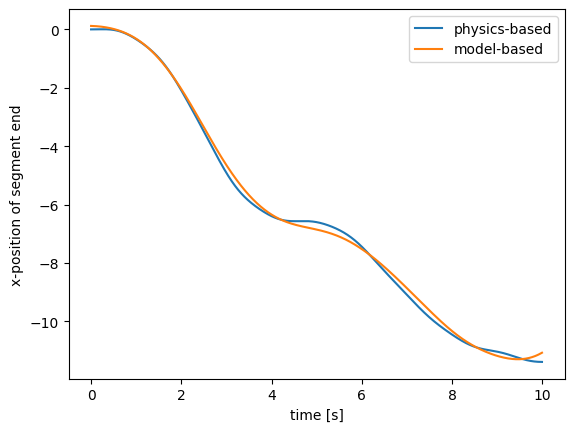

In [18]:
from cc.examples.feedforward_controller import make_feedforward_controller
from cc.env.collect import collect

controller = make_feedforward_controller(sample_train.action[0])
pred_sample, _ = collect(env_model, controller)

import matplotlib.pyplot as plt 

plt.plot(env.ts, sample_train.obs["xpos_of_segment_end"][0, :-1], label="physics-based")
plt.plot(env.ts, pred_sample.obs["xpos_of_segment_end"][0, :-1], label = "model-based")
plt.xlabel("time [s]")
plt.ylabel("x-position of segment end")
plt.legend()


In [19]:
# save model for usage in next notebook
eqx.tree_serialise_leaves("model.eqx", fitted_model)

In [20]:
# reload model
del fitted_model
fitted_model = eqx.tree_deserialise_leaves("model.eqx", model) 